# Case Description

Source:
https://twitter.com/eric_capuano/status/1557962426359992321

Synopsis:
For DEFCON30, Opensoc created 2 DFIR challenges.
"The challenge will consist of 100% offline analysis of systems impacted by an intrusion. We used Velociraptor to collect key forensic files from each impacted endpoint, and zipped them up for you to download and process/analyze."

This write-up explores the Challenge 1.

# Goals and Methodology

The goal is to uncover as much as possible the threat actor activities ("when, what, who, where, how"), like in case 1. 
However, in this write-up, we focus on how Pandas and basic visualizations allow to keep a global overview of the case across the subjects, so the efforts are put on:
- the start date of the breach
- the vector of compromise
- the patient 0
- the lateral movements

The context is different than case 1: there are 6 subjects to analyze. 
At this scale, the disks were not completely dumped (time to dump + time to backup + time to extract artifacts). Instead, Velociraptor agents were deployed on subjects, and live artifacts were collected, reducing significantly the time needed before starting the investigation. 
This means that we do not have all files to analyze their content when needed, and we do not have file hashes to compare with Threat Intelligence. 
Also, the collection performed by the agent might uses the same binaries than a threat actor would do: we should take care to not confuse threat actor with the analysts when selecting our indicators !

Table of Contents (reader can jump straight to Conclusion on the Case to get only final visualizations):
- Data Overview and Preparation
- Reducing the Time Frame
- First Indicator(s) Hunting
- Taking a Step Back
- Cobalt Strike Activity
- Cobalt Strike Sacrificial Process Purposes
- Taking a Step Back
- Beginning of the attack
- Conclusion on the Case
- Conclusion on Pandas

We initiate the variable answers to store our understanding as we progress, as well as create a pretty print function for it.

In [1]:
answers = {
    'start': [],
    'vector': [],
    'patient0': [],
    'persistence': [],
    'c2': [],
    'lateral_movement': [],
    'other': [],
}

In [2]:
def display_answers(answers):
    flattened = [{'category': key, 'description': value} for key, values in answers.items() for value in values]
    return pd.DataFrame(flattened)

# Data Overview and Preparation

With 6 disks to analyze, we load each events in their own dataframe, join them in a unique dataframe, with an additional column __subject__ to quickly identify the subject for a given event. 
We then clean the data like in case 1, all at a time.

In [3]:
# we load all the needed modules and set usual options
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.ticker as mticker
import seaborn as sns
import scipy as sp
import pygraphviz as pgv
from io import BytesIO
from IPython.display import Image, display
import warnings
warnings.filterwarnings('ignore')
import gc

%matplotlib inline
sns.set()

pd.options.display.float_format = '{:.6f}'.format
pd.set_option('max_colwidth', 500)

In [4]:
# choose columns order
columns = [
    'datetime', 'subject', 'source', 'raw', 
    'evtx_info', 'size_bytes', 'bytes_received', 'bytes_sent',
    'fair_tags', 'data_type', 'timestamp', 'timestamp_desc'
]
df = pd.DataFrame(columns=columns)

# load the data
subjects = ['ACC-01', 'ACC-02', 'ACC-03', 'ACC-04', 'ACC-07', 'ACC-10']
for subject in subjects:
    events = 'case_2/light_events_{}.ndjson'.format(subject)
    df_subject = pd.read_json(events, lines=True, convert_dates=False)
    df_subject['subject'] = subject
    df = pd.concat([df, df_subject], axis=0)

df = df.sort_index()

# display structure of the dataframe
df.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1307986 entries, 0 to 243884
Data columns (total 12 columns):
 #   Column          Non-Null Count    Dtype 
---  ------          --------------    ----- 
 0   datetime        1307986 non-null  object
 1   subject         1307986 non-null  object
 2   source          1307986 non-null  object
 3   raw             1307986 non-null  object
 4   evtx_info       720572 non-null   object
 5   size_bytes      587414 non-null   object
 6   bytes_received  0 non-null        object
 7   bytes_sent      0 non-null        object
 8   fair_tags       660901 non-null   object
 9   data_type       0 non-null        object
 10  timestamp       1307986 non-null  object
 11  timestamp_desc  587414 non-null   object
dtypes: object(12)
memory usage: 1.8 GB


We have a total of 1 307 986 events for the 6 subjects. 
Time for cleaning and enrichment, like in case 1.

In [5]:
df['datetime'] = pd.to_datetime(df['datetime'], errors='coerce', utc=True)\
    .fillna(pd.to_datetime(pd.Timestamp.max, utc=True))
df = df.set_index('datetime')

df = df.drop(df[df['timestamp'] == 0].index)
df['timestamp_desc'] = df['timestamp_desc'].fillna('-')
df['evtx_info'] = df['evtx_info'].fillna('-')
df['fair_tags'] = df['fair_tags'].fillna('-')

df['size_bytes'] = df['size_bytes'].fillna(0)/(2**20)
df = df.rename(columns={'size_bytes': 'file_size_mb'})


# delete columns where values are all missing
del df['bytes_received']
del df['bytes_sent']
del df['data_type']

df.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1307986 entries, 2009-06-10 20:31:43+00:00 to 2262-04-11 23:47:16.854775807+00:00
Data columns (total 8 columns):
 #   Column          Non-Null Count    Dtype  
---  ------          --------------    -----  
 0   subject         1307986 non-null  object 
 1   source          1307986 non-null  object 
 2   raw             1307986 non-null  object 
 3   evtx_info       1307986 non-null  object 
 4   file_size_mb    1307986 non-null  float64
 5   fair_tags       1307986 non-null  object 
 6   timestamp       1307986 non-null  object 
 7   timestamp_desc  1307986 non-null  object 
dtypes: float64(1), object(7)
memory usage: 1.6 GB


In [6]:
df['in_user_profile'] = df['raw'].str.lower().str.contains(r'/users/|\\users\\')

f_mft = df['source'] == 'mft'
f_created = df['timestamp_desc'].str.endswith('b')
df['file_created'] = f_mft & f_created

df['to_keep'] = False
df['report_desc'] = np.nan
df['mitre_tactic'] = np.nan
df.iloc[[0,-1]]

subject source  \
datetime                                             
2009-06-10 20:31:43+00:00            ACC-01    mft   
2262-04-11 23:47:16.854775807+00:00  ACC-07    mft   

                                                                                                                                                               raw  \
datetime                                                                                                                                                             
2009-06-10 20:31:43+00:00            /Windows/System32/DriverStore/FileRepository/averfx2hbh826d_noaverir_x64.inf_amd64_neutral_da2ba9e8a30dad14/AVerFx2hbtv64.sys   
2262-04-11 23:47:16.854775807+00:00      /Users/Judy.Fisher/AppData/Local/Microsoft/Windows/Temporary Internet Files/Low/Content.IE5/3UDQ3E2K/blog_corp_net[1].htm   

                                    evtx_info  file_size_mb     fair_tags  \
datetime                                                                    
2009-06-10 20:31:43+00:00                   -      0.278687  mft mft_ma.b   
2262-04-11 23:47:16.854775807+00:00         -      0.000000  mft mft_..c.   

                                             timestamp timestamp_desc  \
datetime                                                                
2009-06-10 20:31:43+00:00            1244665903.000000           ma.b   
2262-04-11 23:47:16.854775807+00:00 29057146475.000000           ..c.   

                                     in_user_profile  file_created  to_keep  \
datetime                                                                      
2009-06-10 20:31:43+00:00                      False          True    False   
2262-04-11 23:47:16.854775807+00:00             True         False    False   

                                     report_desc  mitre_tactic  
datetime                                                        
2009-06-10 20:31:43+00:00                    NaN           NaN  
2262-04-11 23:47:16.854775807+00:00          NaN           NaN

In [7]:
indicators = []

# Reducing the Time Frame
Like in case 1, the description does not specify the time frame of the attack. 
We proceed the same way: we plot the number of events in user profiles, for each subject.

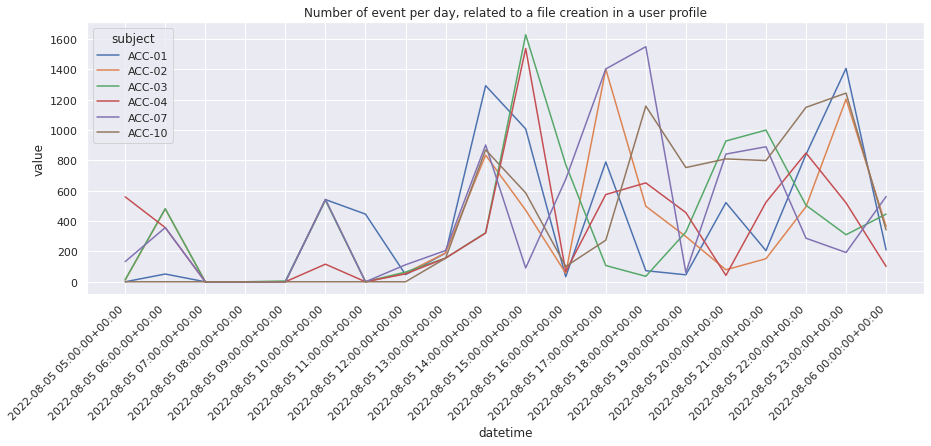

In [8]:
# we exclude date in the future (might be extraction errors or tampering or expiration date, will see later)
f_end = df.index < '2023'
#f_start = df.index >= '2022-08'
f_start = df.index >= '2022-08-04'
f_user = df['in_user_profile'] == True
f_created = df['file_created'] == True

df_nb_event_user = df[f_start & f_end & f_user & f_created]\
    .groupby([pd.Grouper(freq='H'), 'subject'])\
    .size()\
    .unstack()\
    .asfreq('H')\
    .fillna(0)\
    .astype(int)

df_long = df_nb_event_user.melt(ignore_index=False).reset_index()
df_long['datetime'] = df_long['datetime'].astype('str')
fig, ax = plt.subplots(figsize=(15, 5))
ax.set_title('Number of event per day, related to a file creation in a user profile')
sns.lineplot(data=df_long, x='datetime', y='value', hue='subject')
_ = ax.set_xticklabels(df_long['datetime'], rotation=45, ha='right')


With successive refinements, we observe that for all subjects, the file creations in user profiles occured on 2022, August 5th, with a significant increase starting from 13h00.

The 24 hours time frame is short, we can start hunting without more refinement.

In [9]:
df_refined = df.loc['2022-08-05':'2022-08-06 00:00:00', :]
df_refined.shape

(1201476, 13)

# First Indicator(s) Hunting

The strategy here is to first identify the patient 0, look for initial access and indicators on it, then apply the findings on the other subjects to complete the picture.

Having multiple subjects infected implies lateral movement, but also executions. 
It might be difficult to directly hunt for lateral movements and pick the start of the chain as we have no clue on the threat actor means to pivot (RDP, SMB-based, DCOM-based, WinRM-based to name a few). 
Some good reads on the topic: https://posts.specterops.io/offensive-lateral-movement-1744ae62b14f, https://carvesystems.com/news/credentialed-windows-remote-code-execution-techniques/.

However, if we abstract the hunt: whatever the tools used, the threat actor should have triggered some abnormal executions, and the subject exhibiting the earliest ones would be our patient 0. 
This way, we take no assumption on the techniques and focus on the tactic. 

We get a first glance of executions from fair_tags for each subject. Quick reminder: fair_tags are applied on some artifacts known to embed threat actor's traces. 
However, these tagged events are neither all the doing of the threat actor, there is also legitimate activities we will have to sort from, nor exhaustive (for instance Sysmon events are not tagged as their significance highly depend on the configuration unlike other Windows event channels whose auditing ensure consistent logging once enabled).

For this first overview, we focus on event tags related to process/service execution, and reuse the same Pandas filtering and plotting as in case 1 to get a first timeline of executions across subjects.

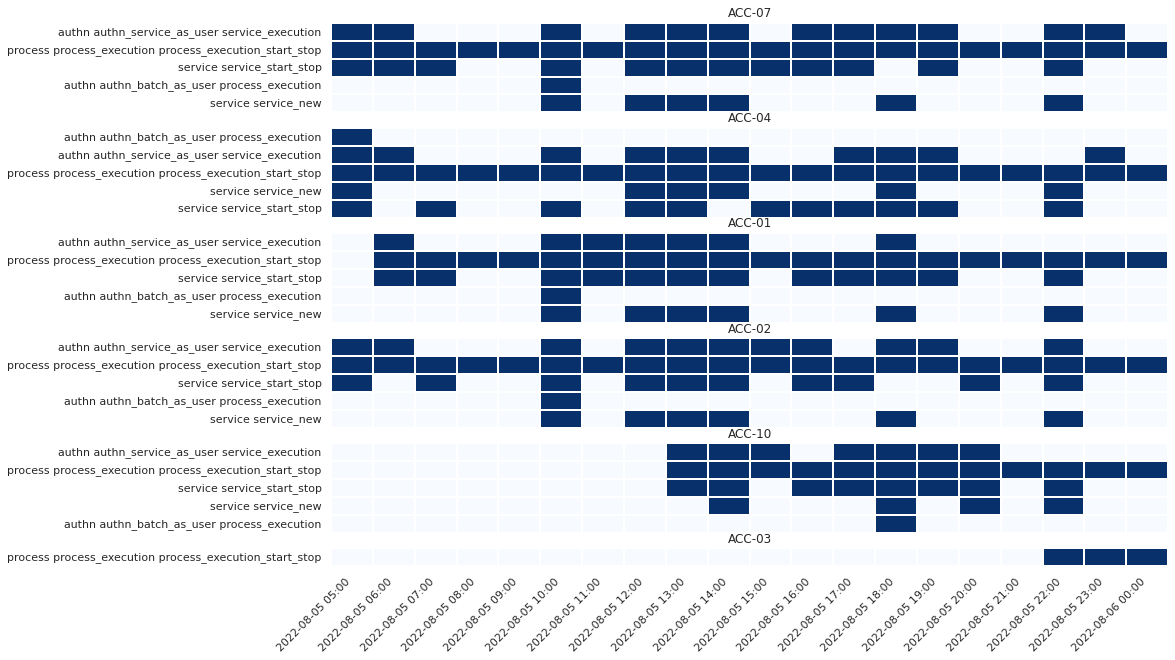

In [10]:
f_tags = df_refined['fair_tags'].str.lower().str.contains('process|service')
f_not_mft = df_refined['source'] != 'mft'

subjects = df_refined.loc[f_tags & f_not_mft, 'subject'].unique()

df_tags = df_refined[f_tags & f_not_mft]\
    .groupby([pd.Grouper(freq='H'), 'subject', 'fair_tags'])\
    .size()\
    .unstack(['subject', 'fair_tags'])\
    .asfreq('H')\
    .fillna(0)\
    .gt(0)\
    .astype(int)
df_tags.index = df_tags.index.to_period('T')

total_events = df_tags.T.index.size
ratios = []
for subject in subjects:
    ratios.append(df_tags[subject].T.size/total_events)
    
fig, axs = plt.subplots(len(subjects), figsize=(15, 10), gridspec_kw={'height_ratios': ratios}, sharex=True)
for i in range(0, len(subjects)):
    subject = subjects[i]
    axs[i].set_title(subject)
    sns.heatmap(df_tags[subject].T, cmap='Blues', vmin=0.0, vmax=1.0, cbar=False, linewidth=0.1, ax=axs[i])
    axs[i].set_xlabel('')
    axs[i].set_ylabel('')
    axs[i].set_yticklabels(axs[i].get_yticklabels(), rotation=0)
    axs[i].set_xticklabels(axs[i].get_xticklabels(), rotation=45, ha='right')

From this timeline per subject, the promising candidates for the patient 0 are ACC-02/04/07, and we also keep ACC-01 as the first executions occurs only 1 hour after those.

We correlate these __fair_tags__ with the source to figure out the ones that will be useful to identify the patient 0 (as stated earlier, each source has its own set of information, some more useful than others). 

We build the pivot table to get the correlation between a tag and the origin of the event. 

In [11]:
f_tags = df_refined['fair_tags'].str.lower().str.contains('process|service')
f_not_mft = df_refined['source'] != 'mft'
df_refined[f_tags & f_not_mft]\
    .groupby(['fair_tags', 'evtx_info'])\
    .size()\
    .fillna(0)\
    .unstack(fill_value=0)\
    .astype(int)\
    .style.highlight_between(left=0, inclusive='right', color='skyblue')

As usual on a Windows system, we observe lots of Event ID 4688 (47905), related to process creation. 
Despite the noisy logging, this source is the most promising at the moment:
- The threat actor will probably implant its own tools
- Its toolbox will probably be similar between subjects
- A persistence mechanism will also be reflected in these logs at execution time

Hence, to hunt for abnormal executions, we first focus on these EID 4688, and especially for unusual binaries paths (out of C:/Windows and C:/Program Files).
We display the content of one such raw event to locate the fields of interest and extract them (in the full events.ndjson, the fields are ready at hand, but it's less easy to get the picture across hosts). 

In [12]:
def display_windows_event(df_, evtx_info):
    f_event = df_['evtx_info'] == evtx_info
    print(df_.loc[f_event, 'raw'].head(1).values[0])

In [13]:
display_windows_event(df_refined, 'Security;Microsoft-Windows-Security-Auditing;4688')

<Event xmlns="http://schemas.microsoft.com/win/2004/08/events/event">
  <System>
    <Provider Name="Microsoft-Windows-Security-Auditing" Guid="{54849625-5478-4994-A5BA-3E3B0328C30D}"/>
    <EventID>4688</EventID>
    <Version>1</Version>
    <Level>0</Level>
    <Task>13312</Task>
    <Opcode>0</Opcode>
    <Keywords>0x8020000000000000</Keywords>
    <TimeCreated SystemTime="2022-08-05T05:57:43.943803100Z"/>
    <EventRecordID>6307</EventRecordID>
    <Correlation/>
    <Execution ProcessID="4" ThreadID="52"/>
    <Channel>Security</Channel>
    <Computer>ACC-07.corp.net</Computer>
    <Security/>
  </System>
  <EventData>
    <Data Name="SubjectUserSid">S-1-5-18</Data>
    <Data Name="SubjectUserName">ACC-07$</Data>
    <Data Name="SubjectDomainName">CORP</Data>
    <Data Name="SubjectLogonId">0x00000000000003e7</Data>
    <Data Name="NewProcessId">0x0000000000000b18</Data>
    <Data Name="NewProcessName">C:\Windows\Microsoft.NET\Framework64\v4.0.30319\mscorsvw.exe</Data>
    <Data N

For now, we are interested in the extraction of the field __NewProcessName__: it contains the absolute path to the exeutable, so it's adequate to spot unsual locations. 

In [14]:
f_4688 = df_refined['evtx_info'] == 'Security;Microsoft-Windows-Security-Auditing;4688'
df_4688 = df_refined.loc[f_4688, ['subject', 'raw']]
df_4688['process_name'] = df_4688['raw'].str.extract('<Data Name="NewProcessName">([^<]*)</Data>', expand=False)

df_4688.head(1)

subject  \
datetime                            
2022-08-05 05:57:43+00:00  ACC-07   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                           raw  \
datetime                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                         
2022-08-05 05:57:43+00:00  <Event xmlns="http://schemas.microsoft.com/win/2004/08/events/event">\n  <System>\n    <Provider Name="Microsoft-Windows-Security-Auditing" Guid="{54849625-5478-4994-A5BA-3E3B0328C30D}"/>\n    <EventID>4688</EventID>\n    <Version>1</Version>\n    <Level>0</Level>\n    <Task>13312</Task>\n    <Opcode>0</Opcode>\n    <Keywords>0x8020000000000000</Keywords>\n    <TimeCreated SystemTime="2022-08-05T05:57:43.943803100Z"/>\n    <EventRecordID>6307</EventRecordID>\n    <Correlation/>\n    <Executi...   

                                                                           process_name  
datetime                                                                                 
2022-08-05 05:57:43+00:00  C:\Windows\Microsoft.NET\Framework64\v4.0.30319\mscorsvw.exe

Let see now, per subject, the binaries out of C:\Windows, C:\Program Files and C:\ProgramData (as well as its short version C:\PROGRA), together with the number of executions. 
We look for suspicious executable files, most probably with a similar pattern between subjects.

In [15]:
f_usual = df_4688['process_name'].str.contains('^C:\\\\(Windows|Program Files|ProgramData|PROGRA)', regex=True)

df_4688[~f_usual]\
    .groupby(['process_name', 'subject']).size()\
    .unstack()\
    .fillna(0)\
    .astype(int)\
    .style.highlight_between(left=0, inclusive='right', color='skyblue')

There are a bunch of interesting paths, but unfortunately, the files were not collected to allow a quick validation (in a real investigation, we would execute new queries on the agents to collect them, or run some yara rules). 
The binary name is not sufficient to presume the purpose (svchost.exe, rundll32.exe are often used by threat actors for instance).

Also, in this adversaries simulation, the machines deployment seems to install tools at the root of the C drive. For example, when checking files under the folder __C:\salt__ through the MFT, it pretty looks like https://github.com/saltstack/salt, which sounds like CTF organizer toolbox :). It sounds to be also the case for the suspicious __Setup.exe__, __SetupUtility.exe__, and __install.exe__ (same exe on the subjects, but in a randomized path) which seems related to be a temporary folder during .NET installation.

We still have some good suspicious candidates: __ADMIN$__ paths are highly suspicious: it's the administrative share pointing to the system root (here, C:\Windows). They reflects a remote execution with administrator privileges. Also, a curious pattern can be observed on all subjects: the binary name is random. Unlike the temporary random folder name during .NET installation, there is no point for an admin to use a random executable name.

To sum up, we went from 1 201 476 events to 49 705 executions and now 5 candidates in 3 filters, without any assumptions on the threat actor toolbox.  
To confirm or deny these executions are the doing of the threat actor, we analyze the events tight to them.

In [16]:
new_indicators = ['27f96ba.exe', 'b8a3848.exe', '4e6964b.exe', 'b9b362b.exe', '42f7d05.exe']

In [17]:
f_indicators = df['raw'].str.lower().str.contains('|'.join(new_indicators))

s_keywords = df.loc[f_indicators, 'raw']\
    .str.lower().str.extract('('+ '|'.join(new_indicators) + ')', expand=False)

df[f_indicators]\
    .groupby([s_keywords, 'evtx_info']).size()\
    .unstack()\
    .fillna(0)\
    .astype(int).T\
    .style.highlight_between(left=0, inclusive='right', color='skyblue')

Apart from the very same pattern of logs for the 5  executables, we have a bunch of interesting events:
- EID 4688 from Security channel is the one we already used to spot these 5 binaries and indicate a process creation
- EID 7045 from System channel reflects a service creation: it's a way to ensure execution persistence
- The remaining events are attached to Sysmon channel, an official tool from Microsoft SysInternals to monitor and log system activity (https://learn.microsoft.com/en-us/sysinternals/downloads/sysmon). Especially in our context:
    - EID 1 logs process creation. It's redundant with EID 4688
    - EID 7 indicates an executable loaded in memory. It contains 1 crucial information to overcome the files not collected: the md5 and ImpHash (https://www.mandiant.com/resources/blog/tracking-malware-import-hashing). The ImpHash is a "partial hash" for executable file, it only hash the imported functions. This way, while a complete hash might be too specific and yet unknown from the Threat Intelligence, the ImpHash can point to "functionnally similar" executable/malware.
    - EID 11 logs file creation. We don't have any MFT events for the 5 binaries, and that's why this EID complete the MFT: if a file is deleted and the inode is reused, the file won't appear in the MFT timeline.
    - EID 13 records a value set in a registry key. This is also a mean of persistence.
    - EID 17 and 18 records respectively the creation and connection to a pipe. A excellent article on Windows pipes is available here: https://versprite.com/blog/security-research/microsoft-windows-pipes-intro/. In a nutshell, pipes are used for inter-process communications, and named pipes can be used to communicate over the network, hence frequently abused by threat actors for lateral movements.
    
We extract the hashes from Sysmon EID 7, and verify them against Threat Intelligence.

In [18]:
# create a dataframe with meaningful info from Sysmon EID7 (image loaded)
f_sysmon_7 = df_refined['evtx_info'] == 'Microsoft-Windows-Sysmon/Operational;Microsoft-Windows-Sysmon;7'
df_sysmon_7 = df_refined.loc[f_sysmon_7, ['subject', 'raw']]
df_sysmon_7['process_name'] = df_sysmon_7['raw'].str.extract('<Data Name="ImageLoaded">([^<]*)</Data>', expand=False)
df_sysmon_7['hashes'] = df_sysmon_7['raw'].str.extract('<Data Name="Hashes">([^<]*)</Data>', expand=False)
df_sysmon_7['pid'] = df_sysmon_7['raw'].str.extract('<Data Name="ProcessId">([^<]*)</Data>', expand=False)

# filter on our indicators candidates
f_indicators = df_sysmon_7['raw'].str.lower().str.contains('|'.join(new_indicators))
df_sysmon_7.loc[f_indicators, ['subject', 'process_name', 'hashes']]

subject                    process_name  \
datetime                                                            
2022-08-05 22:00:05+00:00  ACC-10  \\127.0.0.1\ADMIN$\27f96ba.exe   
2022-08-05 22:17:30+00:00  ACC-01     \\ACC-01\ADMIN$\b8a3848.exe   
2022-08-05 22:22:17+00:00  ACC-07     \\ACC-07\ADMIN$\4e6964b.exe   
2022-08-05 22:31:37+00:00  ACC-02     \\ACC-02\ADMIN$\b9b362b.exe   
2022-08-05 22:26:26+00:00  ACC-04     \\ACC-04\ADMIN$\42f7d05.exe   

                                                                                                  hashes  
datetime                                                                                                  
2022-08-05 22:00:05+00:00  MD5=322C3BCA32697C473B04F8EEF068BF84,IMPHASH=DE77F3139EAF74F1B255AB7BE0B6605F  
2022-08-05 22:17:30+00:00  MD5=48452DD856C05E2942D9311A4917BEA6,IMPHASH=DE77F3139EAF74F1B255AB7BE0B6605F  
2022-08-05 22:22:17+00:00  MD5=C0C68E432CB9416B326DE705B4E582EC,IMPHASH=DE77F3139EAF74F1B255AB7BE0B6605F  
2022-08-05 22:31:37+00:00  MD5=C7F7C90E47C5E24FECC19CCEF2EC820F,IMPHASH=DE77F3139EAF74F1B255AB7BE0B6605F  
2022-08-05 22:26:26+00:00  MD5=EB1EF2CC4520FB57C1F73817E7261BC6,IMPHASH=DE77F3139EAF74F1B255AB7BE0B6605F

That's interesting:
- each binary has a distinct md5 value
- but all of them share the same ImpHash

Looking on online Threat Intelligence services, we do confirm with the ImpHash that these executables are related to a threact actor activity: they share the characteristics of Cobalt Strike, a famous offensive framework (https://redcanary.com/threat-detection-report/threats/cobalt-strike/) especially reputed to evade defense. 

We keep track of Cobalt Strike information in few dataframes, all named __df_cobalt_\*__, starting with the loaders.

In [19]:
f_indicators = df_sysmon_7['raw'].str.lower().str.contains('|'.join(new_indicators))
df_cobalt_loaders = df_sysmon_7[f_indicators]

We got our first indicators, it's time to save events for the report and finally identify the patient 0. 

Despite named pipes are usually associated to lateral movement, it is not the case in Cobalt Strike contect. 
Indeed, Cobalt Strike makes a heavy use of named pipes, not only for lateral movements, but also for post-exploitation jobs. 
In a nutshell, a named pipe is created for every task instructed (load the beacon, start keylogger, perform lateral movement, elevate privileges, ...). The different processes then communicate their results to the beacon through the pipe, and the beacon forwards to the C2. 
More on this in these blog posts: 
- https://svch0st.medium.com/guide-to-named-pipes-and-hunting-for-cobalt-strike-pipes-dc46b2c5f575
- https://blog.sekoia.io/hunting-and-detecting-cobalt-strike/
- https://www.cobaltstrike.com/blog/learn-pipe-fitting-for-all-of-your-offense-projects/

Hence, we assign the occurences of name pipes creation and connection (Sysmon EID 17 and 18) to execution for the moment, we can reassign the Mitre tactic later, once we understand better what they were used for.

In [20]:
f_indicators = df['raw'].str.lower().str.contains('|'.join(new_indicators))

# save events related to Cobalt Strike file creation
f_creation = df['evtx_info'] == 'Microsoft-Windows-Sysmon/Operational;Microsoft-Windows-Sysmon;11'
df.loc[f_indicators & f_creation, 'to_keep'] = True
df.loc[f_indicators & f_creation, 'report_desc'] = 'Cobalt Strike loader created on disk, <rnd>.exe'
df.loc[f_indicators & f_creation, 'mitre_tactic'] = 'Resource Development'

# save events related to persistence
f_persistence = df['evtx_info'].isin([
    'System;Service Control Manager;7045',
    'Microsoft-Windows-Sysmon/Operational;Microsoft-Windows-Sysmon;13',    
])
df.loc[f_indicators & f_persistence, 'to_keep'] = True
df.loc[f_indicators & f_persistence, 'report_desc'] = 'Cobalt Strike loader installed as a service (<rnd>.exe)'
df.loc[f_indicators & f_persistence, 'mitre_tactic'] = 'Persistence'

# save events related to executions
f_execution = df['evtx_info'].isin([
    'Security;Microsoft-Windows-Security-Auditing;4688',
    'Microsoft-Windows-Sysmon/Operational;Microsoft-Windows-Sysmon;7',    
    'Microsoft-Windows-Sysmon/Operational;Microsoft-Windows-Sysmon;1',    
])
df.loc[f_indicators & f_execution, 'to_keep'] = True
df.loc[f_indicators & f_execution, 'report_desc'] = 'Cobalt Strike loader executed (<rnd>.exe)'
df.loc[f_indicators & f_execution, 'mitre_tactic'] = 'Execution'

# save events related to named pipes
f_execution = df['evtx_info'] == 'Microsoft-Windows-Sysmon/Operational;Microsoft-Windows-Sysmon;17'
df.loc[f_indicators & f_execution, 'to_keep'] = True
df.loc[f_indicators & f_execution, 'report_desc'] = 'Cobalt Strike named pipe creation'
df.loc[f_indicators & f_execution, 'mitre_tactic'] = 'Execution'

f_execution = df['evtx_info'] == 'Microsoft-Windows-Sysmon/Operational;Microsoft-Windows-Sysmon;18'
df.loc[f_indicators & f_execution, 'to_keep'] = True
df.loc[f_indicators & f_execution, 'report_desc'] = 'Cobalt Strike named pipe connection'
df.loc[f_indicators & f_execution, 'mitre_tactic'] = 'Execution'

# print the report
f_report = df['to_keep'] == True
df.loc[f_report, ['subject', 'mitre_tactic', 'report_desc', 'evtx_info']].head()

subject          mitre_tactic  \
datetime                                                  
2022-08-05 22:00:05+00:00  ACC-10           Persistence   
2022-08-05 22:00:05+00:00  ACC-10             Execution   
2022-08-05 22:00:05+00:00  ACC-10  Resource Development   
2022-08-05 22:00:05+00:00  ACC-10           Persistence   
2022-08-05 22:00:05+00:00  ACC-10             Execution   

                                                                       report_desc  \
datetime                                                                             
2022-08-05 22:00:05+00:00  Cobalt Strike loader installed as a service (<rnd>.exe)   
2022-08-05 22:00:05+00:00                Cobalt Strike loader executed (<rnd>.exe)   
2022-08-05 22:00:05+00:00          Cobalt Strike loader created on disk, <rnd>.exe   
2022-08-05 22:00:05+00:00  Cobalt Strike loader installed as a service (<rnd>.exe)   
2022-08-05 22:00:05+00:00                Cobalt Strike loader executed (<rnd>.exe)   

                                                                                  evtx_info  
datetime                                                                                     
2022-08-05 22:00:05+00:00                               System;Service Control Manager;7045  
2022-08-05 22:00:05+00:00                 Security;Microsoft-Windows-Security-Auditing;4688  
2022-08-05 22:00:05+00:00  Microsoft-Windows-Sysmon/Operational;Microsoft-Windows-Sysmon;11  
2022-08-05 22:00:05+00:00  Microsoft-Windows-Sysmon/Operational;Microsoft-Windows-Sysmon;13  
2022-08-05 22:00:05+00:00   Microsoft-Windows-Sysmon/Operational;Microsoft-Windows-Sysmon;1

In [21]:
answers['patient0'].append('ACC-10 (first cobalt installation and execution at 22h00 + 127.0.0.1)')
answers['persistence'].extend([
    'Cobalt loader installed as a service (27f96ba.exe,b8a3848.exe,4e6964b.exe,b9b362b.exe,42f7d05.exe)',
    'Cobalt loaders <rnd>.exe: same IMPHASH=DE77F3139EAF74F1B255AB7BE0B6605F'
])

In [22]:
indicators += new_indicators

# Taking a step back

Before going further, we visualize the current timeline. 
Like in case 1, this will help to define the next steps.

In [23]:
def visualize_report_by_subject(df_, frequency, figsize, ycol):
    f_report = df_['to_keep'] == True
    subjects = df_.loc[f_report, 'subject'].unique().tolist()

    df_report = df_[f_report]\
        .groupby([pd.Grouper(freq=frequency), 'subject', ycol])\
        .size()\
        .unstack(['subject', ycol])\
        .asfreq(frequency)\
        .fillna(0)\
        .gt(0)\
        .astype(int)\

    df_report.index = df_report.index.to_period('T')

    total_events = df_report.T.index.size
    ratios = []
    for subject in subjects:
        ratios.append(df_report[subject].T.size/total_events)

    fig, axs = plt.subplots(len(subjects), figsize=figsize, gridspec_kw={'height_ratios': ratios}, sharex=True)
    for i in range(0, len(subjects)):
        subject = subjects[i]
        axs[i].set_title(subject)
        sns.heatmap(df_report[subject].T, cmap='Blues', vmin=0.0, vmax=1.0, cbar=False, linewidth=0.1, ax=axs[i])
        axs[i].set_xlabel('')
        axs[i].set_ylabel('')
        axs[i].set_yticklabels(axs[i].get_yticklabels(), rotation=0)
        axs[i].set_xticklabels(axs[i].get_xticklabels(), rotation=45, ha='right')

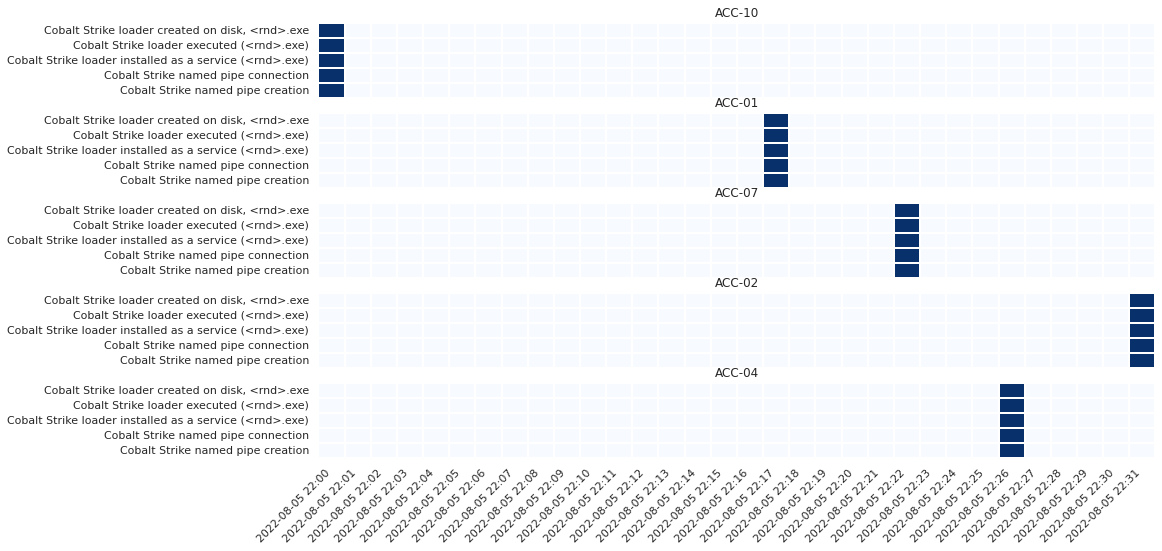

In [24]:
visualize_report_by_subject(df, 'T', (15,8), 'report_desc')

In [25]:
display_answers(answers)

category  \
0     patient0   
1  persistence   
2  persistence   

                                                                                          description  
0                               ACC-10 (first cobalt installation and execution at 22h00 + 127.0.0.1)  
1  Cobalt loader installed as a service (27f96ba.exe,b8a3848.exe,4e6964b.exe,b9b362b.exe,42f7d05.exe)  
2                             Cobalt loaders <rnd>.exe: same IMPHASH=DE77F3139EAF74F1B255AB7BE0B6605F

So, our patient 0 is ACC-10 (despite our initial hunch), but we still don't know:
- how the first beacon was implanted
- what is the threat actor C2
- what activity was done by the threat actor using Cobalt Strike.

# Cobalt Strike Activity

As mentionned earlier, Cobalt Strike is an all-in-one toolbox for many tactics (privilege escalation, lateral movement, persistence, C2 connections, ...). 
To stay under the radar, it uses named pipes for inter process communications and spawns new "apparently benign" processes (called sacrificial process) to inject payloads. 

We first identify the sacrificial process chosen by the threat actor. 
Based on the identified, we follow the processes, parents and children, and the recurrent one will point the sacrificial process. 

So we first need to build the chain of processes from the indicators: we use information embedded in the Sysmon EID 1 (process create).

In [26]:
display_windows_event(df, 'Microsoft-Windows-Sysmon/Operational;Microsoft-Windows-Sysmon;1')

<Event xmlns="http://schemas.microsoft.com/win/2004/08/events/event">
  <System>
    <Provider Name="Microsoft-Windows-Sysmon" Guid="{5770385F-C22A-43E0-BF4C-06F5698FFBD9}"/>
    <EventID>1</EventID>
    <Version>5</Version>
    <Level>4</Level>
    <Task>1</Task>
    <Opcode>0</Opcode>
    <Keywords>0x8000000000000000</Keywords>
    <TimeCreated SystemTime="2022-08-05T21:11:15.726736700Z"/>
    <EventRecordID>123139</EventRecordID>
    <Correlation/>
    <Execution ProcessID="1428" ThreadID="1916"/>
    <Channel>Microsoft-Windows-Sysmon/Operational</Channel>
    <Computer>ACC-10.corp.net</Computer>
    <Security UserID="S-1-5-18"/>
  </System>
  <EventData>
    <Data Name="RuleName"/>
    <Data Name="UtcTime">2022-08-05 21:11:15.680</Data>
    <Data Name="ProcessGuid">{140A6FA9-8773-62ED-0000-0010439B3C01}</Data>
    <Data Name="ProcessId">7004</Data>
    <Data Name="Image">C:\salt\bin\python.exe</Data>
    <Data Name="FileVersion">?</Data>
    <Data Name="Description">?</Data>
    <D

In [27]:
# create the dataframe with useful info from Sysmon EID 1
f_sysmon_1 = df_refined['evtx_info'] == 'Microsoft-Windows-Sysmon/Operational;Microsoft-Windows-Sysmon;1'
df_sysmon_1 = df_refined.loc[f_sysmon_1, ['subject', 'raw']]

df_sysmon_1['pid'] = df_sysmon_1['raw'].str.extract('<Data Name="ProcessId">([^<]*)</Data>', expand=False)
df_sysmon_1['ppid'] = df_sysmon_1['raw'].str.extract('<Data Name="ParentProcessId">([^<]*)</Data>', expand=False)
df_sysmon_1['process_name'] = df_sysmon_1['raw'].str.extract('<Data Name="Image">([^<]*)</Data>', expand=False)
df_sysmon_1['parent_process_name'] = df_sysmon_1['raw'].str.extract('<Data Name="ParentImage">([^<]*)</Data>', expand=False)
df_sysmon_1['cmdline'] = df_sysmon_1['raw'].str.extract('<Data Name="CommandLine">([^<]*)</Data>', expand=False)
df_sysmon_1['user'] = df_sysmon_1['raw'].str.extract('<Data Name="User">([^<]*)</Data>', expand=False)

# filter on first known cobalt execution
f_cobalt_start = df_sysmon_1['process_name'].str.contains('ADMIN$', regex=False)
df_sysmon_1.loc[f_cobalt_start, ['subject', 'user', 'ppid', 'parent_process_name', 'pid', 'process_name', 'cmdline']]

subject                 user ppid  \
datetime                                                      
2022-08-05 22:00:05+00:00  ACC-10  NT AUTHORITY\SYSTEM  508   
2022-08-05 22:17:30+00:00  ACC-01  NT AUTHORITY\SYSTEM  476   
2022-08-05 22:22:17+00:00  ACC-07  NT AUTHORITY\SYSTEM  464   
2022-08-05 22:31:36+00:00  ACC-02  NT AUTHORITY\SYSTEM  500   
2022-08-05 22:26:26+00:00  ACC-04  NT AUTHORITY\SYSTEM  484   

                                        parent_process_name   pid  \
datetime                                                            
2022-08-05 22:00:05+00:00  C:\Windows\System32\services.exe  4860   
2022-08-05 22:17:30+00:00  C:\Windows\System32\services.exe  2508   
2022-08-05 22:22:17+00:00  C:\Windows\System32\services.exe  1488   
2022-08-05 22:31:36+00:00  C:\Windows\System32\services.exe  4496   
2022-08-05 22:26:26+00:00  C:\Windows\System32\services.exe  4264   

                                             process_name  \
datetime                                                    
2022-08-05 22:00:05+00:00  \\127.0.0.1\ADMIN$\27f96ba.exe   
2022-08-05 22:17:30+00:00     \\ACC-01\ADMIN$\b8a3848.exe   
2022-08-05 22:22:17+00:00     \\ACC-07\ADMIN$\4e6964b.exe   
2022-08-05 22:31:36+00:00     \\ACC-02\ADMIN$\b9b362b.exe   
2022-08-05 22:26:26+00:00     \\ACC-04\ADMIN$\42f7d05.exe   

                                                  cmdline  
datetime                                                   
2022-08-05 22:00:05+00:00  \\127.0.0.1\ADMIN$\27f96ba.exe  
2022-08-05 22:17:30+00:00     \\ACC-01\ADMIN$\b8a3848.exe  
2022-08-05 22:22:17+00:00     \\ACC-07\ADMIN$\4e6964b.exe  
2022-08-05 22:31:36+00:00     \\ACC-02\ADMIN$\b9b362b.exe  
2022-08-05 22:26:26+00:00     \\ACC-04\ADMIN$\42f7d05.exe

We now collect the chain of processes that stems from them.

In [28]:
# initiate the chain
f_cobalt_start = df_sysmon_1['process_name'].str.contains('ADMIN$', regex=False)
df_cobalt_processes = df_sysmon_1.loc[f_cobalt_start]

# loop on subjects
for _, row in df_sysmon_1.loc[f_cobalt_start].iterrows():
    subject = row['subject']
    children = [{'ppid': row['ppid'], 'pid': row['pid']}]
    while len(children) > 0:
        ppid = children[0]['ppid']
        pid = children[0]['pid']

        # identify potential children
        f_children = (df_sysmon_1['subject'] == subject) & (df_sysmon_1['ppid'] == pid)

        # but look forward in the time
        f_pid = (df_cobalt_processes['subject'] == subject) & (df_cobalt_processes['pid'] == pid)
        pid_time = df_cobalt_processes[f_pid].sort_index().index.astype('str').values[0]
        f_min_index = df_sysmon_1.index >= pid_time

        # and before the pid is reused, if any
        f_max_index = df_sysmon_1.index <= df_sysmon_1.index[-1]
        f_pid_reused = (df_sysmon_1.index > pid_time) & (df_sysmon_1['pid'] == pid) & (df_sysmon_1['ppid'] != ppid)
        if f_pid_reused.sum() > 0:
            f_max_index = df_sysmon_1.index < df_sysmon_1[f_pid_reused].sort_index().index.astype('str').values[0]

        # apply the filters and extend the children and chain if needed
        df_children = df_sysmon_1.loc[f_min_index & f_max_index & f_children]
        if df_children.index.size > 0:
            children.extend([{'ppid': pid, 'pid': pid_child} for pid_child in df_children['pid'].values])
            df_cobalt_processes = pd.concat([df_cobalt_processes, df_children], axis=0)
        children.pop(0)

df_cobalt_processes = df_cobalt_processes.sort_index()
df_cobalt_processes[['subject', 'ppid', 'pid', 'process_name', 'cmdline']].head()

subject  ppid   pid  \
datetime                                        
2022-08-05 22:00:05+00:00  ACC-10   508  4860   
2022-08-05 22:00:06+00:00  ACC-10  4860  1604   
2022-08-05 22:01:56+00:00  ACC-10  1604  7012   
2022-08-05 22:05:57+00:00  ACC-10  1604  2812   
2022-08-05 22:12:18+00:00  ACC-10  1604  4324   

                                               process_name  \
datetime                                                      
2022-08-05 22:00:05+00:00    \\127.0.0.1\ADMIN$\27f96ba.exe   
2022-08-05 22:00:06+00:00  C:\Windows\SysWOW64\rundll32.exe   
2022-08-05 22:01:56+00:00  C:\Windows\System32\rundll32.exe   
2022-08-05 22:05:57+00:00  C:\Windows\System32\rundll32.exe   
2022-08-05 22:12:18+00:00       C:\Windows\SysWOW64\cmd.exe   

                                                                                                                                                                                cmdline  
datetime                                                                                                                                                                                 
2022-08-05 22:00:05+00:00                                                                                                                                \\127.0.0.1\ADMIN$\27f96ba.exe  
2022-08-05 22:00:06+00:00                                                                                                                              C:\Windows\System32\rundll32.exe  
2022-08-05 22:01:56+00:00                                                                                                                             C:\Windows\sysnative\rundll32.exe  
2022-08-05 22:05:57+00:00                                                                                                                             C:\Windows\sysnative\rundll32.exe  
2022-08-05 22:12:18+00:00  C:\Windows\system32\cmd.exe /C sc create JavaUpdater binPath= "C:\Program Files (x86)\Java\jre7\bin\JavaUpdater.exe" start= auto DisplayName= "Java Updater"

Let's now figure out the prevailing process by grouping and counting the occurences of command lines.

In [29]:
df_cobalt_processes.assign(cmdline=df_cobalt_processes['cmdline'].apply(lambda x: x[:75]))\
    .groupby(['process_name', 'cmdline']).agg({'raw': 'count'})

raw
process_name                                              cmdline                                                                         
C:\Windows\SysWOW64\cmd.exe                               C:\Windows\system32\cmd.exe /C sc create JavaUpdater binPath= "C:\Program F    1
C:\Windows\SysWOW64\rundll32.exe                          C:\Windows\System32\rundll32.exe                                               5
C:\Windows\SysWOW64\sc.exe                                sc  create JavaUpdater binPath= "C:\Program Files (x86)\Java\jre7\bin\JavaU    1
C:\Windows\System32\WindowsPowerShell\v1.0\powershell.exe powershell -nop -exec bypass -EncodedCommand RwBlAHQALQBDAGgAaQBsAGQASQB0AG    5
                                                          powershell -nop -exec bypass -EncodedCommand SQBFAFgAIAAoAE4AZQB3AC0ATwBiAG    1
                                                          powershell -nop -exec bypass -EncodedCommand VABlAHMAdAAtAFAAYQB0AGgAIABDAD    5
C:\Windows\System32\cmd.exe                               C:\Windows\system32\cmd.exe /c echo 1c28e620d06 &gt; \\.\pipe\8498ca           1
                                                          C:\Windows\system32\cmd.exe /c echo 2b34c792c33 &gt; \\.\pipe\fee489           1
                                                          C:\Windows\system32\cmd.exe /c echo 86420bf6b30 &gt; \\.\pipe\55bbda           1
                                                          C:\Windows\system32\cmd.exe /c echo 8b6f83f777a &gt; \\.\pipe\cef512           1
                                                          C:\Windows\system32\cmd.exe /c echo e3140eabda6 &gt; \\.\pipe\d99345           1
C:\Windows\System32\rundll32.exe                          C:\Windows\sysnative\rundll32.exe                                              7
\\127.0.0.1\ADMIN$\27f96ba.exe                            \\127.0.0.1\ADMIN$\27f96ba.exe                                                 1
\\ACC-01\ADMIN$\b8a3848.exe                               \\ACC-01\ADMIN$\b8a3848.exe                                                    1
\\ACC-02\ADMIN$\b9b362b.exe                               \\ACC-02\ADMIN$\b9b362b.exe                                                    1
\\ACC-04\ADMIN$\42f7d05.exe                               \\ACC-04\ADMIN$\42f7d05.exe                                                    1
\\ACC-07\ADMIN$\4e6964b.exe                               \\ACC-07\ADMIN$\4e6964b.exe                                                    1

We got our sacrificial process: __rundll32.exe__ (from SysWOW64/ for the 32-bits version, and from System32/ for the 64-bit version ... there is no typo, that's Windows :) ). 
Indeed, it accounts for 12 command lines without arguments, which is pretty unusual, and also, it's the default sacrificial process in Cobalt Strike. 

The process powershell.exe also exhibits duplicates, but given the beginning of the command line arguments, it's only means that the same command was executed 5 times across hosts, it's not an injection.

In [30]:
answers['other'].append('CS sacrificial process: rundll32.exe (64 and 32 bits)')

The __powershell__ commands are base64 encoded and revert respectively to:
- "Get-ChildItem -Path C:\ -Recurse -Include \*swift\*": the threat actor look for any file on the C drive, containing the word _swift_
- "IEX (New-Object Net.Webclient).DownloadString('http://127.0.0.1:59886/'); Get-Y3J5cHRy": it downloads a powershell script exposed locally on port 59886, then calls the function Get-Y3J5cHRy.
- "Test-Path C:\ACH": the threat actor verify if the path C:\ACH exists on the disk

There are 2 kinds of __cmd.exe__ commands:
- 1 creates a service with __sc__: it's a new persistence disguised in a probably fake JavaUpdater.exe.
- the others echo a string in a named pipe: remember, Cobalt Strike uses this mechanism to communicates between its payloads and with the beacon

We try to get more info (especially the hashes) from JavaUpdater.exe using Sysmon EID 7.

In [31]:
f_java = df_sysmon_7['process_name'].str.lower().str.contains('javaupdater.exe')
df_sysmon_7.loc[f_java, ['subject', 'process_name', 'hashes']]

subject  \
datetime                            
2022-08-05 22:14:11+00:00  ACC-10   

                                                                   process_name  \
datetime                                                                          
2022-08-05 22:14:11+00:00  C:\Program Files (x86)\Java\jre7\bin\JavaUpdater.exe   

                                                                                                  hashes  
datetime                                                                                                  
2022-08-05 22:14:11+00:00  MD5=EB61AD33B108DED34DF7597BC0D81EFB,IMPHASH=BED5688A4A2B5EA6984115B458755E90

The ImpHash also points to Cobalt Strike signatures: it is another loader, we add it to __df_cobalt_loaders__.

In [32]:
df_cobalt_loaders = pd.concat([df_cobalt_loaders, df_sysmon_7[f_java]]).drop_duplicates().sort_index()
df_cobalt_loaders[['subject', 'process_name', 'hashes', 'pid']]

subject  \
datetime                            
2022-08-05 22:00:05+00:00  ACC-10   
2022-08-05 22:14:11+00:00  ACC-10   
2022-08-05 22:17:30+00:00  ACC-01   
2022-08-05 22:22:17+00:00  ACC-07   
2022-08-05 22:26:26+00:00  ACC-04   
2022-08-05 22:31:37+00:00  ACC-02   

                                                                   process_name  \
datetime                                                                          
2022-08-05 22:00:05+00:00                        \\127.0.0.1\ADMIN$\27f96ba.exe   
2022-08-05 22:14:11+00:00  C:\Program Files (x86)\Java\jre7\bin\JavaUpdater.exe   
2022-08-05 22:17:30+00:00                           \\ACC-01\ADMIN$\b8a3848.exe   
2022-08-05 22:22:17+00:00                           \\ACC-07\ADMIN$\4e6964b.exe   
2022-08-05 22:26:26+00:00                           \\ACC-04\ADMIN$\42f7d05.exe   
2022-08-05 22:31:37+00:00                           \\ACC-02\ADMIN$\b9b362b.exe   

                                                                                                  hashes  \
datetime                                                                                                   
2022-08-05 22:00:05+00:00  MD5=322C3BCA32697C473B04F8EEF068BF84,IMPHASH=DE77F3139EAF74F1B255AB7BE0B6605F   
2022-08-05 22:14:11+00:00  MD5=EB61AD33B108DED34DF7597BC0D81EFB,IMPHASH=BED5688A4A2B5EA6984115B458755E90   
2022-08-05 22:17:30+00:00  MD5=48452DD856C05E2942D9311A4917BEA6,IMPHASH=DE77F3139EAF74F1B255AB7BE0B6605F   
2022-08-05 22:22:17+00:00  MD5=C0C68E432CB9416B326DE705B4E582EC,IMPHASH=DE77F3139EAF74F1B255AB7BE0B6605F   
2022-08-05 22:26:26+00:00  MD5=EB1EF2CC4520FB57C1F73817E7261BC6,IMPHASH=DE77F3139EAF74F1B255AB7BE0B6605F   
2022-08-05 22:31:37+00:00  MD5=C7F7C90E47C5E24FECC19CCEF2EC820F,IMPHASH=DE77F3139EAF74F1B255AB7BE0B6605F   

                            pid  
datetime                         
2022-08-05 22:00:05+00:00  4860  
2022-08-05 22:14:11+00:00  1328  
2022-08-05 22:17:30+00:00  2508  
2022-08-05 22:22:17+00:00  1488  
2022-08-05 22:26:26+00:00  4264  
2022-08-05 22:31:37+00:00  4496

In [33]:
answers['other'].extend([
    'other CS Loader JavaUpdater: IMPHASH=BED5688A4A2B5EA6984115B458755E90',
    'download from 127.0.0.1:59886 then executes Get-Y3J5cHRy',
    'Search for filenames containing "swift"',
    'Test if C:\ACH exists',
])
answers['persistence'].append('other CS loader installed as a service: JavaUpdater.exe')

We save the remaining command lines identified to the report.

In [34]:
f_process = df['evtx_info'] == 'Microsoft-Windows-Sysmon/Operational;Microsoft-Windows-Sysmon;1'


# save events related to JavaUpdater persistence
f_java = df['raw'].str.contains('sc create JavaUpdater')
df.loc[f_process & f_java, 'to_keep'] = True
df.loc[f_process & f_java, 'report_desc'] = 'Cobalt Strike loader installed as a service (JavaUpdater)'
df.loc[f_process & f_java, 'mitre_tactic'] = 'Persistence'

# save events related to powershell
f_powershell = df['raw'].str.contains('EncodedCommand RwBlAH')
df.loc[f_process & f_powershell, 'to_keep'] = True
df.loc[f_process & f_powershell, 'report_desc'] = 'Look for swift files'
df.loc[f_process & f_powershell, 'mitre_tactic'] = 'Execution'

f_powershell = df['raw'].str.contains('EncodedCommand SQBFAFg')
df.loc[f_process & f_powershell, 'to_keep'] = True
df.loc[f_process & f_powershell, 'report_desc'] = 'Download and execute Get-Y3J5cHRy'
df.loc[f_process & f_powershell, 'mitre_tactic'] = 'Execution'

f_powershell = df['raw'].str.contains('EncodedCommand VABlAHMA')
df.loc[f_process & f_powershell, 'to_keep'] = True
df.loc[f_process & f_powershell, 'report_desc'] = 'Look for C:\ACH path'
df.loc[f_process & f_powershell, 'mitre_tactic'] = 'Execution'

# save events related to echo in named pipe
f_echo = df['raw'].str.contains('cmd.exe /c echo')
df.loc[f_process & f_echo, 'to_keep'] = True
df.loc[f_process & f_echo, 'report_desc'] = 'Result of PtH'
df.loc[f_process & f_echo, 'mitre_tactic'] = 'Privilege escalation'

f_report = df['to_keep'] == True
df.loc[f_report, ['subject', 'report_desc', 'mitre_tactic']].head()

subject  \
datetime                            
2022-08-05 22:00:05+00:00  ACC-10   
2022-08-05 22:00:05+00:00  ACC-10   
2022-08-05 22:00:05+00:00  ACC-10   
2022-08-05 22:00:05+00:00  ACC-10   
2022-08-05 22:00:05+00:00  ACC-10   

                                                                       report_desc  \
datetime                                                                             
2022-08-05 22:00:05+00:00  Cobalt Strike loader installed as a service (<rnd>.exe)   
2022-08-05 22:00:05+00:00                Cobalt Strike loader executed (<rnd>.exe)   
2022-08-05 22:00:05+00:00          Cobalt Strike loader created on disk, <rnd>.exe   
2022-08-05 22:00:05+00:00  Cobalt Strike loader installed as a service (<rnd>.exe)   
2022-08-05 22:00:05+00:00                Cobalt Strike loader executed (<rnd>.exe)   

                                   mitre_tactic  
datetime                                         
2022-08-05 22:00:05+00:00           Persistence  
2022-08-05 22:00:05+00:00             Execution  
2022-08-05 22:00:05+00:00  Resource Development  
2022-08-05 22:00:05+00:00           Persistence  
2022-08-05 22:00:05+00:00             Execution

We now analyze and add events related to our new indicators: JavaUpdater and the powershell function.

In [35]:
new_indicators = ['JavaUpdater.exe', 'Get-Y3J5cHRy']

In [36]:
f_indicators = df['raw'].str.contains('|'.join(new_indicators))
s_keywords = df.loc[f_indicators, 'raw'].str.extract('('+ '|'.join(new_indicators) + ')', expand=False)

df[f_indicators].groupby(['subject', s_keywords])['raw'].count().to_frame()

raw
subject raw                 
ACC-07  Get-Y3J5cHRy       7
ACC-10  JavaUpdater.exe   10

We have 7 events mentionning Get-Y3J5cHRy (all on subject ACC-07), and 10 events for JavaUpdater.exe (all on subject ACC-10). 
We filter the ones bringing new information using the full json file, and save them in the report.

In [37]:
f_java = df['raw'].str.contains('JavaUpdater')

# save JavaUpdater file creation
f_creation = df['evtx_info'] == 'Microsoft-Windows-Sysmon/Operational;Microsoft-Windows-Sysmon;11'
df.loc[f_java & f_creation, 'to_keep'] = True
df.loc[f_java & f_creation, 'report_desc'] = 'Cobalt Strike loader created on disk, JavaUpdater.exe'
df.loc[f_java & f_creation, 'mitre_tactic'] = 'Resource Development'

f_creation = df['evtx_info'] == 'Microsoft-Windows-Sysmon/Operational;Microsoft-Windows-Sysmon;2'
df.loc[f_java & f_creation, 'to_keep'] = True
df.loc[f_java & f_creation, 'report_desc'] = 'Tamper $STD_INFO creation time of JavaUpdater.exe'
df.loc[f_java & f_creation, 'mitre_tactic'] = 'Defense Evasion'

# save JavaUpdater successful service creation
f_service = df['evtx_info'].isin([
    'System;Service Control Manager;7045',
    'Microsoft-Windows-Sysmon/Operational;Microsoft-Windows-Sysmon;13',
])
df.loc[f_service & f_java, 'to_keep'] = True
df.loc[f_service & f_java, 'report_desc'] = 'Cobalt Strike loader installed as a service (JavaUpdater)'
df.loc[f_service & f_java, 'mitre_tactic'] = 'Persistence'

# save events related to Get-Y3J5cHRy
f_powershell = df['evtx_info'] == 'microsoft-windows-powershell/operational;Microsoft-Windows-PowerShell;4103'
f_cmdlet = df['raw'].str.contains('Get-Y3J5cHRy')
df.loc[f_cmdlet & f_powershell, 'to_keep'] = True
df.loc[f_cmdlet & f_powershell, 'report_desc'] = 'Launch ransomware (powershell Get-Y3J5cHRy)'
df.loc[f_cmdlet & f_powershell, 'mitre_tactic'] = 'Execution'


f_report = df['to_keep'] == True
df.loc[f_report, ['subject', 'report_desc', 'mitre_tactic']].head()

subject  \
datetime                            
2022-08-05 22:00:05+00:00  ACC-10   
2022-08-05 22:00:05+00:00  ACC-10   
2022-08-05 22:00:05+00:00  ACC-10   
2022-08-05 22:00:05+00:00  ACC-10   
2022-08-05 22:00:05+00:00  ACC-10   

                                                                       report_desc  \
datetime                                                                             
2022-08-05 22:00:05+00:00  Cobalt Strike loader installed as a service (<rnd>.exe)   
2022-08-05 22:00:05+00:00                Cobalt Strike loader executed (<rnd>.exe)   
2022-08-05 22:00:05+00:00          Cobalt Strike loader created on disk, <rnd>.exe   
2022-08-05 22:00:05+00:00  Cobalt Strike loader installed as a service (<rnd>.exe)   
2022-08-05 22:00:05+00:00                Cobalt Strike loader executed (<rnd>.exe)   

                                   mitre_tactic  
datetime                                         
2022-08-05 22:00:05+00:00           Persistence  
2022-08-05 22:00:05+00:00             Execution  
2022-08-05 22:00:05+00:00  Resource Development  
2022-08-05 22:00:05+00:00           Persistence  
2022-08-05 22:00:05+00:00             Execution

In [38]:
answers['other'].extend([
    'powershell Get-Y3J5cHRy: ransomware (random AES256 key generated)',
    'ransomware output: .HERMES extension, ransom note=DECRYPT_INFORMATION.txt', 
    'ransomware identifiers: bitcoin addr 13AM4VW2dhxYgXeQepoHkHSQuy6NgaEb94, email wangchung01@gmail.com',
])

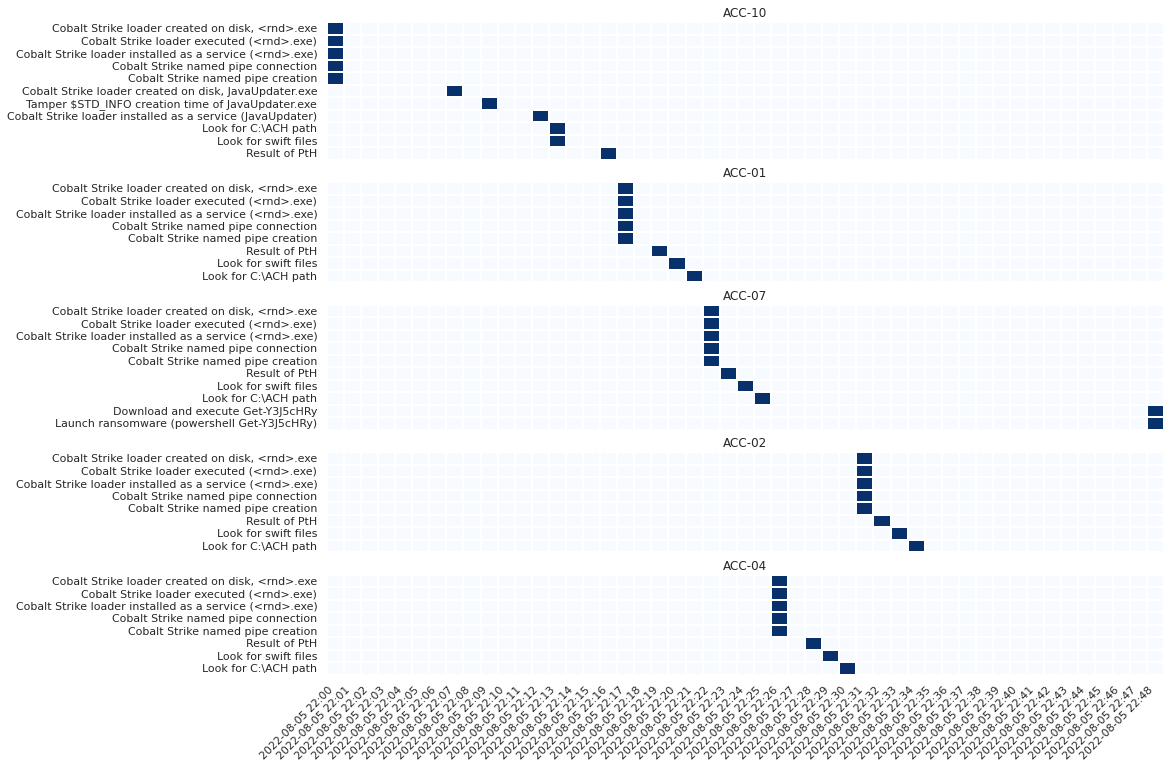

In [39]:
visualize_report_by_subject(df, 'T', (15,12), 'report_desc')

# Cobalt Strike Sacrificial Process Purposes
Before adding rundll32 executions to our report, we need to shed light on the purpose of the payloads the threat actor injected.
We will leverage Sysmon events to pivot on __ProcessId__ (pid) to recognize privilege escalation, lateral movement, credential access, and others. 

So far, we already extracted information from Sysmon EID 1 (process creation), and EID 7 (image loaded), from which we respectively built the chain of executions in __df_cobalt_processes__ and the list of loaders hashes in __df_cobalt_loaders__. 

In [40]:
df_cobalt_loaders.drop(columns=['raw']).head(2)

subject  \
datetime                            
2022-08-05 22:00:05+00:00  ACC-10   
2022-08-05 22:14:11+00:00  ACC-10   

                                                                   process_name  \
datetime                                                                          
2022-08-05 22:00:05+00:00                        \\127.0.0.1\ADMIN$\27f96ba.exe   
2022-08-05 22:14:11+00:00  C:\Program Files (x86)\Java\jre7\bin\JavaUpdater.exe   

                                                                                                  hashes  \
datetime                                                                                                   
2022-08-05 22:00:05+00:00  MD5=322C3BCA32697C473B04F8EEF068BF84,IMPHASH=DE77F3139EAF74F1B255AB7BE0B6605F   
2022-08-05 22:14:11+00:00  MD5=EB61AD33B108DED34DF7597BC0D81EFB,IMPHASH=BED5688A4A2B5EA6984115B458755E90   

                            pid  
datetime                         
2022-08-05 22:00:05+00:00  4860  
2022-08-05 22:14:11+00:00  1328

In [41]:
df_cobalt_processes.drop(columns=['raw']).head(2)

subject   pid  ppid  \
datetime                                        
2022-08-05 22:00:05+00:00  ACC-10  4860   508   
2022-08-05 22:00:06+00:00  ACC-10  1604  4860   

                                               process_name  \
datetime                                                      
2022-08-05 22:00:05+00:00    \\127.0.0.1\ADMIN$\27f96ba.exe   
2022-08-05 22:00:06+00:00  C:\Windows\SysWOW64\rundll32.exe   

                                        parent_process_name  \
datetime                                                      
2022-08-05 22:00:05+00:00  C:\Windows\System32\services.exe   
2022-08-05 22:00:06+00:00    \\127.0.0.1\ADMIN$\27f96ba.exe   

                                                    cmdline  \
datetime                                                      
2022-08-05 22:00:05+00:00    \\127.0.0.1\ADMIN$\27f96ba.exe   
2022-08-05 22:00:06+00:00  C:\Windows\System32\rundll32.exe   

                                          user  
datetime                                        
2022-08-05 22:00:05+00:00  NT AUTHORITY\SYSTEM  
2022-08-05 22:00:06+00:00  NT AUTHORITY\SYSTEM

The plan is now to collect other Sysmon events tight to the processes collected in df_cobalt_processes:
- EID 10: process access. We should catch process injection or credential dumping
- EID 17/18: as already discussed, for named pipe creation and connection
- EID 3: network connections. We should see here things like network scan, C2 and the lateral movement

In the end, we will draw all the relationships as network, which should help us understand the intent of each rundll32 executions.

In [42]:
# create the dataframe with useful info from Sysmon EID 17 and 18
f_sysmon_17_18 = df_refined['evtx_info'].isin([
    'Microsoft-Windows-Sysmon/Operational;Microsoft-Windows-Sysmon;17',
    'Microsoft-Windows-Sysmon/Operational;Microsoft-Windows-Sysmon;18',
])
df_sysmon_17_18 = df_refined.loc[f_sysmon_17_18, ['subject', 'raw']]

df_sysmon_17_18['eid'] = df_sysmon_17_18['raw'].str.extract('<EventID>([0-9]*)', expand=False)
df_sysmon_17_18['pid'] = df_sysmon_17_18['raw'].str.extract('<Data Name="ProcessId">([^<]*)</Data>', expand=False)
df_sysmon_17_18['process_name'] = df_sysmon_17_18['raw'].str.extract('<Data Name="Image">([^<]*)</Data>', expand=False)
df_sysmon_17_18['pipe_name'] = df_sysmon_17_18['raw'].str.extract('<Data Name="PipeName">([^<]*)</Data>', expand=False)

df_sysmon_17_18.drop(columns=['raw']).head()

subject eid   pid  \
datetime                                      
2022-08-05 21:42:36+00:00  ACC-10  17  3904   
2022-08-05 21:42:36+00:00  ACC-10  17  3904   
2022-08-05 21:42:36+00:00  ACC-10  18  6728   
2022-08-05 21:42:36+00:00  ACC-10  18  6728   
2022-08-05 21:49:19+00:00  ACC-10  17  2884   

                                                                    process_name  \
datetime                                                                           
2022-08-05 21:42:36+00:00  C:\Program Files (x86)\Internet Explorer\iexplore.exe   
2022-08-05 21:42:36+00:00  C:\Program Files (x86)\Internet Explorer\iexplore.exe   
2022-08-05 21:42:36+00:00          C:\Program Files (x86)\Java\jre7\bin\java.exe   
2022-08-05 21:42:36+00:00          C:\Program Files (x86)\Java\jre7\bin\java.exe   
2022-08-05 21:49:19+00:00                       C:\Windows\syswow64\rundll32.exe   

                                     pipe_name  
datetime                                        
2022-08-05 21:42:36+00:00  \jpi2_pid3904_pipe2  
2022-08-05 21:42:36+00:00  \jpi2_pid3904_pipe3  
2022-08-05 21:42:36+00:00  \jpi2_pid3904_pipe3  
2022-08-05 21:42:36+00:00  \jpi2_pid3904_pipe2  
2022-08-05 21:49:19+00:00         \postex_d2eb

In [43]:
# create the dataframe with useful info from Sysmon EID 10
f_sysmon_10 = df_refined['evtx_info'] == 'Microsoft-Windows-Sysmon/Operational;Microsoft-Windows-Sysmon;10'
df_sysmon_10 = df_refined.loc[f_sysmon_10, ['subject', 'raw']]

df_sysmon_10['eid'] = df_sysmon_10['raw'].str.extract('<EventID>([0-9]*)', expand=False)
df_sysmon_10['pid'] = df_sysmon_10['raw'].str.extract('<Data Name="SourceProcessId">([^<]*)</Data>', expand=False)
df_sysmon_10['process_name'] = df_sysmon_10['raw'].str.extract('<Data Name="SourceImage">([^<]*)</Data>', expand=False)
df_sysmon_10['process_target'] = df_sysmon_10['raw'].str.extract('<Data Name="TargetImage">([^<]*)</Data>', expand=False)


df_sysmon_10.drop(columns=['raw']).head()

subject eid   pid  \
datetime                                      
2022-08-05 21:11:10+00:00  ACC-10  10  1248   
2022-08-05 21:11:10+00:00  ACC-10  10  1248   
2022-08-05 21:11:10+00:00  ACC-10  10  1248   
2022-08-05 21:11:10+00:00  ACC-10  10  1248   
2022-08-05 21:11:13+00:00  ACC-10  10  1248   

                                                             process_name  \
datetime                                                                    
2022-08-05 21:11:10+00:00  C:\Program Files\osquery\osqueryd\osqueryd.exe   
2022-08-05 21:11:10+00:00  C:\Program Files\osquery\osqueryd\osqueryd.exe   
2022-08-05 21:11:10+00:00  C:\Program Files\osquery\osqueryd\osqueryd.exe   
2022-08-05 21:11:10+00:00  C:\Program Files\osquery\osqueryd\osqueryd.exe   
2022-08-05 21:11:13+00:00  C:\Program Files\osquery\osqueryd\osqueryd.exe   

                                             process_target  
datetime                                                     
2022-08-05 21:11:10+00:00  C:\Windows\system32\winlogon.exe  
2022-08-05 21:11:10+00:00     C:\Windows\system32\lsass.exe  
2022-08-05 21:11:10+00:00  C:\Windows\system32\winlogon.exe  
2022-08-05 21:11:10+00:00     C:\Windows\system32\lsass.exe  
2022-08-05 21:11:13+00:00  C:\Windows\system32\winlogon.exe

In [44]:
# create the dataframe with useful info from Sysmon EID 3
f_sysmon_3 = df_refined['evtx_info'] == 'Microsoft-Windows-Sysmon/Operational;Microsoft-Windows-Sysmon;3'
df_sysmon_3 = df_refined.loc[f_sysmon_3, ['subject', 'raw']]

df_sysmon_3['eid'] = df_sysmon_3['raw'].str.extract('<EventID>([0-9]*)', expand=False)
df_sysmon_3['pid'] = df_sysmon_3['raw'].str.extract('<Data Name="ProcessId">([^<]*)</Data>', expand=False)
df_sysmon_3['process_name'] = df_sysmon_3['raw'].str.extract('<Data Name="Image">([^<]*)</Data>', expand=False)
df_sysmon_3['user'] = df_sysmon_3['raw'].str.extract('<Data Name="User">([^<]*)</Data>', expand=False)
df_sysmon_3['is_src'] = df_sysmon_3['raw'].str.extract('<Data Name="Initiated">([^<]*)</Data>', expand=False)
df_sysmon_3['protocol'] = df_sysmon_3['raw'].str.extract('<Data Name="Protocol">([^<]*)</Data>', expand=False)
df_sysmon_3['src_ip'] = df_sysmon_3['raw'].str.extract('<Data Name="SourceIp">([^<]*)</Data>', expand=False)
df_sysmon_3['src_port'] = df_sysmon_3['raw'].str.extract('<Data Name="SourcePort">([^<]*)</Data>', expand=False)
df_sysmon_3['src_hostname'] = df_sysmon_3['raw'].str.extract('<Data Name="SourceHostname">([^<]*)</Data>', expand=False)
df_sysmon_3['dst_ip'] = df_sysmon_3['raw'].str.extract('<Data Name="DestinationIp">([^<]*)</Data>', expand=False)
df_sysmon_3['dst_port'] = df_sysmon_3['raw'].str.extract('<Data Name="DestinationPort">([^<]*)</Data>', expand=False)
df_sysmon_3['dst_hostname'] = df_sysmon_3['raw'].str.extract('<Data Name="DestinationHostname">([^<]*)</Data>', expand=False)
df_sysmon_3 = df_sysmon_3.fillna({
    'src_hostname': '',
    'dst_hostname': '',
})

df_sysmon_3.drop(columns=['raw']).head()

subject eid   pid            process_name  \
datetime                                                              
2022-08-05 21:11:14+00:00  ACC-10   3  3640  C:\salt\bin\python.exe   
2022-08-05 21:11:15+00:00  ACC-10   3  3640  C:\salt\bin\python.exe   
2022-08-05 21:11:17+00:00  ACC-10   3  3640  C:\salt\bin\python.exe   
2022-08-05 21:11:17+00:00  ACC-10   3  3640  C:\salt\bin\python.exe   
2022-08-05 21:11:17+00:00  ACC-10   3  3640  C:\salt\bin\python.exe   

                                          user is_src protocol     src_ip  \
datetime                                                                    
2022-08-05 21:11:14+00:00  NT AUTHORITY\SYSTEM   true      tcp  127.0.0.1   
2022-08-05 21:11:15+00:00  NT AUTHORITY\SYSTEM  false      tcp  127.0.0.1   
2022-08-05 21:11:17+00:00  NT AUTHORITY\SYSTEM   true      tcp  127.0.0.1   
2022-08-05 21:11:17+00:00  NT AUTHORITY\SYSTEM  false      tcp  127.0.0.1   
2022-08-05 21:11:17+00:00  NT AUTHORITY\SYSTEM   true      tcp  127.0.0.1   

                          src_port     src_hostname     dst_ip dst_port  \
datetime                                                                  
2022-08-05 21:11:14+00:00    54388  ACC-10.corp.net  127.0.0.1    54387   
2022-08-05 21:11:15+00:00    54387  ACC-10.corp.net  127.0.0.1    54388   
2022-08-05 21:11:17+00:00    54390  ACC-10.corp.net  127.0.0.1    54389   
2022-08-05 21:11:17+00:00    54389  ACC-10.corp.net  127.0.0.1    54390   
2022-08-05 21:11:17+00:00    54392  ACC-10.corp.net  127.0.0.1    54391   

                              dst_hostname  
datetime                                    
2022-08-05 21:11:14+00:00  ACC-10.corp.net  
2022-08-05 21:11:15+00:00  ACC-10.corp.net  
2022-08-05 21:11:17+00:00  ACC-10.corp.net  
2022-08-05 21:11:17+00:00  ACC-10.corp.net  
2022-08-05 21:11:17+00:00  ACC-10.corp.net

With these 5 __df_sysmon_\*__ dataframes, we cover process creation, process access, network connection, and named pipes. 
We also have process ID (pid) and process name (because PID's number can be reused) columns in common to pivot between all of them.

We create the list of our pivots: the tuples (subjet, PID, process name) from __df_cobalt_processes__.

In [45]:
# create the list of (subject, pid, process_name) related to Cobalt Strike
subjects = df_cobalt_processes['subject'].unique()
list_pids_names = df_cobalt_processes\
    .assign(process_name=df_cobalt_processes['process_name'].str.lower())\
    .set_index(['subject', 'pid', 'process_name'])\
    .index.drop_duplicates().tolist()

And we look for occurences of these processes in other Sysmon events: it might indicate the purpose of the process.

We start by creating a function __check_process_in__ that takes __list_pids_name__, the dataframe we search in, and a list a columns to use when deduplicating events after selection.

In [46]:
def check_processes_in(df_, processes, cols_duplicate):
    f_insights = df_\
        .assign(process_name=df_['process_name'].str.lower())\
        .set_index(['subject', 'pid', 'process_name'])\
        .index.isin(processes)
    df_insights = df_[f_insights].sort_index()
    return df_insights.drop_duplicates(subset=['subject', 'pid', 'process_name', *cols_duplicate])

## Correlations with Processes Accessed
We use this function to first check the Cobalt Strike PIDs in the dataframe of process accessed.

In [47]:
df_cobalt_access = check_processes_in(df_sysmon_10, list_pids_names, ['process_target'])
df_cobalt_access.drop(columns=['raw'])

subject eid   pid                      process_name  \
datetime                                                                        
2022-08-05 22:01:56+00:00  ACC-10  10  7012  C:\Windows\system32\rundll32.exe   
2022-08-05 22:05:58+00:00  ACC-10  10  2812  C:\Windows\system32\rundll32.exe   
2022-08-05 22:16:30+00:00  ACC-10  10   596  C:\Windows\system32\rundll32.exe   
2022-08-05 22:19:38+00:00  ACC-01  10  5884  C:\Windows\system32\rundll32.exe   
2022-08-05 22:23:45+00:00  ACC-07  10  3460  C:\Windows\system32\rundll32.exe   
2022-08-05 22:28:03+00:00  ACC-04  10  4300  C:\Windows\system32\rundll32.exe   
2022-08-05 22:32:35+00:00  ACC-02  10  2004  C:\Windows\system32\rundll32.exe   

                                          process_target  
datetime                                                  
2022-08-05 22:01:56+00:00  C:\Windows\system32\lsass.exe  
2022-08-05 22:05:58+00:00  C:\Windows\system32\lsass.exe  
2022-08-05 22:16:30+00:00  C:\Windows\system32\lsass.exe  
2022-08-05 22:19:38+00:00  C:\Windows\system32\lsass.exe  
2022-08-05 22:23:45+00:00  C:\Windows\system32\lsass.exe  
2022-08-05 22:28:03+00:00  C:\Windows\system32\lsass.exe  
2022-08-05 22:32:35+00:00  C:\Windows\system32\lsass.exe

From EID10 (process access), we learn that all the listed PIDs indicate credential dumping: the spawned sacrificial process was injected with a payload that accessed the sacrosanct LSASS service, which holds credentials hashes and tokens in memory.

We save this information in __df_cobalt_processes__, and also the events related to LSASS access in __df__.

In [48]:
# save process accessed by Cobalt Strike in df
f_access = df['raw'].isin(df_cobalt_access['raw'].tolist()) 
df.loc[f_access, 'to_keep'] = True
df.loc[f_access, 'report_desc'] = 'LSASS process accessed'
df.loc[f_access, 'mitre_tactic'] = 'Credential Access'

In [49]:
# merge the details columns from df_cobalt_access into df
df = pd.merge(df, df_cobalt_access, how='left', on=['datetime', 'subject', 'raw'])

f_access = df['raw'].isin(df_cobalt_access['raw'].tolist()) 
df.loc[f_access, ['subject', 'evtx_info', 'report_desc', 'mitre_tactic', 'pid', 'process_name', 'process_target']]

subject  \
datetime                            
2022-08-05 22:01:56+00:00  ACC-10   
2022-08-05 22:05:58+00:00  ACC-10   
2022-08-05 22:16:30+00:00  ACC-10   
2022-08-05 22:19:38+00:00  ACC-01   
2022-08-05 22:23:45+00:00  ACC-07   
2022-08-05 22:32:35+00:00  ACC-02   
2022-08-05 22:28:03+00:00  ACC-04   

                                                                                  evtx_info  \
datetime                                                                                      
2022-08-05 22:01:56+00:00  Microsoft-Windows-Sysmon/Operational;Microsoft-Windows-Sysmon;10   
2022-08-05 22:05:58+00:00  Microsoft-Windows-Sysmon/Operational;Microsoft-Windows-Sysmon;10   
2022-08-05 22:16:30+00:00  Microsoft-Windows-Sysmon/Operational;Microsoft-Windows-Sysmon;10   
2022-08-05 22:19:38+00:00  Microsoft-Windows-Sysmon/Operational;Microsoft-Windows-Sysmon;10   
2022-08-05 22:23:45+00:00  Microsoft-Windows-Sysmon/Operational;Microsoft-Windows-Sysmon;10   
2022-08-05 22:32:35+00:00  Microsoft-Windows-Sysmon/Operational;Microsoft-Windows-Sysmon;10   
2022-08-05 22:28:03+00:00  Microsoft-Windows-Sysmon/Operational;Microsoft-Windows-Sysmon;10   

                                      report_desc       mitre_tactic   pid  \
datetime                                                                     
2022-08-05 22:01:56+00:00  LSASS process accessed  Credential Access  7012   
2022-08-05 22:05:58+00:00  LSASS process accessed  Credential Access  2812   
2022-08-05 22:16:30+00:00  LSASS process accessed  Credential Access   596   
2022-08-05 22:19:38+00:00  LSASS process accessed  Credential Access  5884   
2022-08-05 22:23:45+00:00  LSASS process accessed  Credential Access  3460   
2022-08-05 22:32:35+00:00  LSASS process accessed  Credential Access  2004   
2022-08-05 22:28:03+00:00  LSASS process accessed  Credential Access  4300   

                                               process_name  \
datetime                                                      
2022-08-05 22:01:56+00:00  C:\Windows\system32\rundll32.exe   
2022-08-05 22:05:58+00:00  C:\Windows\system32\rundll32.exe   
2022-08-05 22:16:30+00:00  C:\Windows\system32\rundll32.exe   
2022-08-05 22:19:38+00:00  C:\Windows\system32\rundll32.exe   
2022-08-05 22:23:45+00:00  C:\Windows\system32\rundll32.exe   
2022-08-05 22:32:35+00:00  C:\Windows\system32\rundll32.exe   
2022-08-05 22:28:03+00:00  C:\Windows\system32\rundll32.exe   

                                          process_target  
datetime                                                  
2022-08-05 22:01:56+00:00  C:\Windows\system32\lsass.exe  
2022-08-05 22:05:58+00:00  C:\Windows\system32\lsass.exe  
2022-08-05 22:16:30+00:00  C:\Windows\system32\lsass.exe  
2022-08-05 22:19:38+00:00  C:\Windows\system32\lsass.exe  
2022-08-05 22:23:45+00:00  C:\Windows\system32\lsass.exe  
2022-08-05 22:32:35+00:00  C:\Windows\system32\lsass.exe  
2022-08-05 22:28:03+00:00  C:\Windows\system32\lsass.exe

In [50]:
# save purpose about sacrificial process in df_cobalt_processes
pids_lsass = list(set(list(zip(df_cobalt_access['subject'], df_cobalt_access['pid']))))
f_lsass = df_cobalt_processes.set_index(['subject', 'pid']).index.isin(pids_lsass)
df_cobalt_processes.loc[f_lsass, 'report_desc'] = 'Sacrificial process (rundll32) spawned to access LSASS'
df_cobalt_processes.loc[f_lsass, 'mitre_tactic'] = 'Credential Access'
df_cobalt_processes[f_lsass].drop(columns=['raw'])

subject   pid  ppid  \
datetime                                        
2022-08-05 22:01:56+00:00  ACC-10  7012  1604   
2022-08-05 22:05:57+00:00  ACC-10  2812  1604   
2022-08-05 22:16:29+00:00  ACC-10   596  1604   
2022-08-05 22:19:37+00:00  ACC-01  5884  1572   
2022-08-05 22:23:45+00:00  ACC-07  3460  3208   
2022-08-05 22:28:02+00:00  ACC-04  4300  4092   
2022-08-05 22:32:34+00:00  ACC-02  2004  4776   

                                               process_name  \
datetime                                                      
2022-08-05 22:01:56+00:00  C:\Windows\System32\rundll32.exe   
2022-08-05 22:05:57+00:00  C:\Windows\System32\rundll32.exe   
2022-08-05 22:16:29+00:00  C:\Windows\System32\rundll32.exe   
2022-08-05 22:19:37+00:00  C:\Windows\System32\rundll32.exe   
2022-08-05 22:23:45+00:00  C:\Windows\System32\rundll32.exe   
2022-08-05 22:28:02+00:00  C:\Windows\System32\rundll32.exe   
2022-08-05 22:32:34+00:00  C:\Windows\System32\rundll32.exe   

                                        parent_process_name  \
datetime                                                      
2022-08-05 22:01:56+00:00  C:\Windows\SysWOW64\rundll32.exe   
2022-08-05 22:05:57+00:00  C:\Windows\SysWOW64\rundll32.exe   
2022-08-05 22:16:29+00:00  C:\Windows\SysWOW64\rundll32.exe   
2022-08-05 22:19:37+00:00  C:\Windows\SysWOW64\rundll32.exe   
2022-08-05 22:23:45+00:00  C:\Windows\SysWOW64\rundll32.exe   
2022-08-05 22:28:02+00:00  C:\Windows\SysWOW64\rundll32.exe   
2022-08-05 22:32:34+00:00  C:\Windows\SysWOW64\rundll32.exe   

                                                     cmdline  \
datetime                                                       
2022-08-05 22:01:56+00:00  C:\Windows\sysnative\rundll32.exe   
2022-08-05 22:05:57+00:00  C:\Windows\sysnative\rundll32.exe   
2022-08-05 22:16:29+00:00  C:\Windows\sysnative\rundll32.exe   
2022-08-05 22:19:37+00:00  C:\Windows\sysnative\rundll32.exe   
2022-08-05 22:23:45+00:00  C:\Windows\sysnative\rundll32.exe   
2022-08-05 22:28:02+00:00  C:\Windows\sysnative\rundll32.exe   
2022-08-05 22:32:34+00:00  C:\Windows\sysnative\rundll32.exe   

                                          user  \
datetime                                         
2022-08-05 22:01:56+00:00  NT AUTHORITY\SYSTEM   
2022-08-05 22:05:57+00:00  NT AUTHORITY\SYSTEM   
2022-08-05 22:16:29+00:00  NT AUTHORITY\SYSTEM   
2022-08-05 22:19:37+00:00  NT AUTHORITY\SYSTEM   
2022-08-05 22:23:45+00:00  NT AUTHORITY\SYSTEM   
2022-08-05 22:28:02+00:00  NT AUTHORITY\SYSTEM   
2022-08-05 22:32:34+00:00  NT AUTHORITY\SYSTEM   

                                                                      report_desc  \
datetime                                                                            
2022-08-05 22:01:56+00:00  Sacrificial process (rundll32) spawned to access LSASS   
2022-08-05 22:05:57+00:00  Sacrificial process (rundll32) spawned to access LSASS   
2022-08-05 22:16:29+00:00  Sacrificial process (rundll32) spawned to access LSASS   
2022-08-05 22:19:37+00:00  Sacrificial process (rundll32) spawned to access LSASS   
2022-08-05 22:23:45+00:00  Sacrificial process (rundll32) spawned to access LSASS   
2022-08-05 22:28:02+00:00  Sacrificial process (rundll32) spawned to access LSASS   
2022-08-05 22:32:34+00:00  Sacrificial process (rundll32) spawned to access LSASS   

                                mitre_tactic  
datetime                                      
2022-08-05 22:01:56+00:00  Credential Access  
2022-08-05 22:05:57+00:00  Credential Access  
2022-08-05 22:16:29+00:00  Credential Access  
2022-08-05 22:19:37+00:00  Credential Access  
2022-08-05 22:23:45+00:00  Credential Access  
2022-08-05 22:28:02+00:00  Credential Access  
2022-08-05 22:32:34+00:00  Credential Access

In [51]:
answers['other'].append('LSASS dumped using CS on all subjects')

## Correlations with Pipe Creations and Connections
We perform the same analysis on pipes (EID 17/18). 
This time, it will not point the purpose of the injected payload, but will highlight the inter-process communication.

In [52]:
df_cobalt_pipes = check_processes_in(df_sysmon_17_18, list_pids_names, ['eid', 'pipe_name'])
print(len(df_cobalt_pipes.index))
df_cobalt_pipes.drop(columns=['raw']).head(6)

49


subject eid   pid                      process_name  \
datetime                                                                        
2022-08-05 22:00:05+00:00  ACC-10  17  4860    \\127.0.0.1\ADMIN$\27f96ba.exe   
2022-08-05 22:00:06+00:00  ACC-10  18  4860    \\127.0.0.1\ADMIN$\27f96ba.exe   
2022-08-05 22:01:56+00:00  ACC-10  17  7012  C:\Windows\system32\rundll32.exe   
2022-08-05 22:01:56+00:00  ACC-10  18  1604  C:\Windows\SysWOW64\rundll32.exe   
2022-08-05 22:05:57+00:00  ACC-10  17  2812  C:\Windows\system32\rundll32.exe   
2022-08-05 22:05:58+00:00  ACC-10  18  1604  C:\Windows\SysWOW64\rundll32.exe   

                                   pipe_name  
datetime                                      
2022-08-05 22:00:05+00:00  \MSSE-9609-server  
2022-08-05 22:00:06+00:00  \MSSE-9609-server  
2022-08-05 22:01:56+00:00       \postex_d71e  
2022-08-05 22:01:56+00:00       \postex_d71e  
2022-08-05 22:05:57+00:00       \postex_72a1  
2022-08-05 22:05:58+00:00       \postex_72a1

We have 49 pipe creation/connection pertaining to the Cobalt Strike payloads: a table is not the best visualization to figure out the relation between creation and connection. 
For instance,
- __postex_d71e__ is created by PID 7012 on subject ACC-10, and PID 1604 connect to it
- __postex_72a1__ is created by PID 2812 on subject ACC-10, and PID 1604 connect to it

For the moment, we save these events in __df__. 
We will later reuse __df_colbalt_\*__ all together to draw the relations.

In [53]:
# save the named pipes creations and connections related to Cobalt Strike to df
f_pipes = df['raw'].isin(df_cobalt_pipes['raw'].tolist()) 
df.loc[f_pipes, 'to_keep'] = True

f_pipe = df['evtx_info'] == 'Microsoft-Windows-Sysmon/Operational;Microsoft-Windows-Sysmon;17'
df.loc[f_pipes & f_pipe, 'to_keep'] = True
df.loc[f_pipes & f_pipe, 'report_desc'] = 'Cobalt Strike named pipe creation'
df.loc[f_pipes & f_pipe, 'mitre_tactic'] = 'Execution'

f_pipe = df['evtx_info'] == 'Microsoft-Windows-Sysmon/Operational;Microsoft-Windows-Sysmon;18'
df.loc[f_pipes & f_pipe, 'to_keep'] = True
df.loc[f_pipes & f_pipe, 'report_desc'] = 'Cobalt Strike named pipe connection'
df.loc[f_pipes & f_pipe, 'mitre_tactic'] = 'Execution'

In [54]:
# merge the details columns from df_cobalt_pipes into df
df = df.set_index(['subject', 'raw'], append=True)\
    .combine_first(df_cobalt_pipes.set_index(['subject', 'raw'], append=True))\
    .reset_index(level=[1,2])

f_pipes = df['raw'].isin(df_cobalt_pipes['raw'].tolist()) 
df.loc[f_pipes, ['subject', 'source', 'report_desc', 'mitre_tactic', 'pid', 'process_name', 'pipe_name']].head()

subject                                     source  \
datetime                                                                       
2022-08-05 22:00:05+00:00  ACC-10  evtx_Microsoft-Windows-Sysmon/Operational   
2022-08-05 22:00:06+00:00  ACC-10  evtx_Microsoft-Windows-Sysmon/Operational   
2022-08-05 22:01:56+00:00  ACC-10  evtx_Microsoft-Windows-Sysmon/Operational   
2022-08-05 22:01:56+00:00  ACC-10  evtx_Microsoft-Windows-Sysmon/Operational   
2022-08-05 22:05:57+00:00  ACC-10  evtx_Microsoft-Windows-Sysmon/Operational   

                                                   report_desc mitre_tactic  \
datetime                                                                      
2022-08-05 22:00:05+00:00    Cobalt Strike named pipe creation    Execution   
2022-08-05 22:00:06+00:00  Cobalt Strike named pipe connection    Execution   
2022-08-05 22:01:56+00:00    Cobalt Strike named pipe creation    Execution   
2022-08-05 22:01:56+00:00  Cobalt Strike named pipe connection    Execution   
2022-08-05 22:05:57+00:00    Cobalt Strike named pipe creation    Execution   

                            pid                      process_name  \
datetime                                                            
2022-08-05 22:00:05+00:00  4860    \\127.0.0.1\ADMIN$\27f96ba.exe   
2022-08-05 22:00:06+00:00  4860    \\127.0.0.1\ADMIN$\27f96ba.exe   
2022-08-05 22:01:56+00:00  7012  C:\Windows\system32\rundll32.exe   
2022-08-05 22:01:56+00:00  1604  C:\Windows\SysWOW64\rundll32.exe   
2022-08-05 22:05:57+00:00  2812  C:\Windows\system32\rundll32.exe   

                                   pipe_name  
datetime                                      
2022-08-05 22:00:05+00:00  \MSSE-9609-server  
2022-08-05 22:00:06+00:00  \MSSE-9609-server  
2022-08-05 22:01:56+00:00       \postex_d71e  
2022-08-05 22:01:56+00:00       \postex_d71e  
2022-08-05 22:05:57+00:00       \postex_72a1

## Correlation with Network Connections
Lastly, we analyze the network connections (Sysmon EID 3) to identify lateral movements.

In [55]:
df_cobalt_network = check_processes_in(
    df_sysmon_3, list_pids_names,
    ['protocol', 'src_ip', 'src_port', 'dst_ip', 'dst_port']
)

df_cobalt_network.drop(columns=['raw', 'user'])

subject eid   pid  \
datetime                                      
2022-08-05 22:17:31+00:00  ACC-10   3  1604   
2022-08-05 22:17:31+00:00  ACC-10   3  1604   
2022-08-05 22:22:18+00:00  ACC-01   3  1572   
2022-08-05 22:22:18+00:00  ACC-01   3  1572   
2022-08-05 22:26:32+00:00  ACC-07   3  3208   
2022-08-05 22:26:32+00:00  ACC-07   3  3208   
2022-08-05 22:31:39+00:00  ACC-04   3  4092   
2022-08-05 22:31:39+00:00  ACC-04   3  4092   
2022-08-05 22:35:03+00:00  ACC-02   3  4776   
2022-08-05 22:35:03+00:00  ACC-02   3  4776   
2022-08-05 22:48:48+00:00  ACC-07   3  5148   
2022-08-05 22:48:48+00:00  ACC-07   3  3208   

                                                                        process_name  \
datetime                                                                               
2022-08-05 22:17:31+00:00                           C:\Windows\SysWOW64\rundll32.exe   
2022-08-05 22:17:31+00:00                           C:\Windows\SysWOW64\rundll32.exe   
2022-08-05 22:22:18+00:00                           C:\Windows\SysWOW64\rundll32.exe   
2022-08-05 22:22:18+00:00                           C:\Windows\SysWOW64\rundll32.exe   
2022-08-05 22:26:32+00:00                           C:\Windows\SysWOW64\rundll32.exe   
2022-08-05 22:26:32+00:00                           C:\Windows\SysWOW64\rundll32.exe   
2022-08-05 22:31:39+00:00                           C:\Windows\SysWOW64\rundll32.exe   
2022-08-05 22:31:39+00:00                           C:\Windows\SysWOW64\rundll32.exe   
2022-08-05 22:35:03+00:00                           C:\Windows\SysWOW64\rundll32.exe   
2022-08-05 22:35:03+00:00                           C:\Windows\SysWOW64\rundll32.exe   
2022-08-05 22:48:48+00:00  C:\Windows\System32\WindowsPowerShell\v1.0\powershell.exe   
2022-08-05 22:48:48+00:00                           C:\Windows\SysWOW64\rundll32.exe   

                          is_src protocol         src_ip src_port  \
datetime                                                            
2022-08-05 22:17:31+00:00   true      tcp  172.17.11.184    55313   
2022-08-05 22:17:31+00:00   true      tcp  172.17.11.184    55314   
2022-08-05 22:22:18+00:00   true      tcp  172.17.11.209    58605   
2022-08-05 22:22:18+00:00   true      tcp  172.17.11.209    58606   
2022-08-05 22:26:32+00:00   true      tcp  172.17.11.190    59177   
2022-08-05 22:26:32+00:00   true      tcp  172.17.11.190    59178   
2022-08-05 22:31:39+00:00   true      tcp  172.17.11.195    61959   
2022-08-05 22:31:39+00:00   true      tcp  172.17.11.195    61960   
2022-08-05 22:35:03+00:00   true      tcp  172.17.11.185    61253   
2022-08-05 22:35:03+00:00   true      tcp  172.17.11.185    61254   
2022-08-05 22:48:48+00:00   true      tcp      127.0.0.1    60310   
2022-08-05 22:48:48+00:00  false      tcp      127.0.0.1    59886   

                              src_hostname         dst_ip dst_port  \
datetime                                                             
2022-08-05 22:17:31+00:00  ACC-10.corp.net  172.17.11.209      135   
2022-08-05 22:17:31+00:00  ACC-10.corp.net  172.17.11.209    49181   
2022-08-05 22:22:18+00:00  ACC-01.corp.net  172.17.11.190      135   
2022-08-05 22:22:18+00:00  ACC-01.corp.net  172.17.11.190    49181   
2022-08-05 22:26:32+00:00  ACC-07.corp.net  172.17.11.195      135   
2022-08-05 22:26:32+00:00  ACC-07.corp.net  172.17.11.195    49155   
2022-08-05 22:31:39+00:00  ACC-04.corp.net  172.17.11.185      135   
2022-08-05 22:31:39+00:00  ACC-04.corp.net  172.17.11.185    49183   
2022-08-05 22:35:03+00:00  ACC-02.corp.net  172.17.11.171      135   
2022-08-05 22:35:03+00:00  ACC-02.corp.net  172.17.11.171    49182   
2022-08-05 22:48:48+00:00  ACC-07.corp.net      127.0.0.1    59886   
2022-08-05 22:48:48+00:00  ACC-07.corp.net      127.0.0.1    60310   

                              dst_hostname  
datetime                                    
2022-08-05 22:17:31+00:00           ACC-01  
2022-08-05 22:17:31+00:00           ACC-01  
2022-0

We notice an interaction on ACC-07 between powershell and the sacrificial process (the last 2 linesof the table). 
Checking our saved answers, 127.0.0.1:59886 is exactly the execution of powershell that downloads then execute the ransomware. 
We learn here that the purpose of rundll32 PID 3208 on subject ACC-07 is to serve the ransomware.

We also suspect the lateral movements: 
- the order: ACC-10 -> ACC-01 -> ACC-07 -> ACC-04 -> ACC-02 -> ACC-03,
- the pattern: destination TCP 135 (to initiate a RPC call) followed by a TCP ephemeral port(in the range 1024–65535). This indicates a DCOM-based method to execute payload remotely

Still in the network connections, we validate the lateral movements by checking which processes handle these connections on the destination subject.

In [56]:
lateral = list(set(list(zip(
    df_cobalt_network['dst_hostname'],
    df_cobalt_network['dst_ip'], df_cobalt_network['dst_port'],
    df_cobalt_network['src_ip'], df_cobalt_network['src_port'],
))))
f_lateral = df_sysmon_3.set_index(['subject', 'src_ip', 'src_port', 'dst_ip', 'dst_port'])\
    .index.isin(lateral)
df_sysmon_3[f_lateral].drop(columns=['raw', 'user'])

subject eid  pid                      process_name  \
datetime                                                                       
2022-08-05 22:17:31+00:00  ACC-01   3  692   C:\Windows\System32\svchost.exe   
2022-08-05 22:17:31+00:00  ACC-01   3  476  C:\Windows\System32\services.exe   
2022-08-05 22:22:18+00:00  ACC-07   3  684   C:\Windows\System32\svchost.exe   
2022-08-05 22:22:18+00:00  ACC-07   3  464  C:\Windows\System32\services.exe   
2022-08-05 22:31:36+00:00  ACC-02   3  696   C:\Windows\System32\svchost.exe   
2022-08-05 22:31:36+00:00  ACC-02   3  500  C:\Windows\System32\services.exe   
2022-08-05 22:26:28+00:00  ACC-04   3  704   C:\Windows\System32\svchost.exe   
2022-08-05 22:26:28+00:00  ACC-04   3  484  C:\Windows\System32\services.exe   

                          is_src protocol         src_ip src_port  \
datetime                                                            
2022-08-05 22:17:31+00:00  false      tcp  172.17.11.209      135   
2022-08-05 22:17:31+00:00  false      tcp  172.17.11.209    49181   
2022-08-05 22:22:18+00:00  false      tcp  172.17.11.190      135   
2022-08-05 22:22:18+00:00  false      tcp  172.17.11.190    49181   
2022-08-05 22:31:36+00:00  false      tcp  172.17.11.185      135   
2022-08-05 22:31:36+00:00  false      tcp  172.17.11.185    49183   
2022-08-05 22:26:28+00:00  false      tcp  172.17.11.195      135   
2022-08-05 22:26:28+00:00  false      tcp  172.17.11.195    49155   

                              src_hostname         dst_ip dst_port  \
datetime                                                             
2022-08-05 22:17:31+00:00  ACC-01.corp.net  172.17.11.184    55313   
2022-08-05 22:17:31+00:00  ACC-01.corp.net  172.17.11.184    55314   
2022-08-05 22:22:18+00:00  ACC-07.corp.net  172.17.11.209    58605   
2022-08-05 22:22:18+00:00  ACC-07.corp.net  172.17.11.209    58606   
2022-08-05 22:31:36+00:00  ACC-02.corp.net  172.17.11.195    61959   
2022-08-05 22:31:36+00:00  ACC-02.corp.net  172.17.11.195    61960   
2022-08-05 22:26:28+00:00  ACC-04.corp.net  172.17.11.190    59177   
2022-08-05 22:26:28+00:00  ACC-04.corp.net  172.17.11.190    59178   

                          dst_hostname  
datetime                                
2022-08-05 22:17:31+00:00       ACC-10  
2022-08-05 22:17:31+00:00       ACC-10  
2022-08-05 22:22:18+00:00       ACC-01  
2022-08-05 22:22:18+00:00       ACC-01  
2022-08-05 22:31:36+00:00       ACC-04  
2022-08-05 22:31:36+00:00       ACC-04  
2022-08-05 22:26:28+00:00       ACC-07  
2022-08-05 22:26:28+00:00       ACC-07

Nice, we have the definite evidences that these connections are the lateral movement: the PIDs of services.exe are exactly the ones that installed Cobalt Strike loader __\<rnd\>.exe__ as a service. 
We add these rows to __df_coblat_network__. 

In [57]:
df_cobalt_network = pd.concat([df_cobalt_network, df_sysmon_3[f_lateral]]).drop_duplicates().sort_index()
df_cobalt_network.drop(columns=['raw', 'user']).head()

subject eid   pid                      process_name  \
datetime                                                                        
2022-08-05 22:17:31+00:00  ACC-10   3  1604  C:\Windows\SysWOW64\rundll32.exe   
2022-08-05 22:17:31+00:00  ACC-10   3  1604  C:\Windows\SysWOW64\rundll32.exe   
2022-08-05 22:17:31+00:00  ACC-01   3   476  C:\Windows\System32\services.exe   
2022-08-05 22:17:31+00:00  ACC-01   3   692   C:\Windows\System32\svchost.exe   
2022-08-05 22:22:18+00:00  ACC-01   3  1572  C:\Windows\SysWOW64\rundll32.exe   

                          is_src protocol         src_ip src_port  \
datetime                                                            
2022-08-05 22:17:31+00:00   true      tcp  172.17.11.184    55313   
2022-08-05 22:17:31+00:00   true      tcp  172.17.11.184    55314   
2022-08-05 22:17:31+00:00  false      tcp  172.17.11.209    49181   
2022-08-05 22:17:31+00:00  false      tcp  172.17.11.209      135   
2022-08-05 22:22:18+00:00   true      tcp  172.17.11.209    58605   

                              src_hostname         dst_ip dst_port  \
datetime                                                             
2022-08-05 22:17:31+00:00  ACC-10.corp.net  172.17.11.209      135   
2022-08-05 22:17:31+00:00  ACC-10.corp.net  172.17.11.209    49181   
2022-08-05 22:17:31+00:00  ACC-01.corp.net  172.17.11.184    55314   
2022-08-05 22:17:31+00:00  ACC-01.corp.net  172.17.11.184    55313   
2022-08-05 22:22:18+00:00  ACC-01.corp.net  172.17.11.190      135   

                          dst_hostname  
datetime                                
2022-08-05 22:17:31+00:00       ACC-01  
2022-08-05 22:17:31+00:00       ACC-01  
2022-08-05 22:17:31+00:00       ACC-10  
2022-08-05 22:17:31+00:00       ACC-10  
2022-08-05 22:22:18+00:00       ACC-07

And we assign the uncovered purposes of these processes in __df_cobalt_processes__, as well as save the network connections in __df__

In [58]:
answers['lateral_movement'].extend([
    'chain: ACC-10 > ACC-01 > ACC-07 > ACC-04 > ACC-02 > ACC-03',
    'method: DCOM-based (TCP135 + TCP ephemeral)',
    'PID3208 sacrificial process on ACC-07 serves the ransomware on port 59886',
])

In [59]:
# save network connections performed by Cobalt Strike processes in df
f_network = df['raw'].isin(df_cobalt_network['raw'].tolist()) 
df.loc[f_network, 'to_keep'] = True

df.loc[f_network, 'report_desc'] = 'Network connection to another subject'
df.loc[f_network, 'mitre_tactic'] = 'Lateral Movement'

f_download = df['raw'].str.contains('Port">59886</Data>', regex=False)
df.loc[f_network & f_download, 'report_desc'] = 'Network connection to download ransomware'
df.loc[f_network & f_download, 'mitre_tactic'] = 'Resource Development'

In [60]:
# merge the details columns from df_cobalt_network into df
df = df.set_index(['subject', 'raw'], append=True)\
    .combine_first(df_cobalt_network.set_index(['subject', 'raw'], append=True))\
    .reset_index(level=[1,2])

f_network = df['raw'].isin(df_cobalt_network['raw'].tolist()) 
columns = [
    'subject', 'source', 'report_desc', 'mitre_tactic', 
    'pid', 'process_name', 'protocol', 'is_src', 'src_ip', 'src_port', 'dst_ip', 'dst_port'
]
df.loc[f_network, columns].head()

subject                                     source  \
datetime                                                                       
2022-08-05 22:17:31+00:00  ACC-01  evtx_Microsoft-Windows-Sysmon/Operational   
2022-08-05 22:17:31+00:00  ACC-01  evtx_Microsoft-Windows-Sysmon/Operational   
2022-08-05 22:17:31+00:00  ACC-10  evtx_Microsoft-Windows-Sysmon/Operational   
2022-08-05 22:17:31+00:00  ACC-10  evtx_Microsoft-Windows-Sysmon/Operational   
2022-08-05 22:22:18+00:00  ACC-01  evtx_Microsoft-Windows-Sysmon/Operational   

                                                     report_desc  \
datetime                                                           
2022-08-05 22:17:31+00:00  Network connection to another subject   
2022-08-05 22:17:31+00:00  Network connection to another subject   
2022-08-05 22:17:31+00:00  Network connection to another subject   
2022-08-05 22:17:31+00:00  Network connection to another subject   
2022-08-05 22:22:18+00:00  Network connection to another subject   

                               mitre_tactic   pid  \
datetime                                            
2022-08-05 22:17:31+00:00  Lateral Movement   692   
2022-08-05 22:17:31+00:00  Lateral Movement   476   
2022-08-05 22:17:31+00:00  Lateral Movement  1604   
2022-08-05 22:17:31+00:00  Lateral Movement  1604   
2022-08-05 22:22:18+00:00  Lateral Movement  1572   

                                               process_name protocol is_src  \
datetime                                                                      
2022-08-05 22:17:31+00:00   C:\Windows\System32\svchost.exe      tcp  false   
2022-08-05 22:17:31+00:00  C:\Windows\System32\services.exe      tcp  false   
2022-08-05 22:17:31+00:00  C:\Windows\SysWOW64\rundll32.exe      tcp   true   
2022-08-05 22:17:31+00:00  C:\Windows\SysWOW64\rundll32.exe      tcp   true   
2022-08-05 22:22:18+00:00  C:\Windows\SysWOW64\rundll32.exe      tcp   true   

                                  src_ip src_port         dst_ip dst_port  
datetime                                                                   
2022-08-05 22:17:31+00:00  172.17.11.209      135  172.17.11.184    55313  
2022-08-05 22:17:31+00:00  172.17.11.209    49181  172.17.11.184    55314  
2022-08-05 22:17:31+00:00  172.17.11.184    55313  172.17.11.209      135  
2022-08-05 22:17:31+00:00  172.17.11.184    55314  172.17.11.209    49181  
2022-08-05 22:22:18+00:00  172.17.11.209    58605  172.17.11.190      135

In [61]:
# save the processes that perform the lateral movements in df_cobalt_processes
f_lateral = df_cobalt_network['dst_port'] == '135'
pids_lateral = list(set(list(zip(df_cobalt_network.loc[f_lateral, 'subject'], df_cobalt_network.loc[f_lateral, 'pid']))))
f_lateral = df_cobalt_processes.set_index(['subject', 'pid']).index.isin(pids_lateral)
df_cobalt_processes.loc[f_lateral, 'report_desc'] = 'Sacrificial process (rundll32) spawned to move laterally'
df_cobalt_processes.loc[f_lateral, 'mitre_tactic'] = 'Lateral Movement'

# save the process that exposes the ransomware in df_cobalt_processes
f_subject = df_cobalt_processes['subject'] == 'ACC-07'
f_pid = df_cobalt_processes['pid'] == '3208'

df_cobalt_processes.loc[f_subject & f_pid, 'report_desc'] += '+ Expose TCP 59886 to download the ransomware'
df_cobalt_processes.loc[f_subject & f_pid, 'mitre_tactic'] = 'Lateral Movement'

## Integrate Sacrificial Processes in Main Dataframe
We first verify that we identified the purpose of the sacrificial process, other words, that __df_cobalt_processes__ is complete.

In [62]:
# list remaining sacrificial process whose purpose is not yet identified
f_unidentified = df_cobalt_processes['report_desc'].isna()
f_rundll32 = df_cobalt_processes['process_name'].str.contains('rundll32')
df_cobalt_processes.loc[f_unidentified & f_rundll32, ['subject', 'ppid', 'pid', 'process_name','report_desc']]


Empty DataFrame
Columns: [subject, ppid, pid, process_name, report_desc]
Index: []

Like for process accessed, named pipes and network connections, we now merge the detailed information from __df_cobalt_processes__ into __df__.

In [63]:
# merge the details columns from df_cobalt_network into df
df = df.set_index(['subject', 'raw'], append=True)\
    .combine_first(df_cobalt_processes.set_index(['subject', 'raw'], append=True))\
    .reset_index(level=[1,2])

f_processes = df['raw'].isin(df_cobalt_processes['raw'].tolist()) 
df.loc[f_processes, ['subject', 'report_desc', 'mitre_tactic', 'pid', 'ppid', 'user', 'process_name', 'cmdline']].head()

subject  \
datetime                            
2022-08-05 22:00:05+00:00  ACC-10   
2022-08-05 22:00:06+00:00  ACC-10   
2022-08-05 22:01:56+00:00  ACC-10   
2022-08-05 22:05:57+00:00  ACC-10   
2022-08-05 22:12:18+00:00  ACC-10   

                                                                         report_desc  \
datetime                                                                               
2022-08-05 22:00:05+00:00                  Cobalt Strike loader executed (<rnd>.exe)   
2022-08-05 22:00:06+00:00                  Cobalt Strike loader executed (<rnd>.exe)   
2022-08-05 22:01:56+00:00     Sacrificial process (rundll32) spawned to access LSASS   
2022-08-05 22:05:57+00:00     Sacrificial process (rundll32) spawned to access LSASS   
2022-08-05 22:12:18+00:00  Cobalt Strike loader installed as a service (JavaUpdater)   

                                mitre_tactic   pid  ppid                 user  \
datetime                                                                        
2022-08-05 22:00:05+00:00          Execution  4860   508  NT AUTHORITY\SYSTEM   
2022-08-05 22:00:06+00:00          Execution  1604  4860  NT AUTHORITY\SYSTEM   
2022-08-05 22:01:56+00:00  Credential Access  7012  1604  NT AUTHORITY\SYSTEM   
2022-08-05 22:05:57+00:00  Credential Access  2812  1604  NT AUTHORITY\SYSTEM   
2022-08-05 22:12:18+00:00        Persistence  4324  1604  NT AUTHORITY\SYSTEM   

                                               process_name  \
datetime                                                      
2022-08-05 22:00:05+00:00    \\127.0.0.1\ADMIN$\27f96ba.exe   
2022-08-05 22:00:06+00:00  C:\Windows\SysWOW64\rundll32.exe   
2022-08-05 22:01:56+00:00  C:\Windows\System32\rundll32.exe   
2022-08-05 22:05:57+00:00  C:\Windows\System32\rundll32.exe   
2022-08-05 22:12:18+00:00       C:\Windows\SysWOW64\cmd.exe   

                                                                                                                                                                                cmdline  
datetime                                                                                                                                                                                 
2022-08-05 22:00:05+00:00                                                                                                                                \\127.0.0.1\ADMIN$\27f96ba.exe  
2022-08-05 22:00:06+00:00                                                                                                                              C:\Windows\System32\rundll32.exe  
2022-08-05 22:01:56+00:00                                                                                                                             C:\Windows\sysnative\rundll32.exe  
2022-08-05 22:05:57+00:00                                                                                                                             C:\Windows\sysnative\rundll32.exe  
2022-08-05 22:12:18+00:00  C:\Windows\system32\cmd.exe /C sc create JavaUpdater binPath= "C:\Program Files (x86)\Java\jre7\bin\JavaUpdater.exe" start= auto DisplayName= "Java Updater"

# Taking a Step Back
Let figure out what we learned so far. 
Our main dataframe __df__ contains all important events, with the raw to illustrate to conclusion we drew from. 
The table is useful to prove our results, but does not help to get the current picture of the interactions. 
Once again, we use graphs to achieve this goal:
- to visualize our conclusion along the time
- to visualize the threat actor tactics along the time
- to visualize the lateral movements and threat actor doings

In [64]:
display_answers(answers)

category  \
0           patient0   
1        persistence   
2        persistence   
3        persistence   
4   lateral_movement   
5   lateral_movement   
6   lateral_movement   
7              other   
8              other   
9              other   
10             other   
11             other   
12             other   
13             other   
14             other   
15             other   

                                                                                             description  
0                                  ACC-10 (first cobalt installation and execution at 22h00 + 127.0.0.1)  
1     Cobalt loader installed as a service (27f96ba.exe,b8a3848.exe,4e6964b.exe,b9b362b.exe,42f7d05.exe)  
2                                Cobalt loaders <rnd>.exe: same IMPHASH=DE77F3139EAF74F1B255AB7BE0B6605F  
3                                                other CS loader installed as a service: JavaUpdater.exe  
4                                             chain: ACC-10 > ACC-01 > ACC-07 > ACC-04 > ACC-02 > ACC-03  
5                                                            method: DCOM-based (TCP135 + TCP ephemeral)  
6                              PID3208 sacrificial process on ACC-07 serves the ransomware on port 59886  
7                                                  CS sacrificial process: rundll32.exe (64 and 32 bits)  
8                                  other CS Loader JavaUpdater: IMPHASH=BED5688A4A2B5EA6984115B458755E90  
9                                               download from 127.0.0.1:59886 then executes Get-Y3J5cHRy  
10                                                               Search for filenames containing "swift"  
11                                                                                 Test if C:\ACH exists  
12                                     powershell Get-Y3J5cHRy: ransomware (random AES256 key generated)  
13                             ransomware output: .HERMES extension, ransom note=DECRYPT_INFORMATION.txt  
14  ransomware identifiers: bitcoin addr 13AM4VW2dhxYgXeQepoHkHSQuy6NgaEb94, email wangchung01@gmail.com  
15                                                                 LSASS dumped using CS on all subjects

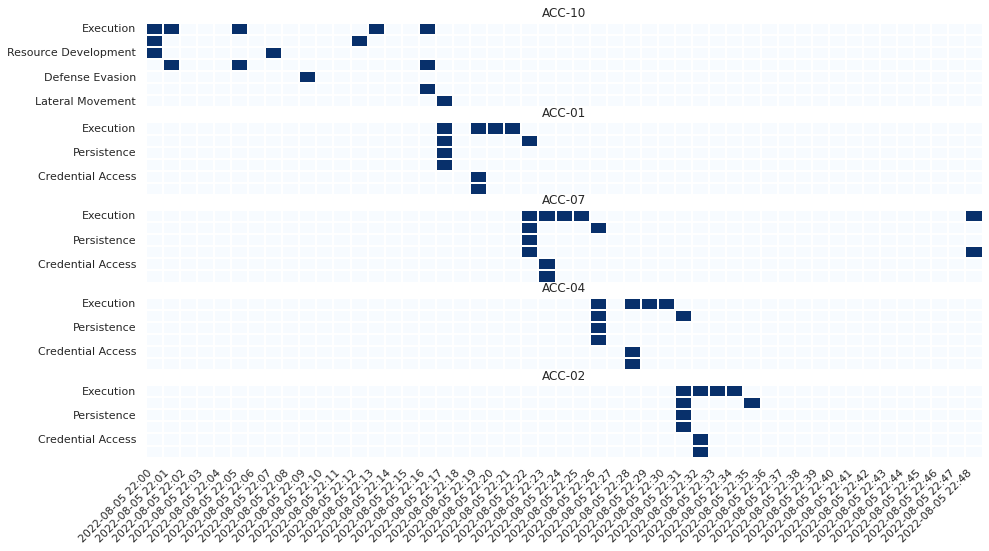

In [65]:
visualize_report_by_subject(df, 'T', (15, 8), 'mitre_tactic')

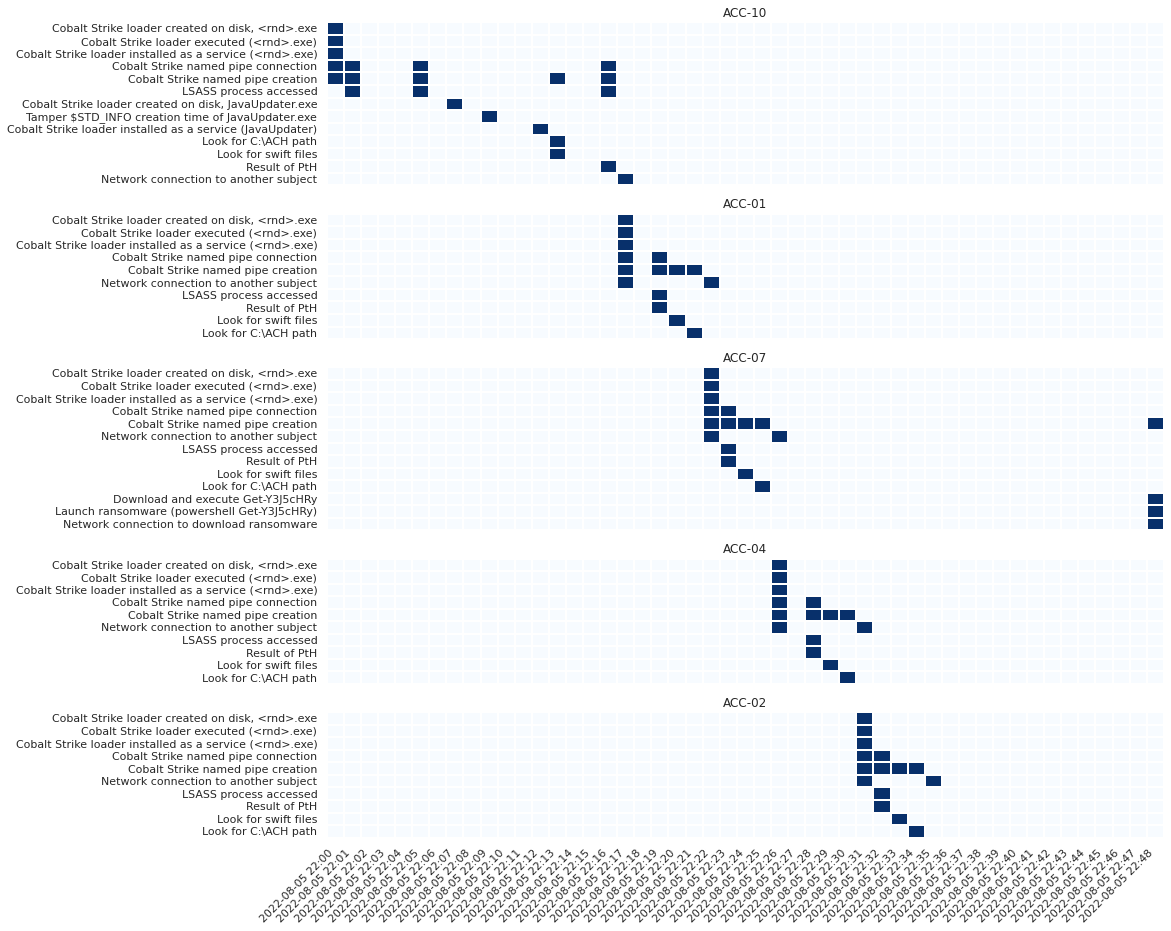

In [66]:
visualize_report_by_subject(df, 'T', (15,15), 'report_desc')

As said earlier, tables are not the best to visualize the interactions between beacon and sacrificial processes, or those between subjects. 
We use our dataframes __df_cobalt_\*__ (process started/accessed, pipes and network) to build a comprehensive network graph of the executions.

The nodes are a __process__ (process name or process target), or a __named pipe__, or __(IP, port)__ for a connection.  
The edges are the action performed: __spawn__ or __access__ between to process, __create/join__ from a process to a named pipe, or __connect__ from a process to a (hostname, IP, port).

In [67]:
def display_graph(G):
    imgbuf = BytesIO()
    G.draw(imgbuf, format='png', prog='dot')
    img = Image(imgbuf.getvalue())
    display(img)

In [68]:
def get_graph_elements_from_dataframes(df_processes, df_accesses, df_pipes, df_network):
    processes = df_processes\
        .assign(process_name=df_processes['process_name'].apply(lambda x: x.split('\\')[-1]))\
        .assign(parent_process_name=df_processes['parent_process_name'].apply(lambda x: x.split('\\')[-1]))\
        .set_index(['subject', 'pid', 'process_name', 'ppid', 'parent_process_name'])\
        .index.drop_duplicates().tolist()

    accesses = df_accesses\
        .assign(process_name=df_accesses['process_name'].apply(lambda x: x.split('\\')[-1]))\
        .assign(process_target=df_accesses['process_target'].apply(lambda x: x.split('\\')[-1]))\
        .set_index(['subject', 'pid', 'process_name', 'process_target'])\
        .index.drop_duplicates().tolist()

    pipes = df_pipes\
        .assign(process_name=df_pipes['process_name'].apply(lambda x: x.split('\\')[-1]))\
        .set_index(['subject', 'pid', 'process_name', 'eid', 'pipe_name'])\
        .index.drop_duplicates().tolist()
    pipes = [pipe for pipe in pipes if 'powershell' not in pipe[-1]]

    connections = df_network\
        .assign(process_name=df_network['process_name'].apply(lambda x: x.split('\\')[-1]))\
        .assign(src_hostname=df_network['src_hostname'].apply(lambda x: x.split('.')[0] if x.startswith('ACC') else x))\
        .assign(dst_hostname=df_network['dst_hostname'].apply(lambda x: x.split('.')[0] if x.startswith('ACC') else x))\
        .set_index(['subject', 'pid', 'process_name', 'is_src', 'src_hostname', 'src_ip', 'src_port', 'dst_hostname', 'dst_ip', 'dst_port'])\
        .index.drop_duplicates().tolist()

    return processes, accesses, pipes, connections

In [142]:
def add_processes(G, subject, processes):
    node_names = [f'{subject}_{pid}_{name}' for pid, name, _, _ in processes]
    pids = [(pid, name) for pid, name, _, _ in processes]
    root_pid = next((ppid, pname) for _, _, ppid, pname in processes if (ppid, pname) not in pids)
    node_names.append(f'{subject}_{root_pid[0]}_{root_pid[1]}')
    for node in node_names:
        label = 'PID ' + '\n'.join(node.split('_')[1:])
        G.add_node(node, label=label, shape='box', style='filled', fillcolor='skyblue')

    for pid, name, ppid, pname in processes:
        node_src = f'{subject}_{ppid}_{pname}'
        node_dst = f'{subject}_{pid}_{name}'
        G.add_edge(node_src, node_dst, headport='w', tailport='e')
    
    return G, node_names

def add_accesses(G, subject, accesses):
    node_names = list(set([f'{subject}_{target}' for _, _, target in accesses]))
    for node in node_names:
        label = ''.join(node.split('_')[1:])
        G.add_node(node, label=label, shape='box', style='rounded,filled', fillcolor='lightcoral')

    for pid, name, target in accesses:
        node_src = f'{subject}_{pid}_{name}'
        node_dst = f'{subject}_{target}'

        if G.has_node(node_src) is False:
            label = 'PID ' + '\n'.join(node_src.split('_')[1:])
            G.add_node(node_src, label=label, shape='box', style='filled', fillcolor='skyblue')
            node_names.append(node_src)
        
        G.add_edge(node_src, node_dst, headport='w', tailport='e', color='lightcoral')
    
    return G, node_names

def add_pipes(G, subject, pipes):
    node_names = list(set([f'{subject}_{pipe}' for _, _, _, pipe in pipes]))
    for node in node_names:
        label = '_'.join(node.split('_')[1:])
        G.add_node(node, label=label, shape='oval', style='filled', fillcolor='yellowgreen')

    for pid, name, eid, pipe in pipes:
        node_src = f'{subject}_{pid}_{name}'
        node_dst = f'{subject}_{pipe}'

        if G.has_node(node_src) is False:
            label = 'PID ' + '\n'.join(node_src.split('_')[1:])
            G.add_node(node_src, label=label, shape='box', style='filled', fillcolor='skyblue')
            node_names.append(node_src)
        
        G.add_edge(node_src, node_dst, color='yellowgreen')
        if eid == '18':
            edge = G.get_edge(node_src, node_dst)
            edge.attr['style'] = 'dashed'
    
    return G, node_names

def add_connections(G, connections):
    node_names = [src for _, _, _, src, _ in connections]
    node_names += [dst for _, _, _, _, dst in connections]
    for node in node_names:
        subject = node.split('_')[0]
        label = node.split('_')[-1]
        G.add_node(node, label=label, shape='component', style='filled', fillcolor='orange')
    
    for pid, name, is_src, src, dst in connections:
        subject_src = src.split('_')[0]
        subject_dst = dst.split('_')[0]
        node_src = f'{subject_src}_{pid}_{name}'
        if G.has_node(node_src) is False:
            label = 'PID ' + '\n'.join(node_src.split('_')[1:])
            G.add_node(node_src, label=label, shape='box', style='filled', fillcolor='skyblue')
            node_names.append(node_src)

        if G.has_edge(node_src, src) is False:
            G.add_edge(node_src, src, color='orange', constraint=False)
        
        if is_src == 'true' and G.has_edge(src, dst) is False:
            G.add_edge(src, dst, color='orange', constraint=False)

    return G, node_names

def add_connections_simplified(G, connections):
    node_names_src = list(set([src.split(':')[0] for _, _, _, src, _ in connections]))
    node_names_dst = list(set([dst.split(':')[0] for _, _, _, _, dst in connections]))
    node_names = node_names_src + node_names_dst
    dst_ports = {}
    for _, _, _, _, dst in connections:
        node_name, port = dst.split(':')
        if node_name not in dst_ports:
            dst_ports[node_name] = []
        if port not in dst_ports[node_name]:
            dst_ports[node_name].append(port)

    for node in node_names_src:
        label = node.split(':')[0].replace('_', '\n')
        G.add_node(node, label=label, shape='component', style='filled', fillcolor='orange')
    for node in node_names_dst:
        label = node.split(':')[0].replace('_', '\n') + '\n' + '({})'.format(','.join(dst_ports[node]))
        G.add_node(node, label=label, shape='component', style='filled', fillcolor='orange')
        
    for pid, name, is_src, src, dst in connections:
        src_simplified = src.split(':')[0]
        dst_simplified = dst.split(':')[0]
        subject_src = src.split('_')[0]
        subject_dst = dst.split('_')[0]
        node_src = f'{subject_src}_{pid}_{name}'
        if G.has_node(node_src) is False:
            label = 'PID ' + '\n'.join(node_src.split('_')[1:])
            G.add_node(node_src, label=label, shape='box', style='filled', fillcolor='skyblue')
            node_names.append(node_src)

        if G.has_edge(node_src, src_simplified) is False:
            G.add_edge(node_src, src_simplified, color='orange', constraint=False)
        
        if is_src == 'true' and G.has_edge(src_simplified, dst_simplified) is False:
            if subject_dst.startswith('ACC') and subject_dst != subject_src:
                G.add_edge(src_simplified, dst_simplified, headport='n', color='orange')
            else:
                G.add_edge(src_simplified, dst_simplified, color='orange', constraint=False)
                

    return G, node_names

In [175]:
def build_graph(subjects, processes, accesses, pipes, network, network_simplified=False):
    G = pgv.AGraph(
        name='G', directed=True, strict=False, splines='spline',  
        compound=True, rankdir='LR'
    )
    clusters = {'c2': [], 'subnet': []}

    for subject in subjects:
        clusters[subject] = []
        
        # add process spawned
        events = [(pid, name, ppid, pname) for s, pid, name, ppid, pname in processes if s == subject]
        if len(events) > 0:
            G, nodes = add_processes(G, subject, events)
            clusters[subject].extend(nodes)    
        
        # add process accessed    
        events = [(pid, name, target) for s, pid, name, target in accesses if s == subject]
        if len(events) > 0:
            G, nodes = add_accesses(G, subject, events)
            clusters[subject].extend(nodes)

        # add pipes
        events = [(pid, name, eid, pipe) for s, pid, name, eid, pipe in pipes if s == subject]
        if len(events) > 0:
            G, nodes = add_pipes(G, subject, events)
            clusters[subject].extend(nodes)

    # add network connections
    events = [
        (pid, name, is_src, f'{s_host}_{s_ip}:{s_port}', f'{d_host}_{d_ip}:{d_port}') 
        for s, pid, name, is_src, s_host, s_ip, s_port, d_host, d_ip, d_port in connections
    ]
    if len(events) > 0:
        if network_simplified is False:
            G, nodes = add_connections(G, events)
            for node in nodes:
                subject = node.split('_')[0]
                clusters[subject].append(node)
        else:
            G, nodes = add_connections_simplified(G, events)
            for node in nodes:
                subject = node.split('_')[0]
                if subject == 'ACC-10':
                    clusters[subject].append(node)
                elif subject.startswith('ACC'):
                    clusters['subnet'].append(node)
                else:
                    clusters['c2'].append(node)
    # create clusters of nodes and enforce order with invisible node/edge
    for subject in clusters:
        if len(clusters[subject]) == 0:
            continue
        name = 'cluster_' + subject
        cluster = G.add_subgraph(clusters[subject], name=name, label=subject, cluster=True, rank='same')
        cluster.add_node(subject, style='invis')
    if network_simplified is False:
        for i in range(len(subjects) - 1):
            G.add_edge(subjects[i], subjects[i+1], ltail=subjects[i], lhead=subjects[i+1], style='invis')
        if len(clusters['c2']) > 0:
            G.add_edge('c2', subjects[0], ltail='c2', lhead=subjects[0], style='invis')
    else:
        G.add_edge('c2', 'ACC-10', style='invis')
        G.add_edge('ACC-10', 'subnet', style='invis')
        node_internal = sorted(clusters['subnet'])
        for i in range(len(node_internal) - 1):
            G.add_edge(node_internal[i], node_internal[i+1], headport='e', tailport='w', weight=5, style='invis')
            
    return G

In [71]:
def build_legend():
    G = pgv.AGraph(name='legend', label='Legend', directed=True, size='10,3', rankdir='LR')

    nodes = ['process_created', 'process_accessed', 'named_pipe', 'ip:port']
    G.add_node('process_created', label='process created', shape='box', style='filled', fillcolor='skyblue')
    G.add_node('process_accessed', label='process accessed', shape='box', style='rounded,filled', fillcolor='lightcoral')
    G.add_node('named_pipe', label='named pipe', shape='oval', style='filled', fillcolor='yellowgreen')
    G.add_node('ip:port', label='ip:port', shape='component', style='filled', fillcolor='orange')
    G.add_edge('process_created', 'named_pipe', style='invis', weight=5)
    G.add_edge('process_accessed', 'ip:port', style='invis', weight=5)
    
    nodes_invisible = ['a1', 'a2', 'b1', 'b2', 'c1', 'c2', 'd1', 'd2', 'e1', 'e2']
    G.add_nodes_from(nodes_invisible, style='invis')
    G.add_edge('a1', 'a2', label='spawn a process')
    G.add_edge('b1', 'b2', label='access a process', color='lightcoral')
    G.add_edge('c1', 'c2', label='create a named pipe', color='yellowgreen')
    G.add_edge('d1', 'd2', label='connect to a named pipe', color='yellowgreen', style='dashed')
    G.add_edge('e1', 'e2', label='connect to', color='orange')
    
    return G

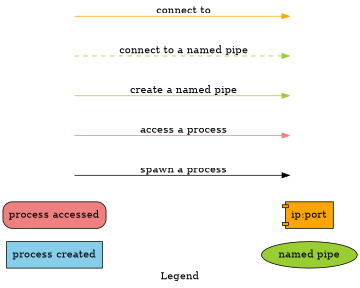

In [72]:
display_graph(build_legend())

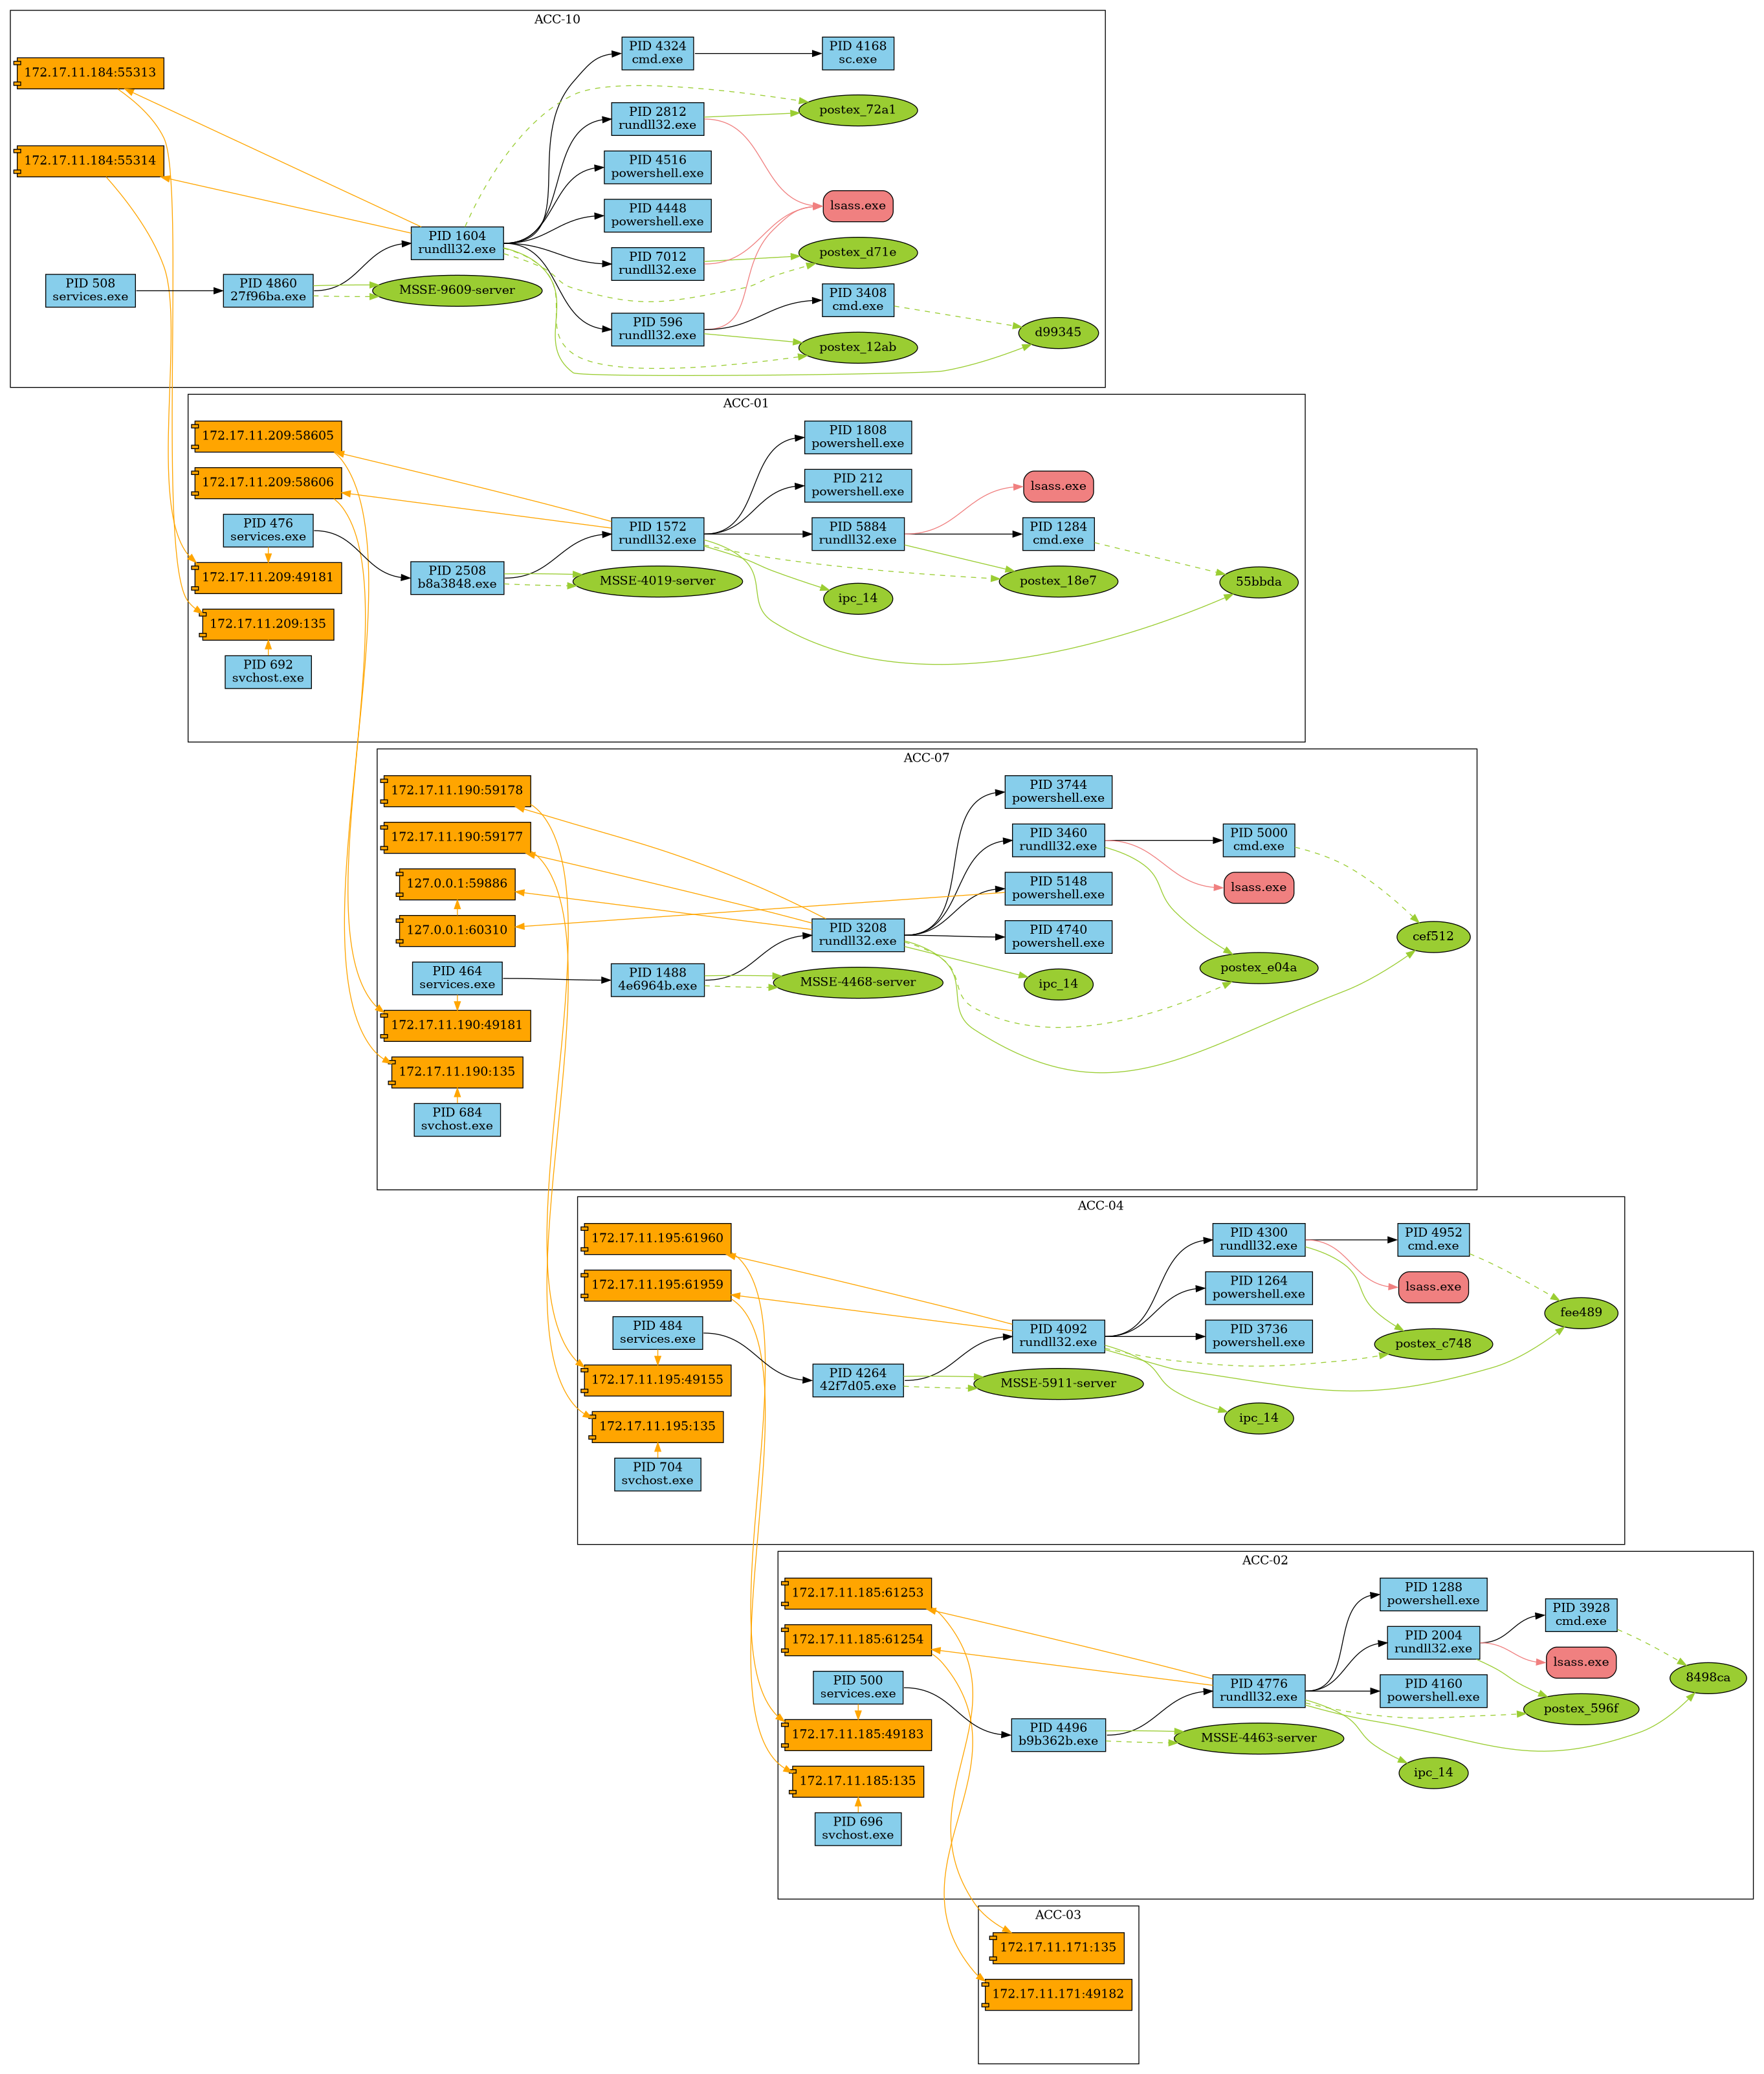

In [73]:
subjects = ['ACC-10', 'ACC-01', 'ACC-07', 'ACC-04', 'ACC-02', 'ACC-03']

processes, accesses, pipes, connections = get_graph_elements_from_dataframes(
    df_cobalt_processes, df_cobalt_access, df_cobalt_pipes, df_cobalt_network
)
G = build_graph(subjects, processes, accesses, pipes, connections)
#print(G.string())
display_graph(G)

This visualization clearly reflects the beacons: they are the central process from which the rest is performed:
- PID 1604 on ACC-10
- PID 1572 on ACC-01
- PID 3208 on ACC-07
- PID 4092 on ACC-04
- PID 4776 on ACC-02

# Beginning of the Attack
Everything started on ACC-10, but we still don't know how the first Cobalt Strike loader was implanted as a service. 
As attackers don't change their toolset on the go, we first look for other __rundll32.exe__ earlier, those without any argument.

In [74]:
f_subject = df_sysmon_1['subject'] == 'ACC-10'
f_end = df_sysmon_1.index < '2022-08-05 22:00'
f_rundll32 = df_sysmon_1['cmdline'].str.contains('rundll32.exe$')
df_start_processes = df_sysmon_1.loc[f_subject & f_end & f_rundll32]
df_start_processes.drop(columns=['raw'])

subject   pid  ppid  \
datetime                                        
2022-08-05 21:42:55+00:00  ACC-10   364  6728   
2022-08-05 21:49:19+00:00  ACC-10  2884   364   
2022-08-05 21:51:43+00:00  ACC-10  5160   364   
2022-08-05 21:54:28+00:00  ACC-10  5232   364   

                                               process_name  \
datetime                                                      
2022-08-05 21:42:55+00:00  C:\Windows\SysWOW64\rundll32.exe   
2022-08-05 21:49:19+00:00  C:\Windows\SysWOW64\rundll32.exe   
2022-08-05 21:51:43+00:00  C:\Windows\SysWOW64\rundll32.exe   
2022-08-05 21:54:28+00:00  C:\Windows\SysWOW64\rundll32.exe   

                                                     parent_process_name  \
datetime                                                                   
2022-08-05 21:42:55+00:00  C:\Program Files (x86)\Java\jre7\bin\java.exe   
2022-08-05 21:49:19+00:00               C:\Windows\SysWOW64\rundll32.exe   
2022-08-05 21:51:43+00:00               C:\Windows\SysWOW64\rundll32.exe   
2022-08-05 21:54:28+00:00               C:\Windows\SysWOW64\rundll32.exe   

                                                    cmdline             user  
datetime                                                                      
2022-08-05 21:42:55+00:00  C:\Windows\System32\rundll32.exe  CORP\Joann.Sims  
2022-08-05 21:49:19+00:00  C:\Windows\syswow64\rundll32.exe  CORP\Joann.Sims  
2022-08-05 21:51:43+00:00  C:\Windows\syswow64\rundll32.exe  CORP\Joann.Sims  
2022-08-05 21:54:28+00:00  C:\Windows\syswow64\rundll32.exe  CORP\Joann.Sims

That's interesting:
- PID 364, rundll32.exe without arguments was spawned from java.exe, which is quite unusual
- this PID also spawned 3 more rundll32.exe without arguments

We hunt backward from the common parent PID 6728 to ascertain to root cause of these processes.

In [75]:
f_subject = df_sysmon_1['subject'] == 'ACC-10'
f_end = df_sysmon_1.index < '2022-08-05 22:00'
f_rundll32 = df_sysmon_1['cmdline'].str.contains('rundll32.exe$')
df_start_processes = df_sysmon_1.loc[f_subject & f_end & f_rundll32]

root = ('6728', 'java.exe')
while True:
    f_pid = df_sysmon_1\
        .assign(process_name=df_sysmon_1['process_name'].apply(lambda x: x.split('\\')[-1]))\
        .set_index(['pid', 'process_name'])\
        .index.isin([root])
    df_parent = df_sysmon_1\
        .assign(parent_process_name=df_sysmon_1['parent_process_name'].apply(lambda x: x.split('\\')[-1]))\
        .loc[f_pid]
    if len(df_parent.index) == 0:
        break

    df_start_processes = pd.concat([df_start_processes, df_parent], axis=0)
    root = tuple(df_parent[['ppid', 'parent_process_name']].values[0])

df_start_processes = df_start_processes.sort_index()
df_start_processes.drop(columns=['raw'])

subject   pid  ppid  \
datetime                                        
2022-08-05 21:21:26+00:00  ACC-10  2132  2016   
2022-08-05 21:42:22+00:00  ACC-10  5440  2132   
2022-08-05 21:42:36+00:00  ACC-10  6728  2572   
2022-08-05 21:42:36+00:00  ACC-10  2572  5440   
2022-08-05 21:42:55+00:00  ACC-10   364  6728   
2022-08-05 21:49:19+00:00  ACC-10  2884   364   
2022-08-05 21:51:43+00:00  ACC-10  5160   364   
2022-08-05 21:54:28+00:00  ACC-10  5232   364   

                                                                           process_name  \
datetime                                                                                  
2022-08-05 21:21:26+00:00  C:\Program Files (x86)\Microsoft Office\Office14\OUTLOOK.EXE   
2022-08-05 21:42:22+00:00         C:\Program Files (x86)\Internet Explorer\iexplore.exe   
2022-08-05 21:42:36+00:00                 C:\Program Files (x86)\Java\jre7\bin\java.exe   
2022-08-05 21:42:36+00:00          C:\Program Files (x86)\Java\jre7\bin\jp2launcher.exe   
2022-08-05 21:42:55+00:00                              C:\Windows\SysWOW64\rundll32.exe   
2022-08-05 21:49:19+00:00                              C:\Windows\SysWOW64\rundll32.exe   
2022-08-05 21:51:43+00:00                              C:\Windows\SysWOW64\rundll32.exe   
2022-08-05 21:54:28+00:00                              C:\Windows\SysWOW64\rundll32.exe   

                                                     parent_process_name  \
datetime                                                                   
2022-08-05 21:21:26+00:00                                   explorer.exe   
2022-08-05 21:42:22+00:00                                    OUTLOOK.EXE   
2022-08-05 21:42:36+00:00                                jp2launcher.exe   
2022-08-05 21:42:36+00:00                                   iexplore.exe   
2022-08-05 21:42:55+00:00  C:\Program Files (x86)\Java\jre7\bin\java.exe   
2022-08-05 21:49:19+00:00               C:\Windows\SysWOW64\rundll32.exe   
2022-08-05 21:51:43+00:00               C:\Windows\SysWOW64\rundll32.exe   
2022-08-05 21:54:28+00:00               C:\Windows\SysWOW64\rundll32.exe   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                   cmdline  \
datetime                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                     
2022-08-05 21:21:26+00:00                                                                                                                                                                                                                                                                                                                                                                                                                                     "C:\PROGRA~2\MICROS~1\Office14\OUTLOOK.EXE"    
2022-08-05 21:42:22+00:00                                                                                                                                                                                                                                                                                                                                                                    

That sounds like a user, Joann Sims, visited a link from an email, and ended on a page with a malicious Java applet (jp2launcher.exe). 

We save these Outlook and Java events to the report.

In [76]:
new_indicators = ['blog.coinmarketcap.com', 'deploy.jar']

In [77]:
answers['start'].append('user CORP\Joann Sims follow a link in an email: blog.coinmarketcap.com')
answers['vector'].extend([
    'jp2launcher: Java applet executed from IE (iexplore.exe)',
    'jp2launcher execute java.exe with argument deploy.jar',
    'executing deploy.jar spawns a CS beacon through rundll32.exe (PID 364)'
])

In [78]:
# save start of outlook
f_outlook = df_start_processes['process_name'].str.endswith('OUTLOOK.EXE')
df_start_processes.loc[f_outlook, 'report_desc'] = 'User starts Outlook'
df_start_processes.loc[f_outlook, 'mitre_tactic'] = 'Initial Access'

# save link opened from outlook
f_link = df_start_processes['process_name'].str.endswith('iexplore.exe')
df_start_processes.loc[f_link, 'report_desc'] = 'User follows a link to blog.coinmarketcap.com'
df_start_processes.loc[f_link, 'mitre_tactic'] = 'Initial Access'

# save Java executions
f_java = df_start_processes['process_name'].str.contains('Java')
df_start_processes.loc[f_java, 'report_desc'] = 'Java applet executed from IE (deploy.jar)'
df_start_processes.loc[f_java, 'mitre_tactic'] = 'Initial Access'

In [79]:
indicators += new_indicators

And we re-apply the method used for the chain of Cobalt Strike processes: we correlate __df_start_processes__ with process accessed, pipes creation/connection, and network connection to find out the purpose of the rundll32.exe executions.

## Correlations with Named Pipes

In [80]:
list_pids_names = df_start_processes\
    .assign(process_name=df_start_processes['process_name'].str.lower())\
    .set_index(['subject', 'pid', 'process_name'])\
    .index.drop_duplicates().tolist()

In [81]:
# list correlations between named pipes and df_start_processes, save in df_start_pipes
df_start_pipes = check_processes_in(df_sysmon_17_18, list_pids_names, ['eid', 'pipe_name'])
df_start_pipes.drop(columns=['raw'])

subject eid   pid  \
datetime                                      
2022-08-05 21:42:36+00:00  ACC-10  18  6728   
2022-08-05 21:42:36+00:00  ACC-10  18  6728   
2022-08-05 21:49:19+00:00  ACC-10  17  2884   
2022-08-05 21:49:19+00:00  ACC-10  18   364   
2022-08-05 21:51:43+00:00  ACC-10  17  5160   
2022-08-05 21:51:43+00:00  ACC-10  18   364   
2022-08-05 21:54:28+00:00  ACC-10  17  5232   
2022-08-05 21:54:29+00:00  ACC-10  18   364   
2022-08-05 22:00:08+00:00  ACC-10  18  5232   

                                                            process_name  \
datetime                                                                   
2022-08-05 21:42:36+00:00  C:\Program Files (x86)\Java\jre7\bin\java.exe   
2022-08-05 21:42:36+00:00  C:\Program Files (x86)\Java\jre7\bin\java.exe   
2022-08-05 21:49:19+00:00               C:\Windows\syswow64\rundll32.exe   
2022-08-05 21:49:19+00:00               C:\Windows\SysWOW64\rundll32.exe   
2022-08-05 21:51:43+00:00               C:\Windows\syswow64\rundll32.exe   
2022-08-05 21:51:43+00:00               C:\Windows\SysWOW64\rundll32.exe   
2022-08-05 21:54:28+00:00               C:\Windows\syswow64\rundll32.exe   
2022-08-05 21:54:29+00:00               C:\Windows\SysWOW64\rundll32.exe   
2022-08-05 22:00:08+00:00               C:\Windows\syswow64\rundll32.exe   

                                     pipe_name  
datetime                                        
2022-08-05 21:42:36+00:00  \jpi2_pid3904_pipe3  
2022-08-05 21:42:36+00:00  \jpi2_pid3904_pipe2  
2022-08-05 21:49:19+00:00         \postex_d2eb  
2022-08-05 21:49:19+00:00         \postex_d2eb  
2022-08-05 21:51:43+00:00         \postex_50e7  
2022-08-05 21:51:43+00:00         \postex_50e7  
2022-08-05 21:54:28+00:00              \ipc_14  
2022-08-05 21:54:29+00:00              \ipc_14  
2022-08-05 22:00:08+00:00              \ipc_14

In [82]:
# save the named pipes creations and connections to df
f_pipes = df['raw'].isin(df_start_pipes['raw'].tolist()) 
df.loc[f_pipes, 'to_keep'] = True

f_pipe = df['evtx_info'] == 'Microsoft-Windows-Sysmon/Operational;Microsoft-Windows-Sysmon;17'
df.loc[f_pipes & f_pipe, 'to_keep'] = True
df.loc[f_pipes & f_pipe, 'report_desc'] = 'Cobalt Strike named pipe creation'
df.loc[f_pipes & f_pipe, 'mitre_tactic'] = 'Execution'

f_pipe = df['evtx_info'] == 'Microsoft-Windows-Sysmon/Operational;Microsoft-Windows-Sysmon;18'
df.loc[f_pipes & f_pipe, 'to_keep'] = True
df.loc[f_pipes & f_pipe, 'report_desc'] = 'Cobalt Strike named pipe connection'
df.loc[f_pipes & f_pipe, 'mitre_tactic'] = 'Execution'

In [83]:
# merge the details columns from df_start_pipes into df
df = df.set_index(['subject', 'raw'], append=True)\
    .combine_first(df_start_pipes.set_index(['subject', 'raw'], append=True))\
    .reset_index(level=[1,2])

f_pipes = df['raw'].isin(df_start_pipes['raw'].tolist()) 
df.loc[f_pipes, ['subject', 'source', 'report_desc', 'mitre_tactic', 'pid', 'process_name', 'pipe_name']]

subject                                     source  \
datetime                                                                       
2022-08-05 21:42:36+00:00  ACC-10  evtx_Microsoft-Windows-Sysmon/Operational   
2022-08-05 21:42:36+00:00  ACC-10  evtx_Microsoft-Windows-Sysmon/Operational   
2022-08-05 21:49:19+00:00  ACC-10  evtx_Microsoft-Windows-Sysmon/Operational   
2022-08-05 21:49:19+00:00  ACC-10  evtx_Microsoft-Windows-Sysmon/Operational   
2022-08-05 21:51:43+00:00  ACC-10  evtx_Microsoft-Windows-Sysmon/Operational   
2022-08-05 21:51:43+00:00  ACC-10  evtx_Microsoft-Windows-Sysmon/Operational   
2022-08-05 21:54:28+00:00  ACC-10  evtx_Microsoft-Windows-Sysmon/Operational   
2022-08-05 21:54:29+00:00  ACC-10  evtx_Microsoft-Windows-Sysmon/Operational   
2022-08-05 22:00:08+00:00  ACC-10  evtx_Microsoft-Windows-Sysmon/Operational   

                                                   report_desc mitre_tactic  \
datetime                                                                      
2022-08-05 21:42:36+00:00  Cobalt Strike named pipe connection    Execution   
2022-08-05 21:42:36+00:00  Cobalt Strike named pipe connection    Execution   
2022-08-05 21:49:19+00:00    Cobalt Strike named pipe creation    Execution   
2022-08-05 21:49:19+00:00  Cobalt Strike named pipe connection    Execution   
2022-08-05 21:51:43+00:00    Cobalt Strike named pipe creation    Execution   
2022-08-05 21:51:43+00:00  Cobalt Strike named pipe connection    Execution   
2022-08-05 21:54:28+00:00    Cobalt Strike named pipe creation    Execution   
2022-08-05 21:54:29+00:00  Cobalt Strike named pipe connection    Execution   
2022-08-05 22:00:08+00:00  Cobalt Strike named pipe connection    Execution   

                            pid  \
datetime                          
2022-08-05 21:42:36+00:00  6728   
2022-08-05 21:42:36+00:00  6728   
2022-08-05 21:49:19+00:00  2884   
2022-08-05 21:49:19+00:00   364   
2022-08-05 21:51:43+00:00  5160   
2022-08-05 21:51:43+00:00   364   
2022-08-05 21:54:28+00:00  5232   
2022-08-05 21:54:29+00:00   364   
2022-08-05 22:00:08+00:00  5232   

                                                            process_name  \
datetime                                                                   
2022-08-05 21:42:36+00:00  C:\Program Files (x86)\Java\jre7\bin\java.exe   
2022-08-05 21:42:36+00:00  C:\Program Files (x86)\Java\jre7\bin\java.exe   
2022-08-05 21:49:19+00:00               C:\Windows\syswow64\rundll32.exe   
2022-08-05 21:49:19+00:00               C:\Windows\SysWOW64\rundll32.exe   
2022-08-05 21:51:43+00:00               C:\Windows\syswow64\rundll32.exe   
2022-08-05 21:51:43+00:00               C:\Windows\SysWOW64\rundll32.exe   
2022-08-05 21:54:28+00:00               C:\Windows\syswow64\rundll32.exe   
2022-08-05 21:54:29+00:00               C:\Windows\SysWOW64\rundll32.exe   
2022-08-05 22:00:08+00:00               C:\Windows\syswow64\rundll32.exe   

                                     pipe_name  
datetime                                        
2022-08-05 21:42:36+00:00  \jpi2_pid3904_pipe3  
2022-08-05 21:42:36+00:00  \jpi2_pid3904_pipe2  
2022-08-05 21:49:19+00:00         \postex_d2eb  
2022-08-05 21:49:19+00:00         \postex_d2eb  
2022-08-05 21:51:43+00:00         \postex_50e7  
2022-08-05 21:51:43+00:00         \postex_50e7  
2022-08-05 21:54:28+00:00              \ipc_14  
2022-08-05 21:54:29+00:00              \ipc_14  
2022-08-05 22:00:08+00:00              \ipc_14

## Correlation with Process Accessed

In [84]:
# list correlations between process accessed and df_start_processes
df_start_access = check_processes_in(df_sysmon_10, list_pids_names, ['process_target'])
df_start_access.drop(columns=['raw'])

Empty DataFrame
Columns: [subject, eid, pid, process_name, process_target]
Index: []

There is no correlation with process accessed.

## Correlation with Network Connections

In [85]:
# list correlations between network connections and df_start_processes, save in df_start_network
df_start_network = check_processes_in(
    df_sysmon_3, list_pids_names,
    ['protocol', 'src_ip', 'src_port', 'dst_ip', 'dst_port']
)

# exclude outlook connections to exchange and DC
f_outlook = df_start_network['process_name'].str.endswith('OUTLOOK.EXE')
f_udp = df_start_network['protocol'] == 'udp'
print(len(df_start_network[~f_outlook & ~f_udp].index))
df_start_network = df_start_network[~f_outlook & ~f_udp]
df_start_network.drop(columns=['raw', 'src_hostname']).head()

406


subject eid   pid  \
datetime                                      
2022-08-05 21:42:40+00:00  ACC-10   3  6728   
2022-08-05 21:42:40+00:00  ACC-10   3  5440   
2022-08-05 21:42:57+00:00  ACC-10   3   364   
2022-08-05 21:42:58+00:00  ACC-10   3   364   
2022-08-05 21:43:57+00:00  ACC-10   3   364   

                                                                    process_name  \
datetime                                                                           
2022-08-05 21:42:40+00:00          C:\Program Files (x86)\Java\jre7\bin\java.exe   
2022-08-05 21:42:40+00:00  C:\Program Files (x86)\Internet Explorer\iexplore.exe   
2022-08-05 21:42:57+00:00                       C:\Windows\SysWOW64\rundll32.exe   
2022-08-05 21:42:58+00:00                       C:\Windows\SysWOW64\rundll32.exe   
2022-08-05 21:43:57+00:00                       C:\Windows\SysWOW64\rundll32.exe   

                                      user is_src protocol         src_ip  \
datetime                                                                    
2022-08-05 21:42:40+00:00  CORP\Joann.Sims   true      tcp  172.17.11.184   
2022-08-05 21:42:40+00:00  CORP\Joann.Sims   true      tcp  172.17.11.184   
2022-08-05 21:42:57+00:00  CORP\Joann.Sims   true      tcp  172.17.11.184   
2022-08-05 21:42:58+00:00  CORP\Joann.Sims   true      tcp  172.17.11.184   
2022-08-05 21:43:57+00:00  CORP\Joann.Sims   true      tcp  172.17.11.184   

                          src_port          dst_ip dst_port      dst_hostname  
datetime                                                                       
2022-08-05 21:42:40+00:00    53461    192.0.78.195       80                    
2022-08-05 21:42:40+00:00    53462    192.0.78.195       80                    
2022-08-05 21:42:57+00:00    53463    82.144.131.5      443  5-131.gtt-net.cz  
2022-08-05 21:42:58+00:00    53464  73.245.147.162      443                    
2022-08-05 21:43:57+00:00    53465    82.144.131.5      443  5-131.gtt-net.cz

There is a lot of connections (406), we extract the unique tuples (process_name, dst_ip, dst_port, dst_hostname). 

In [86]:
df_start_network\
    .assign(process_name=df_start_network['process_name'].str.split('\\').str[-1])\
    .groupby(['process_name', 'pid', 'dst_ip', 'dst_port', 'dst_hostname'])\
    .agg({'subject': 'size'})
    

subject
process_name pid  dst_ip         dst_port dst_hostname                                 
iexplore.exe 5440 192.0.78.195   80                                                   1
java.exe     6728 192.0.78.195   80                                                   1
rundll32.exe 364  73.245.147.162 443                                                  1
                                          c-73-245-147-162.hsd1.fl.comcast.net      176
                  82.144.131.5   443      5-131.gtt-net.cz                          177
             5160 172.17.11.156  139      ACC-17                                      1
                                 445      ACC-17                                      1
                  172.17.11.164  135      ACC-05                                      1
                                 139      ACC-05                                      1
                                 3389     ACC-05                                      1
                                 445      ACC-05                                      1
                  172.17.11.167  135      ACC-12                                      1
                                 139      ACC-12                                      1
                                 3389     ACC-12                                      1
                                 445      ACC-12                                      1
                  172.17.11.171  135      ACC-03                                      1
                                 139      ACC-03                                      1
                                 3389     ACC-03                                      1
                                 445      ACC-03                                      1
                  172.17.11.177  135      ACC-11                                      1
                                 139      ACC-11                                      1
                                 3389     ACC-11                                      1
                                 445      ACC-11                                      1
                  172.17.11.184  135      ACC-10.corp.net                             1
                                 139      ACC-10.corp.net                             1
                                 3389     ACC-10.corp.net                             1
                                 445      ACC-10.corp.net                             1
                  172.17.11.185  135      ACC-02                                      1
                                 139      ACC-02                                      1
                                 3389     ACC-02                                      1
                                 445      ACC-02                                      1
                  172.17.11.190  135      ACC-07                                      1
                                 139      ACC-07                                      1
                                 3389     ACC-07                                      1
                                 445      ACC-07                                      1
                  172.17.11.195  135      ACC-04                                      1
                                 139      ACC-04                                      1
                                 3389     ACC-04                                      1
                                 445      ACC-04                                      1
                  172.17.11.203  135      ACC-09                                      1
                                 139      ACC-09                                      1
                                 3389     ACC-09                                      1
                                 445      ACC-09                                      1
                  172.17.11.204  135      ACC-06                                      1
                                

This table tell us a lot:
- 192.0.78.195 is reached both by IE and java: this is probably the IP address of blog.coinmarketcap.com
- our beacon PID 364 is confirmed: given the number of hits (177 for both), its C2 are
    - c-73-245-147-162.hsd1.fl.comcast.net (73.245.147.162 TCP 443)
    - 5-131.gtt-net.cz (82.144.131.5 TCP 443)
- through PID 5160, the sacrificial process was used to scan the subnet
    - on ports 135 (RPC), 139 (NetBIOS), 3389 (RDP), 445 (SMB), all privileged protocols by threat actors
    - 12 hosts were scanned this way (excluding ACC-10 itself)

It's time to save the events in the report.

In [87]:
answers['c2'].extend([
    'c-73-245-147-162.hsd1.fl.comcast.net: 73.245.147.162',
    '5-131.gtt-net.cz: 82.144.131.5',
    'C2s reached from ACC-10, PID 364',
])
answers['vector'].append('blog.coinmarketcap.com: 192.0.78.195')

In [88]:
new_indicators = [
    '192.0.78.195', 
    'c-73-245-147-162.hsd1.fl.comcast.net', '73.245.147.162',
    '5-131.gtt-net.cz', '82.144.131.5'
]

In [89]:
# save rundll32 purposes in df_start_processes
f_scan = df_start_processes['pid'] == '5160'
df_start_processes.loc[f_scan, 'report_desc'] = 'Scan subnet (12 hosts, TCP 135,139,3389,445)'
df_start_processes.loc[f_scan, 'mitre_tactic'] = 'Discovery'

f_beacon = df_start_processes['pid'] == '364'
df_start_processes.loc[f_beacon, 'report_desc'] = 'Cobalt Strike beacon spawned'
df_start_processes.loc[f_beacon, 'mitre_tactic'] = 'Command and Control'

In [90]:
# save network connections in df
f_conns = df['raw'].isin(df_start_network['raw'].tolist())
df.loc[f_conns, 'to_keep'] = True

# save connections related to blog.coinmarketcap.com
f_website = df['raw'].str.contains('192.0.78.195')
df.loc[f_conns & f_website, 'report_desc'] = 'Connection to blog.coinmarketcap.com'
df.loc[f_conns & f_website, 'mitre_tactic'] = 'Initial Access'

# save connections related to C2
f_c2 = df['raw'].str.contains('73.245.147.162|82.144.131.5')
df.loc[f_conns & f_c2, 'report_desc'] = 'Connection to C2'
df.loc[f_conns & f_c2, 'mitre_tactic'] = 'Command and Control'

# save scan
f_scan = df['raw'].str.contains('ProcessId">5160</Data>')
df.loc[f_scan, 'report_desc'] = 'Scan subnet (12 hosts, TCP 135,139,3389,445)'
df.loc[f_scan, 'mitre_tactic'] = 'Discovery'

In [91]:
# merge the details columns from df_start_network into df
df = df.set_index(['subject', 'raw'], append=True)\
    .combine_first(df_start_network.set_index(['subject', 'raw'], append=True))\
    .reset_index(level=[1,2])

In [92]:
f_conns = df['raw'].isin(df_start_network['raw'].tolist()) 
columns = [
    'subject', 'report_desc', 'mitre_tactic', 
    'pid', 'process_name', 'protocol', 'is_src', 'src_ip', 'src_port', 'dst_ip', 'dst_port'
]
df.loc[f_conns, columns].head()

subject                           report_desc  \
datetime                                                                  
2022-08-05 21:42:40+00:00  ACC-10  Connection to blog.coinmarketcap.com   
2022-08-05 21:42:40+00:00  ACC-10  Connection to blog.coinmarketcap.com   
2022-08-05 21:42:57+00:00  ACC-10                      Connection to C2   
2022-08-05 21:42:58+00:00  ACC-10                      Connection to C2   
2022-08-05 21:43:57+00:00  ACC-10                      Connection to C2   

                                  mitre_tactic   pid  \
datetime                                               
2022-08-05 21:42:40+00:00       Initial Access  6728   
2022-08-05 21:42:40+00:00       Initial Access  5440   
2022-08-05 21:42:57+00:00  Command and Control   364   
2022-08-05 21:42:58+00:00  Command and Control   364   
2022-08-05 21:43:57+00:00  Command and Control   364   

                                                                    process_name  \
datetime                                                                           
2022-08-05 21:42:40+00:00          C:\Program Files (x86)\Java\jre7\bin\java.exe   
2022-08-05 21:42:40+00:00  C:\Program Files (x86)\Internet Explorer\iexplore.exe   
2022-08-05 21:42:57+00:00                       C:\Windows\SysWOW64\rundll32.exe   
2022-08-05 21:42:58+00:00                       C:\Windows\SysWOW64\rundll32.exe   
2022-08-05 21:43:57+00:00                       C:\Windows\SysWOW64\rundll32.exe   

                          protocol is_src         src_ip src_port  \
datetime                                                            
2022-08-05 21:42:40+00:00      tcp   true  172.17.11.184    53461   
2022-08-05 21:42:40+00:00      tcp   true  172.17.11.184    53462   
2022-08-05 21:42:57+00:00      tcp   true  172.17.11.184    53463   
2022-08-05 21:42:58+00:00      tcp   true  172.17.11.184    53464   
2022-08-05 21:43:57+00:00      tcp   true  172.17.11.184    53465   

                                   dst_ip dst_port  
datetime                                            
2022-08-05 21:42:40+00:00    192.0.78.195       80  
2022-08-05 21:42:40+00:00    192.0.78.195       80  
2022-08-05 21:42:57+00:00    82.144.131.5      443  
2022-08-05 21:42:58+00:00  73.245.147.162      443  
2022-08-05 21:43:57+00:00    82.144.131.5      443

In [93]:
indicators += new_indicators

## Unexplained Sacrificial Processes

In [94]:
df_start_processes.drop(columns=['raw', 'cmdline'])

subject   pid  ppid  \
datetime                                        
2022-08-05 21:21:26+00:00  ACC-10  2132  2016   
2022-08-05 21:42:22+00:00  ACC-10  5440  2132   
2022-08-05 21:42:36+00:00  ACC-10  6728  2572   
2022-08-05 21:42:36+00:00  ACC-10  2572  5440   
2022-08-05 21:42:55+00:00  ACC-10   364  6728   
2022-08-05 21:49:19+00:00  ACC-10  2884   364   
2022-08-05 21:51:43+00:00  ACC-10  5160   364   
2022-08-05 21:54:28+00:00  ACC-10  5232   364   

                                                                           process_name  \
datetime                                                                                  
2022-08-05 21:21:26+00:00  C:\Program Files (x86)\Microsoft Office\Office14\OUTLOOK.EXE   
2022-08-05 21:42:22+00:00         C:\Program Files (x86)\Internet Explorer\iexplore.exe   
2022-08-05 21:42:36+00:00                 C:\Program Files (x86)\Java\jre7\bin\java.exe   
2022-08-05 21:42:36+00:00          C:\Program Files (x86)\Java\jre7\bin\jp2launcher.exe   
2022-08-05 21:42:55+00:00                              C:\Windows\SysWOW64\rundll32.exe   
2022-08-05 21:49:19+00:00                              C:\Windows\SysWOW64\rundll32.exe   
2022-08-05 21:51:43+00:00                              C:\Windows\SysWOW64\rundll32.exe   
2022-08-05 21:54:28+00:00                              C:\Windows\SysWOW64\rundll32.exe   

                                                     parent_process_name  \
datetime                                                                   
2022-08-05 21:21:26+00:00                                   explorer.exe   
2022-08-05 21:42:22+00:00                                    OUTLOOK.EXE   
2022-08-05 21:42:36+00:00                                jp2launcher.exe   
2022-08-05 21:42:36+00:00                                   iexplore.exe   
2022-08-05 21:42:55+00:00  C:\Program Files (x86)\Java\jre7\bin\java.exe   
2022-08-05 21:49:19+00:00               C:\Windows\SysWOW64\rundll32.exe   
2022-08-05 21:51:43+00:00               C:\Windows\SysWOW64\rundll32.exe   
2022-08-05 21:54:28+00:00               C:\Windows\SysWOW64\rundll32.exe   

                                      user  \
datetime                                     
2022-08-05 21:21:26+00:00  CORP\Joann.Sims   
2022-08-05 21:42:22+00:00  CORP\Joann.Sims   
2022-08-05 21:42:36+00:00  CORP\Joann.Sims   
2022-08-05 21:42:36+00:00  CORP\Joann.Sims   
2022-08-05 21:42:55+00:00  CORP\Joann.Sims   
2022-08-05 21:49:19+00:00  CORP\Joann.Sims   
2022-08-05 21:51:43+00:00  CORP\Joann.Sims   
2022-08-05 21:54:28+00:00  CORP\Joann.Sims   

                                                             report_desc  \
datetime                                                                   
2022-08-05 21:21:26+00:00                            User starts Outlook   
2022-08-05 21:42:22+00:00  User follows a link to blog.coinmarketcap.com   
2022-08-05 21:42:36+00:00      Java applet executed from IE (deploy.jar)   
2022-08-05 21:42:36+00:00      Java applet executed from IE (deploy.jar)   
2022-08-05 21:42:55+00:00                   Cobalt Strike beacon spawned   
2022-08-05 21:49:19+00:00                                            NaN   
2022-08-05 21:51:43+00:00   Scan subnet (12 hosts, TCP 135,139,3389,445)   
2022-08-05 21:54:28+00:00                                            NaN   

                                  mitre_tactic  
datetime                                        
2022-08-05 21:21:26+00:00       Initial Access  
2022-08-05 21:42:22+00:00       Initial Access  
2022-08-05 21:42:36+00:00       Initial Access  
2022-08-05 21:42:36+00:00       Initial Access  
2022-08-05 21:42:55+00:00  Command and Control  
2022-08-05 21:49:19+00:00                  NaN  
2022-08-05 21:51:43+00:00            Discovery  
2022-08-05 21:54:28+00:00                  NaN

We have 2 remaining unidentified sacrifical processes: PID 2884 and PID 5232. 
Also, we notice the threat actor started as user Joann.Sims, and to install Cobalt Strike loaders as service, administrator privileges were required. 

## Identifying ACC-10 PID 5232

In [95]:
f_5232 = df_start_pipes['pid'] == '5232'
df_start_pipes.loc[f_5232].drop(columns='raw')

subject eid   pid                      process_name  \
datetime                                                                        
2022-08-05 21:54:28+00:00  ACC-10  17  5232  C:\Windows\syswow64\rundll32.exe   
2022-08-05 22:00:08+00:00  ACC-10  18  5232  C:\Windows\syswow64\rundll32.exe   

                          pipe_name  
datetime                             
2022-08-05 21:54:28+00:00   \ipc_14  
2022-08-05 22:00:08+00:00   \ipc_14

In [96]:
f_ipc14 = df['pipe_name'] == '\\ipc_14'
df.loc[f_ipc14, ['subject', 'report_desc', 'mitre_tactic', 'pid', 'process_name', 'pipe_name']]

subject                          report_desc  \
datetime                                                                 
2022-08-05 21:54:28+00:00  ACC-10    Cobalt Strike named pipe creation   
2022-08-05 21:54:29+00:00  ACC-10  Cobalt Strike named pipe connection   
2022-08-05 22:00:08+00:00  ACC-10  Cobalt Strike named pipe connection   
2022-08-05 22:17:31+00:00  ACC-01    Cobalt Strike named pipe creation   
2022-08-05 22:22:18+00:00  ACC-07    Cobalt Strike named pipe creation   
2022-08-05 22:26:27+00:00  ACC-04    Cobalt Strike named pipe creation   
2022-08-05 22:31:38+00:00  ACC-02    Cobalt Strike named pipe creation   

                          mitre_tactic   pid  \
datetime                                       
2022-08-05 21:54:28+00:00    Execution  5232   
2022-08-05 21:54:29+00:00    Execution   364   
2022-08-05 22:00:08+00:00    Execution  5232   
2022-08-05 22:17:31+00:00    Execution  1572   
2022-08-05 22:22:18+00:00    Execution  3208   
2022-08-05 22:26:27+00:00    Execution  4092   
2022-08-05 22:31:38+00:00    Execution  4776   

                                               process_name pipe_name  
datetime                                                               
2022-08-05 21:54:28+00:00  C:\Windows\syswow64\rundll32.exe   \ipc_14  
2022-08-05 21:54:29+00:00  C:\Windows\SysWOW64\rundll32.exe   \ipc_14  
2022-08-05 22:00:08+00:00  C:\Windows\syswow64\rundll32.exe   \ipc_14  
2022-08-05 22:17:31+00:00  C:\Windows\SysWOW64\rundll32.exe   \ipc_14  
2022-08-05 22:22:18+00:00  C:\Windows\SysWOW64\rundll32.exe   \ipc_14  
2022-08-05 22:26:27+00:00  C:\Windows\SysWOW64\rundll32.exe   \ipc_14  
2022-08-05 22:31:38+00:00  C:\Windows\SysWOW64\rundll32.exe   \ipc_14

For PID 5232, there is something interesting:
- from pipes, we know that it created the named_pipe __ipc_14__
- we also know that the beacon connected to C2 (PID 364) connected to __ipc_14__
- from the visualization of process communications with ACC-01, ACC-07, ACC-04 and ACC-02, all their beacons also create a __ipc_14__ named pipe. 

We can make an educated guess that this named pipe is used for inter-beacon communications.
If so, we missed some connections to __ipc_14__ on subjects. 
For a named pipe connection from host A to host B, we should observe:
- a SMB connection (TCP 445) from host A to host B, handled by the process System on host A
- the process System on host B then connect to the named pipe

On a Windows machine, the process System exists for each processor and handles the memory from the kernel.

So, let see if this reasoning holds and if we can complete the picture.

In [97]:
# extract all connections to ipc_14 established by the process System
f_ipc14 = df_sysmon_17_18['pipe_name'] == '\\ipc_14'
df_sysmon_17_18.loc[f_ipc14].drop(columns=['raw']).sort_index()

subject eid   pid                      process_name  \
datetime                                                                        
2022-08-05 21:54:28+00:00  ACC-10  17  5232  C:\Windows\syswow64\rundll32.exe   
2022-08-05 21:54:29+00:00  ACC-10  18   364  C:\Windows\SysWOW64\rundll32.exe   
2022-08-05 22:00:08+00:00  ACC-10  18  5232  C:\Windows\syswow64\rundll32.exe   
2022-08-05 22:17:31+00:00  ACC-01  17  1572  C:\Windows\SysWOW64\rundll32.exe   
2022-08-05 22:17:33+00:00  ACC-01  18     4                            System   
2022-08-05 22:22:18+00:00  ACC-07  17  3208  C:\Windows\SysWOW64\rundll32.exe   
2022-08-05 22:22:20+00:00  ACC-07  18     4                            System   
2022-08-05 22:26:27+00:00  ACC-04  17  4092  C:\Windows\SysWOW64\rundll32.exe   
2022-08-05 22:26:29+00:00  ACC-04  18     4                            System   
2022-08-05 22:31:38+00:00  ACC-02  17  4776  C:\Windows\SysWOW64\rundll32.exe   
2022-08-05 22:31:40+00:00  ACC-02  18     4                            System   

                          pipe_name  
datetime                             
2022-08-05 21:54:28+00:00   \ipc_14  
2022-08-05 21:54:29+00:00   \ipc_14  
2022-08-05 22:00:08+00:00   \ipc_14  
2022-08-05 22:17:31+00:00   \ipc_14  
2022-08-05 22:17:33+00:00   \ipc_14  
2022-08-05 22:22:18+00:00   \ipc_14  
2022-08-05 22:22:20+00:00   \ipc_14  
2022-08-05 22:26:27+00:00   \ipc_14  
2022-08-05 22:26:29+00:00   \ipc_14  
2022-08-05 22:31:38+00:00   \ipc_14  
2022-08-05 22:31:40+00:00   \ipc_14

Indeed, we see System connecting to __ipc_14__ on ACC-01, ACC-07, ACC-02 and ACC-04. 
Let see now if it matches SMB connections from another host, also by the System process.

In [98]:
# extract all SMB connections established by the process System between 2 subjects
f_smb = (df_sysmon_3['dst_port'] == '445') | (df_sysmon_3['src_port'] == '445')
f_lateral = df_sysmon_3['src_hostname'] != df_sysmon_3['dst_hostname']
f_system = df_sysmon_3['process_name'] == 'System'

# slice to timeframe to exclude already identified scanning
f_start = df_sysmon_3.index > '2022-08-05 22:00'

# exclude SMB connections to DC and File Share
f_dc_fs = df_sysmon_3['dst_hostname'].str.contains('DC|FS')

columns = [
    'subject', 'pid', 'process_name', 'protocol', 'is_src', 
    'src_hostname', 'src_ip', 'src_port', 'dst_hostname', 'dst_ip', 'dst_port'
]
df_sysmon_3.loc[f_start & f_smb & f_lateral & f_system & ~f_dc_fs, columns].sort_index()

subject pid process_name protocol is_src  \
datetime                                                             
2022-08-05 22:17:31+00:00  ACC-10   4       System      tcp   true   
2022-08-05 22:17:31+00:00  ACC-01   4       System      tcp  false   
2022-08-05 22:22:18+00:00  ACC-01   4       System      tcp   true   
2022-08-05 22:22:18+00:00  ACC-07   4       System      tcp  false   
2022-08-05 22:26:28+00:00  ACC-04   4       System      tcp  false   
2022-08-05 22:26:32+00:00  ACC-07   4       System      tcp   true   
2022-08-05 22:31:36+00:00  ACC-02   4       System      tcp  false   
2022-08-05 22:31:39+00:00  ACC-04   4       System      tcp   true   
2022-08-05 22:35:03+00:00  ACC-02   4       System      tcp   true   

                              src_hostname         src_ip src_port  \
datetime                                                             
2022-08-05 22:17:31+00:00  ACC-10.corp.net  172.17.11.184    55312   
2022-08-05 22:17:31+00:00  ACC-01.corp.net  172.17.11.209      445   
2022-08-05 22:22:18+00:00  ACC-01.corp.net  172.17.11.209    58604   
2022-08-05 22:22:18+00:00  ACC-07.corp.net  172.17.11.190      445   
2022-08-05 22:26:28+00:00  ACC-04.corp.net  172.17.11.195      445   
2022-08-05 22:26:32+00:00  ACC-07.corp.net  172.17.11.190    59176   
2022-08-05 22:31:36+00:00  ACC-02.corp.net  172.17.11.185      445   
2022-08-05 22:31:39+00:00  ACC-04.corp.net  172.17.11.195    61958   
2022-08-05 22:35:03+00:00  ACC-02.corp.net  172.17.11.185    61252   

                          dst_hostname         dst_ip dst_port  
datetime                                                        
2022-08-05 22:17:31+00:00       ACC-01  172.17.11.209      445  
2022-08-05 22:17:31+00:00       ACC-10  172.17.11.184    55312  
2022-08-05 22:22:18+00:00       ACC-07  172.17.11.190      445  
2022-08-05 22:22:18+00:00       ACC-01  172.17.11.209    58604  
2022-08-05 22:26:28+00:00       ACC-07  172.17.11.190    59176  
2022-08-05 22:26:32+00:00       ACC-04  172.17.11.195      445  
2022-08-05 22:31:36+00:00       ACC-04  172.17.11.195    61958  
2022-08-05 22:31:39+00:00       ACC-02  172.17.11.185      445  
2022-08-05 22:35:03+00:00       ACC-03  172.17.11.171      445

Perfect, our reasoning is verified, we observe SMB connections from source host at the very same timestamp than connections to __ipc_14__ on destination host. 
More precisely, we can assert that:
- __ipc_14__ is the inter-beacon communication
- it was created on ACC-10 (by PID 5232)
- the beacons on ACC-10 and ACC-01 communicates through it
- the beacons on ACC-01 and ACC-07 communicates through it
- the beacons on ACC-07 and ACC-04 communicates through it
- the beacons on ACC-04 and ACC-02 communicates through it
- the beacons on ACC-02 and ACC-03 communicates through it

It's time to update our knowledge in the report, and to add these new events in their respective dataframes.

In [99]:
# complete df_cobalt_pipes
f_ipc14 = df_sysmon_17_18['pipe_name'] == '\\ipc_14'
f_system = df_sysmon_17_18['process_name'] == 'System'
df_cobalt_pipes = pd.concat([df_cobalt_pipes, df_sysmon_17_18.loc[f_ipc14 & f_system]]).sort_index()

In [100]:
# merge the details columns from df_cobalt_pipes into df
df = df.set_index(['subject', 'raw'], append=True)\
    .combine_first(df_cobalt_pipes.set_index(['subject', 'raw'], append=True))\
    .reset_index(level=[1,2])

In [101]:
# update df report regarding recorded ipc14 events
f_pipes = df['raw'].isin(df_cobalt_pipes['raw'].tolist()) 
df.loc[f_pipes, 'to_keep'] = True

f_ipc14 = df['pipe_name'] == '\\ipc_14'
f_pipe_creation = df['eid'] == '17'
df.loc[f_ipc14 & f_pipe_creation, 'report_desc'] = 'Pipe \ipc_14 created for inter-beacon communication'
df.loc[f_ipc14 & f_pipe_creation, 'mitre_tactic'] = 'Lateral Movement'

f_pipe_conn = df['eid'] == '18'
df.loc[f_ipc14 & f_pipe_conn, 'report_desc'] = 'Connection to inter-beacon named pipe \ipc_14'
df.loc[f_ipc14 & f_pipe_conn, 'mitre_tactic'] = 'Lateral Movement'

df.loc[f_ipc14, ['subject', 'report_desc', 'mitre_tactic', 'eid', 'pid', 'process_name', 'pipe_name']]

subject  \
datetime                            
2022-08-05 21:54:28+00:00  ACC-10   
2022-08-05 21:54:29+00:00  ACC-10   
2022-08-05 22:00:08+00:00  ACC-10   
2022-08-05 22:17:31+00:00  ACC-01   
2022-08-05 22:17:33+00:00  ACC-01   
2022-08-05 22:22:18+00:00  ACC-07   
2022-08-05 22:22:20+00:00  ACC-07   
2022-08-05 22:26:27+00:00  ACC-04   
2022-08-05 22:26:29+00:00  ACC-04   
2022-08-05 22:31:38+00:00  ACC-02   
2022-08-05 22:31:40+00:00  ACC-02   

                                                                   report_desc  \
datetime                                                                         
2022-08-05 21:54:28+00:00  Pipe \ipc_14 created for inter-beacon communication   
2022-08-05 21:54:29+00:00        Connection to inter-beacon named pipe \ipc_14   
2022-08-05 22:00:08+00:00        Connection to inter-beacon named pipe \ipc_14   
2022-08-05 22:17:31+00:00  Pipe \ipc_14 created for inter-beacon communication   
2022-08-05 22:17:33+00:00        Connection to inter-beacon named pipe \ipc_14   
2022-08-05 22:22:18+00:00  Pipe \ipc_14 created for inter-beacon communication   
2022-08-05 22:22:20+00:00        Connection to inter-beacon named pipe \ipc_14   
2022-08-05 22:26:27+00:00  Pipe \ipc_14 created for inter-beacon communication   
2022-08-05 22:26:29+00:00        Connection to inter-beacon named pipe \ipc_14   
2022-08-05 22:31:38+00:00  Pipe \ipc_14 created for inter-beacon communication   
2022-08-05 22:31:40+00:00        Connection to inter-beacon named pipe \ipc_14   

                               mitre_tactic eid   pid  \
datetime                                                
2022-08-05 21:54:28+00:00  Lateral Movement  17  5232   
2022-08-05 21:54:29+00:00  Lateral Movement  18   364   
2022-08-05 22:00:08+00:00  Lateral Movement  18  5232   
2022-08-05 22:17:31+00:00  Lateral Movement  17  1572   
2022-08-05 22:17:33+00:00  Lateral Movement  18     4   
2022-08-05 22:22:18+00:00  Lateral Movement  17  3208   
2022-08-05 22:22:20+00:00  Lateral Movement  18     4   
2022-08-05 22:26:27+00:00  Lateral Movement  17  4092   
2022-08-05 22:26:29+00:00  Lateral Movement  18     4   
2022-08-05 22:31:38+00:00  Lateral Movement  17  4776   
2022-08-05 22:31:40+00:00  Lateral Movement  18     4   

                                               process_name pipe_name  
datetime                                                               
2022-08-05 21:54:28+00:00  C:\Windows\syswow64\rundll32.exe   \ipc_14  
2022-08-05 21:54:29+00:00  C:\Windows\SysWOW64\rundll32.exe   \ipc_14  
2022-08-05 22:00:08+00:00  C:\Windows\syswow64\rundll32.exe   \ipc_14  
2022-08-05 22:17:31+00:00  C:\Windows\SysWOW64\rundll32.exe   \ipc_14  
2022-08-05 22:17:33+00:00                            System   \ipc_14  
2022-08-05 22:22:18+00:00  C:\Windows\SysWOW64\rundll32.exe   \ipc_14  
2022-08-05 22:22:20+00:00                            System   \ipc_14  
2022-08-05 22:26:27+00:00  C:\Windows\SysWOW64\rundll32.exe   \ipc_14  
2022-08-05 22:26:29+00:00                            System   \ipc_14  
2022-08-05 22:31:38+00:00  C:\Windows\SysWOW64\rundll32.exe   \ipc_14  
2022-08-05 22:31:40+00:00                            System   \ipc_14

In [102]:
# complete df_cobalt_network
f_smb = (df_sysmon_3['dst_port'] == '445') | (df_sysmon_3['src_port'] == '445')
f_lateral = df_sysmon_3['src_hostname'] != df_sysmon_3['dst_hostname']
f_system = df_sysmon_3['process_name'] == 'System'
f_start = df_sysmon_3.index > '2022-08-05 22:00'
f_dc_fs = df_sysmon_3['dst_hostname'].str.contains('DC|FS')
df_cobalt_network = pd.concat([df_cobalt_network, df_sysmon_3.loc[f_start & f_smb & f_lateral & f_system & ~f_dc_fs]])\
    .sort_index()

In [103]:
# merge the details columns from df_cobalt_network into df
df = df.set_index(['subject', 'raw'], append=True)\
    .combine_first(df_cobalt_network.set_index(['subject', 'raw'], append=True))\
    .reset_index(level=[1,2])

In [104]:
# update df report regarding SMB connections
f_conns = df['raw'].isin(df_cobalt_network['raw'].tolist()) 
df.loc[f_conns, 'to_keep'] = True

f_smb = df['dst_port'] == '445'
f_system = df['process_name'] == 'System'

df.loc[f_conns & f_smb & f_system, 'report_desc'] = 'Connect to named pipe \ipc_14 on other host'
df.loc[f_conns & f_smb & f_system, 'mitre_tactic'] = 'Lateral Movement'

columns = [
    'subject', 'pid', 'process_name', 'protocol', 'is_src', 
    'src_hostname', 'src_ip', 'src_port', 'dst_hostname', 'dst_ip', 'dst_port'
]
df.loc[f_conns & f_smb & f_system, columns]

subject pid process_name protocol is_src  \
datetime                                                             
2022-08-05 22:17:31+00:00  ACC-10   4       System      tcp   true   
2022-08-05 22:22:18+00:00  ACC-01   4       System      tcp   true   
2022-08-05 22:26:32+00:00  ACC-07   4       System      tcp   true   
2022-08-05 22:31:39+00:00  ACC-04   4       System      tcp   true   
2022-08-05 22:35:03+00:00  ACC-02   4       System      tcp   true   

                              src_hostname         src_ip src_port  \
datetime                                                             
2022-08-05 22:17:31+00:00  ACC-10.corp.net  172.17.11.184    55312   
2022-08-05 22:22:18+00:00  ACC-01.corp.net  172.17.11.209    58604   
2022-08-05 22:26:32+00:00  ACC-07.corp.net  172.17.11.190    59176   
2022-08-05 22:31:39+00:00  ACC-04.corp.net  172.17.11.195    61958   
2022-08-05 22:35:03+00:00  ACC-02.corp.net  172.17.11.185    61252   

                          dst_hostname         dst_ip dst_port  
datetime                                                        
2022-08-05 22:17:31+00:00       ACC-01  172.17.11.209      445  
2022-08-05 22:22:18+00:00       ACC-07  172.17.11.190      445  
2022-08-05 22:26:32+00:00       ACC-04  172.17.11.195      445  
2022-08-05 22:31:39+00:00       ACC-02  172.17.11.185      445  
2022-08-05 22:35:03+00:00       ACC-03  172.17.11.171      445

So PID 5232 was used to create the inter-beacon channel, hence move laterally. 
We complete __df_start_processes__ with this information. 

In [105]:
# save purpose of PID 5232 in df_start_processes
f_5232 = df_start_processes['pid'] == '5232'
df_start_processes.loc[f_5232, 'report_desc'] = 'Initiate \ipc_14 named pipe for inter-beacon communication'
df_start_processes.loc[f_5232, 'mitre_tactic'] = 'Lateral Movement'

In [106]:
answers['other'].append('\ipc_14 named pipe used for inter-beacon communication')

In [107]:
indicators.append('\ipc_14')

## Identifying ACC-10 PID 2884

Unfortunately, the PID 2884 spawned at 2022-08-05 21:49:19+00:00, did not let a lot of traces on the system. 
The only event referring is a blocked (EID 8001) NTLM connection towards cifs/ACC-06.corp.net, recorded in EID of Microsoft-Windows-NTLM events provider.

In [108]:
f_time = (df.index >= '2022-08-05 21:49:19') & (df.index < '2022-08-05 21:51')
f_2884 = df['raw'].str.contains('2884', regex=False)
f_sysmon = df['eid'].isin(['1', '17', '18'])
df.loc[f_time & f_2884 & ~f_sysmon, ['subject', 'raw']]

subject  \
datetime                            
2022-08-05 21:49:19+00:00  ACC-10   
2022-08-05 21:49:22+00:00  ACC-10   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                           raw  
datetime                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                        
2022-08-05 21:49:19+00:00  <Event xmlns="http://schemas.microsoft.com/win/2004/08/events/event">\n  <System>\n    <Provider Name="Microsoft-Windows-Sysmon" Guid="{5770385F-C22A-43E0-BF4C-06F5698FFBD9}"/>\n    <EventID>1</EventID>\n    <Version>5</Version>\n    <Level>4</Level>\n    <Task>1</Task>\n    <Opcode>0</Opcode>\n    <Keywords>0x8000000000000000</Keywords>\n    <TimeCreated SystemTime="2022-08-05T21:49:19.149960100Z"/>\n    <EventRecordID>133715</EventRecordID>\n    <Correlation/>\n    <Execution ProcessID="14...  
2022-08-05 21:49:22+00:00  <Event xmlns="http://schemas.microsoft.com/win/2004/08/events/event">\n  <System>\n    <Provider Name="Microsoft-Windows-NTLM" Guid="{AC43300D-5FCC-4800-8E99-1BD3F85F0320}"/>\n    <EventID>8001</EventID>\n    <Version>0</Version>\n    <Level>4</Level>\n    <Task>2</Task>\n    <Opcode>0</Opcode>\n    <Keywords>0x8000000000000000</Keywords>\n    <TimeCreated SystemTime="2022-08-05T21:49:22.084149100Z"/>\n    <EventRecordID>25</EventRecordID>\n    <Correlation/>\n    <Execution ProcessID="524" ...

Since the threat actor needs to elevate its privileges to persist with service, it might be the purpose of PID 2884 but we have no evidence for that.  

We complete __df_start_processes__ with this unanswered point, and we merge the details into __df__.

In [109]:
# save unknown purpose of PID 2884 into df_start_processes
f_2884 = df_start_processes['pid'] == '2884'
df_start_processes.loc[f_2884, 'report_desc'] = 'Sacrificial process spawned, unidentified purpose'
df_start_processes.loc[f_2884, 'mitre_tactic'] = 'Execution'

In [110]:
# merge the details columns from df_start_processes into df
df = df.set_index(['subject', 'raw'], append=True)\
    .combine_first(df_start_processes.set_index(['subject', 'raw'], append=True))\
    .reset_index(level=[1,2])

In [111]:
# save the process created at the beginning of the attack into df
f_process = df['raw'].isin(df_start_processes['raw'].tolist()) 
df.loc[f_process, 'to_keep'] = True

df.loc[f_process, ['subject', 'to_keep', 'report_desc', 'mitre_tactic', 'pid', 'process_name', 'parent_process_name']]

subject  to_keep  \
datetime                                     
2022-08-05 21:21:26+00:00  ACC-10     True   
2022-08-05 21:42:22+00:00  ACC-10     True   
2022-08-05 21:42:36+00:00  ACC-10     True   
2022-08-05 21:42:36+00:00  ACC-10     True   
2022-08-05 21:42:55+00:00  ACC-10     True   
2022-08-05 21:49:19+00:00  ACC-10     True   
2022-08-05 21:51:43+00:00  ACC-10     True   
2022-08-05 21:54:28+00:00  ACC-10     True   

                                                                          report_desc  \
datetime                                                                                
2022-08-05 21:21:26+00:00                                         User starts Outlook   
2022-08-05 21:42:22+00:00               User follows a link to blog.coinmarketcap.com   
2022-08-05 21:42:36+00:00                   Java applet executed from IE (deploy.jar)   
2022-08-05 21:42:36+00:00                   Java applet executed from IE (deploy.jar)   
2022-08-05 21:42:55+00:00                                Cobalt Strike beacon spawned   
2022-08-05 21:49:19+00:00           Sacrificial process spawned, unidentified purpose   
2022-08-05 21:51:43+00:00                Scan subnet (12 hosts, TCP 135,139,3389,445)   
2022-08-05 21:54:28+00:00  Initiate \ipc_14 named pipe for inter-beacon communication   

                                  mitre_tactic   pid  \
datetime                                               
2022-08-05 21:21:26+00:00       Initial Access  2132   
2022-08-05 21:42:22+00:00       Initial Access  5440   
2022-08-05 21:42:36+00:00       Initial Access  2572   
2022-08-05 21:42:36+00:00       Initial Access  6728   
2022-08-05 21:42:55+00:00  Command and Control   364   
2022-08-05 21:49:19+00:00            Execution  2884   
2022-08-05 21:51:43+00:00            Discovery  5160   
2022-08-05 21:54:28+00:00     Lateral Movement  5232   

                                                                           process_name  \
datetime                                                                                  
2022-08-05 21:21:26+00:00  C:\Program Files (x86)\Microsoft Office\Office14\OUTLOOK.EXE   
2022-08-05 21:42:22+00:00         C:\Program Files (x86)\Internet Explorer\iexplore.exe   
2022-08-05 21:42:36+00:00          C:\Program Files (x86)\Java\jre7\bin\jp2launcher.exe   
2022-08-05 21:42:36+00:00                 C:\Program Files (x86)\Java\jre7\bin\java.exe   
2022-08-05 21:42:55+00:00                              C:\Windows\SysWOW64\rundll32.exe   
2022-08-05 21:49:19+00:00                              C:\Windows\SysWOW64\rundll32.exe   
2022-08-05 21:51:43+00:00                              C:\Windows\SysWOW64\rundll32.exe   
2022-08-05 21:54:28+00:00                              C:\Windows\SysWOW64\rundll32.exe   

                                                     parent_process_name  
datetime                                                                  
2022-08-05 21:21:26+00:00                                   explorer.exe  
2022-08-05 21:42:22+00:00                                    OUTLOOK.EXE  
2022-08-05 21:42:36+00:00                                   iexplore.exe  
2022-08-05 21:42:36+00:00                                jp2launcher.exe  
2022-08-05 21:42:55+00:00  C:\Program Files (x86)\Java\jre7\bin\java.exe  
2022-08-05 21:49:19+00:00               C:\Windows\SysWOW64\rundll32.exe  
2022-08-05 21:51:43+00:00               C:\Windows\SysWOW64\rundll32.exe  
2022-08-05 21:54:28+00:00               C:\Windows\SysWOW64\rundll32.exe

# Conclusion on the Case

Like in case 1, it's time to list what we saved along the analysis, as well as generate the final visualizations.

In [112]:
print(indicators)

['27f96ba.exe', 'b8a3848.exe', '4e6964b.exe', 'b9b362b.exe', '42f7d05.exe', 'blog.coinmarketcap.com', 'deploy.jar', '192.0.78.195', 'c-73-245-147-162.hsd1.fl.comcast.net', '73.245.147.162', '5-131.gtt-net.cz', '82.144.131.5', '\\ipc_14']


In [113]:
display_answers(answers)

category  \
0              start   
1             vector   
2             vector   
3             vector   
4             vector   
5           patient0   
6        persistence   
7        persistence   
8        persistence   
9                 c2   
10                c2   
11                c2   
12  lateral_movement   
13  lateral_movement   
14  lateral_movement   
15             other   
16             other   
17             other   
18             other   
19             other   
20             other   
21             other   
22             other   
23             other   
24             other   

                                                                                             description  
0                                 user CORP\Joann Sims follow a link in an email: blog.coinmarketcap.com  
1                                               jp2launcher: Java applet executed from IE (iexplore.exe)  
2                                                  jp2launcher execute java.exe with argument deploy.jar  
3                                 executing deploy.jar spawns a CS beacon through rundll32.exe (PID 364)  
4                                                                   blog.coinmarketcap.com: 192.0.78.195  
5                                  ACC-10 (first cobalt installation and execution at 22h00 + 127.0.0.1)  
6     Cobalt loader installed as a service (27f96ba.exe,b8a3848.exe,4e6964b.exe,b9b362b.exe,42f7d05.exe)  
7                                Cobalt loaders <rnd>.exe: same IMPHASH=DE77F3139EAF74F1B255AB7BE0B6605F  
8                                                other CS loader installed as a service: JavaUpdater.exe  
9                                                   c-73-245-147-162.hsd1.fl.comcast.net: 73.245.147.162  
10                                                                        5-131.gtt-net.cz: 82.144.131.5  
11                                                                      C2s reached from ACC-10, PID 364  
12                                            chain: ACC-10 > ACC-01 > ACC-07 > ACC-04 > ACC-02 > ACC-03  
13                                                           method: DCOM-based (TCP135 + TCP ephemeral)  
14                             PID3208 sacrificial process on ACC-07 serves the ransomware on port 59886  
15                                                 CS sacrificial process: rundll32.exe (64 and 32 bits)  
16                                 other CS Loader JavaUpdater: IMPHASH=BED5688A4A2B5EA6984115B458755E90  
17                                              download from 127.0.0.1:59886 then executes Get-Y3J5cHRy  
18                                                               Search for filenames containing "swift"  
19                                                                                 Test if C:\ACH exists  
20                                     powershell Get-Y3J5cHRy: ransomware (random AES256 key generated)  
21                             ransomware output: .HERMES extension, ransom note=DECRYPT_INFORMATION.txt  
22  ransomware identifiers: bitcoin addr 13AM4VW2dhxYgXeQepoHkHSQuy6NgaEb94, email wangchung01@gmail.com  
23                                                                 LSASS dumped using CS on all subjects  
24                                                \ipc_14 named pipe used for inter-beacon communication

In [ ]:
# save the notes
display_answers(answers).to_csv('case_2/notes.csv', encoding='utf8', index=False)

# save the timeline
f_report = df['to_keep'] == True
columns = [
    'subject', 'source', 'mitre_tactic', 'report_desc',
    'file_size_mb', 'evtx_info', 'timestamp_desc', 
    'eid', 'pid', 'process_name',
    'ppid', 'parent_process_name', 'pipe_name', 'process_target',
    'src_hostname', 'src_ip', 'src_port', 'dst_hostname', 'dst_ip', 'dst_port',    
    'raw',
]

df.loc[f_report, columns].replace(r'\n',' ', regex=True).to_csv('case_2/timeline.csv', encoding='utf8', index=True)

# save the indicators
pd.DataFrame(indicators).to_csv('case_2/iocs.txt', encoding='utf8', index=False, header=False)

## Global Visualizations

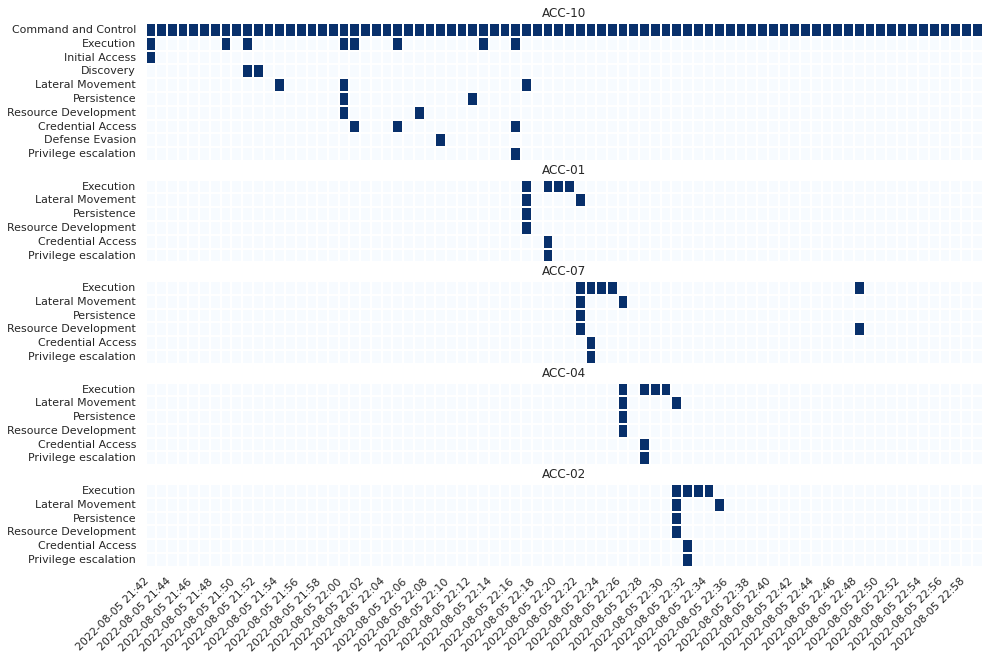

In [114]:
f_start = df.index > '2022-08-05 21:39'
f_end = df.index < '2022-08-05 23:00'
visualize_report_by_subject(df[f_start & f_end], 'T', (15,10), 'mitre_tactic')

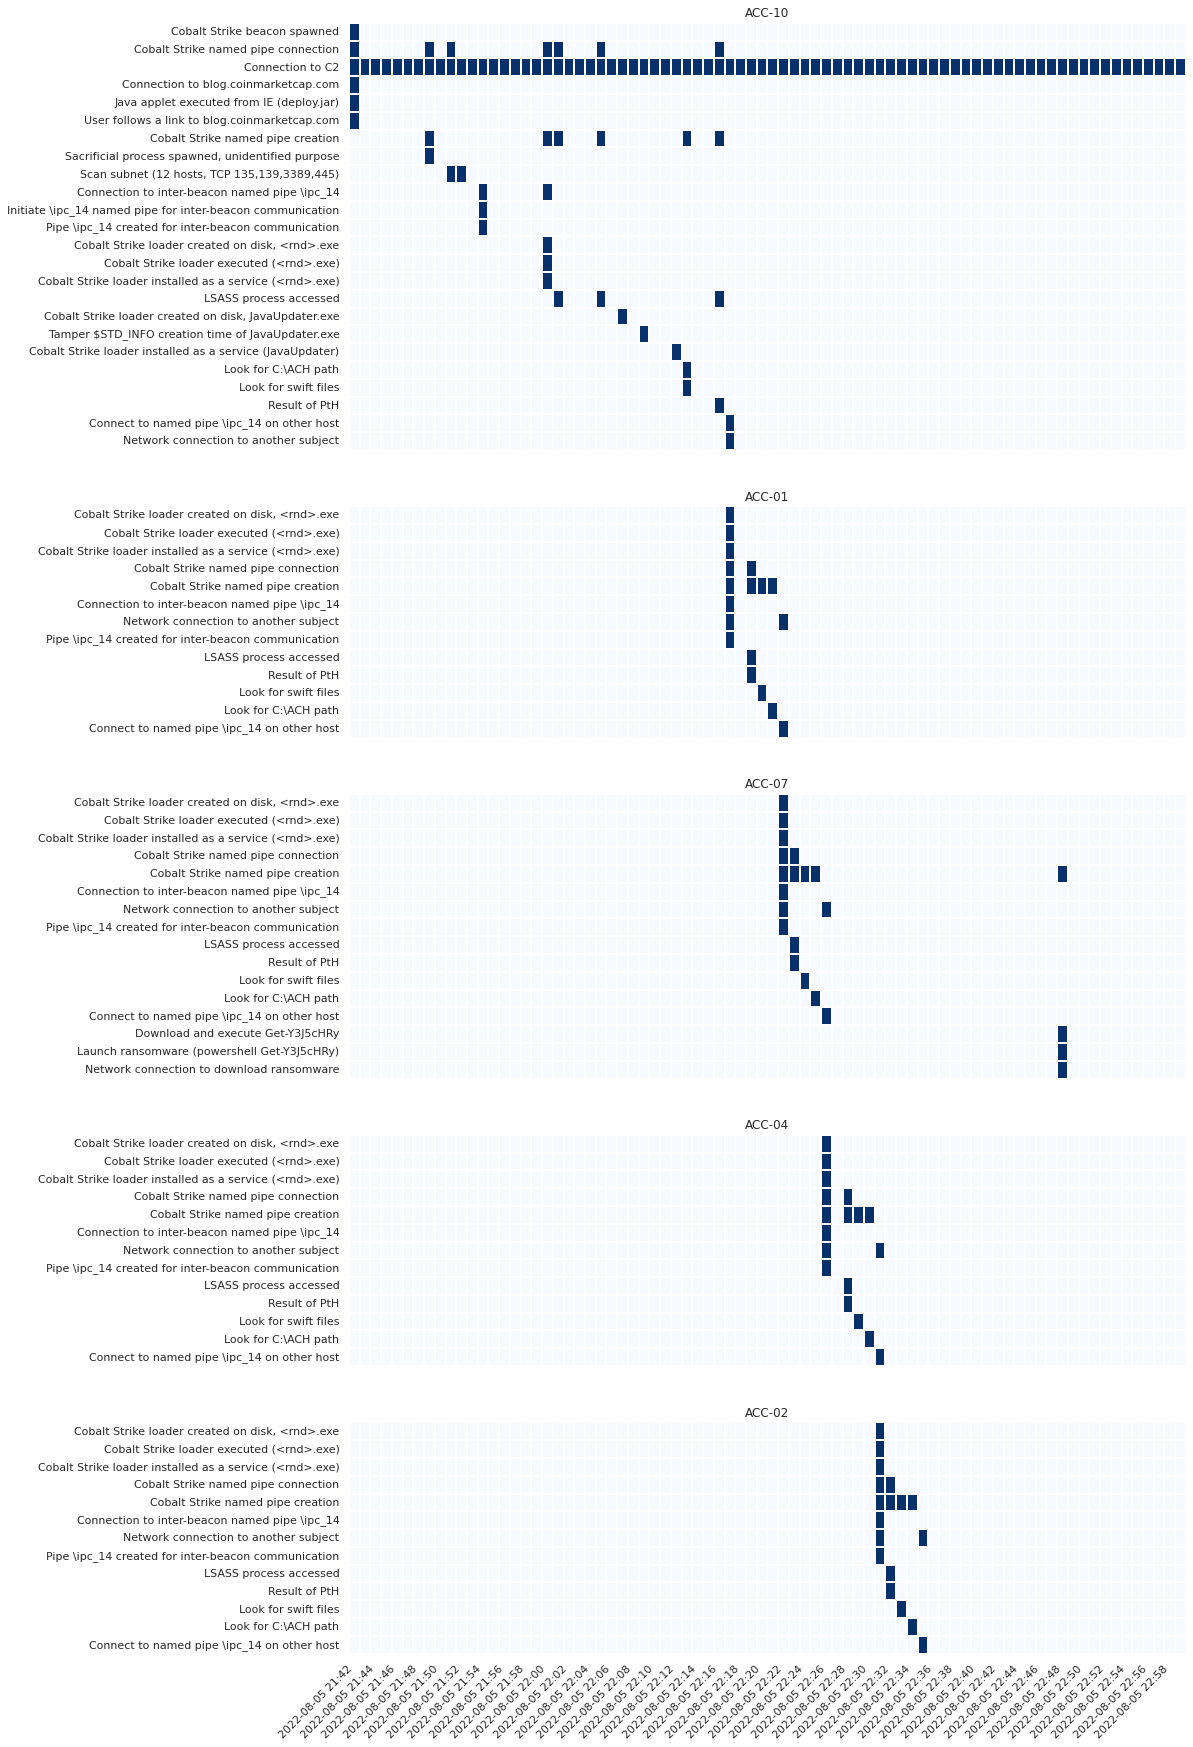

In [115]:
f_start = df.index > '2022-08-05 21:39'
f_end = df.index < '2022-08-05 23:00'
visualize_report_by_subject(df[f_start & f_end], 'T', (15,30), 'report_desc')

## Beginning of the Attack

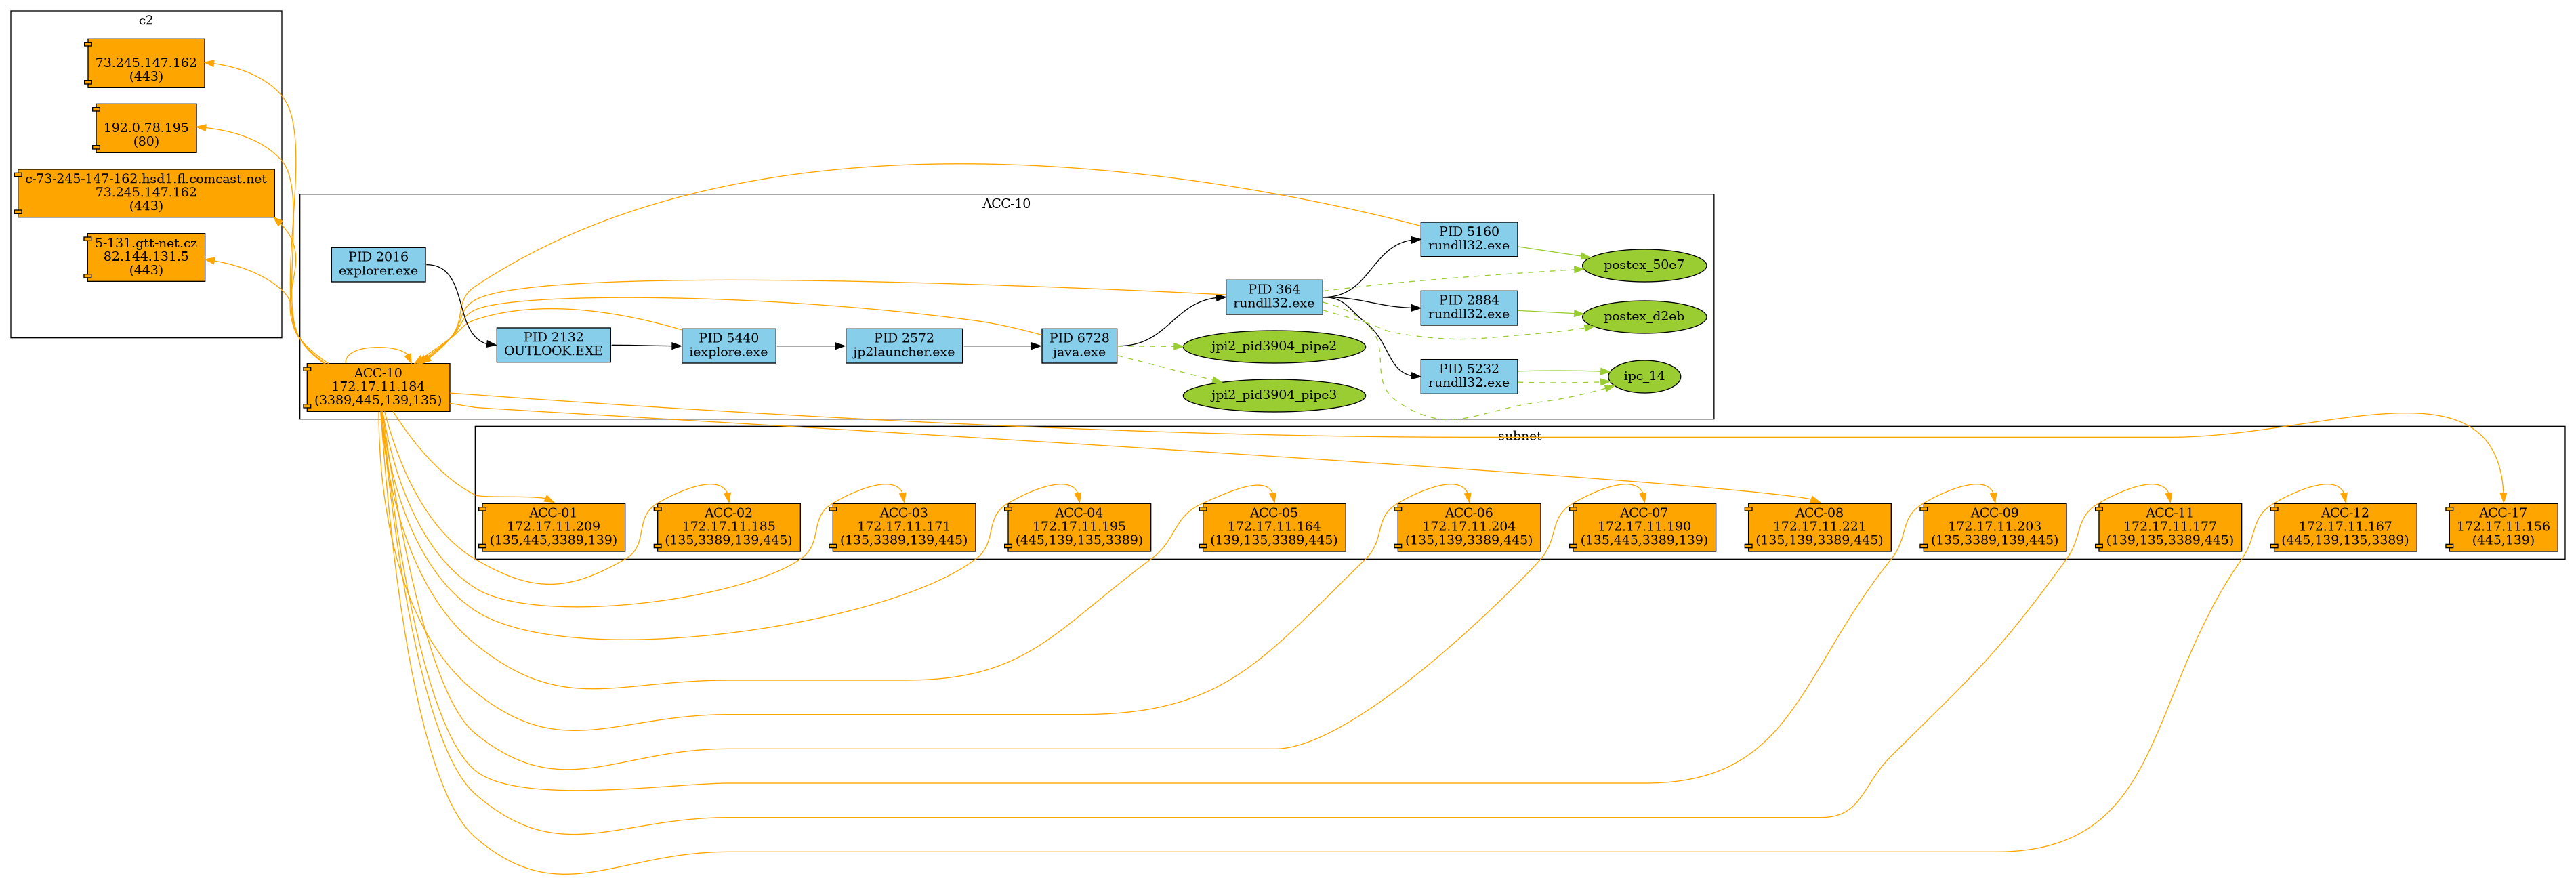

In [176]:
processes, accesses, pipes, connections = get_graph_elements_from_dataframes(
    df_start_processes,
    df_start_access,
    df_start_pipes,
    df_start_network,
)

G = build_graph(['ACC-10'], processes, accesses, pipes, connections, network_simplified=True)
#print(G.string())
display_graph(G)

## Heart of the Attack

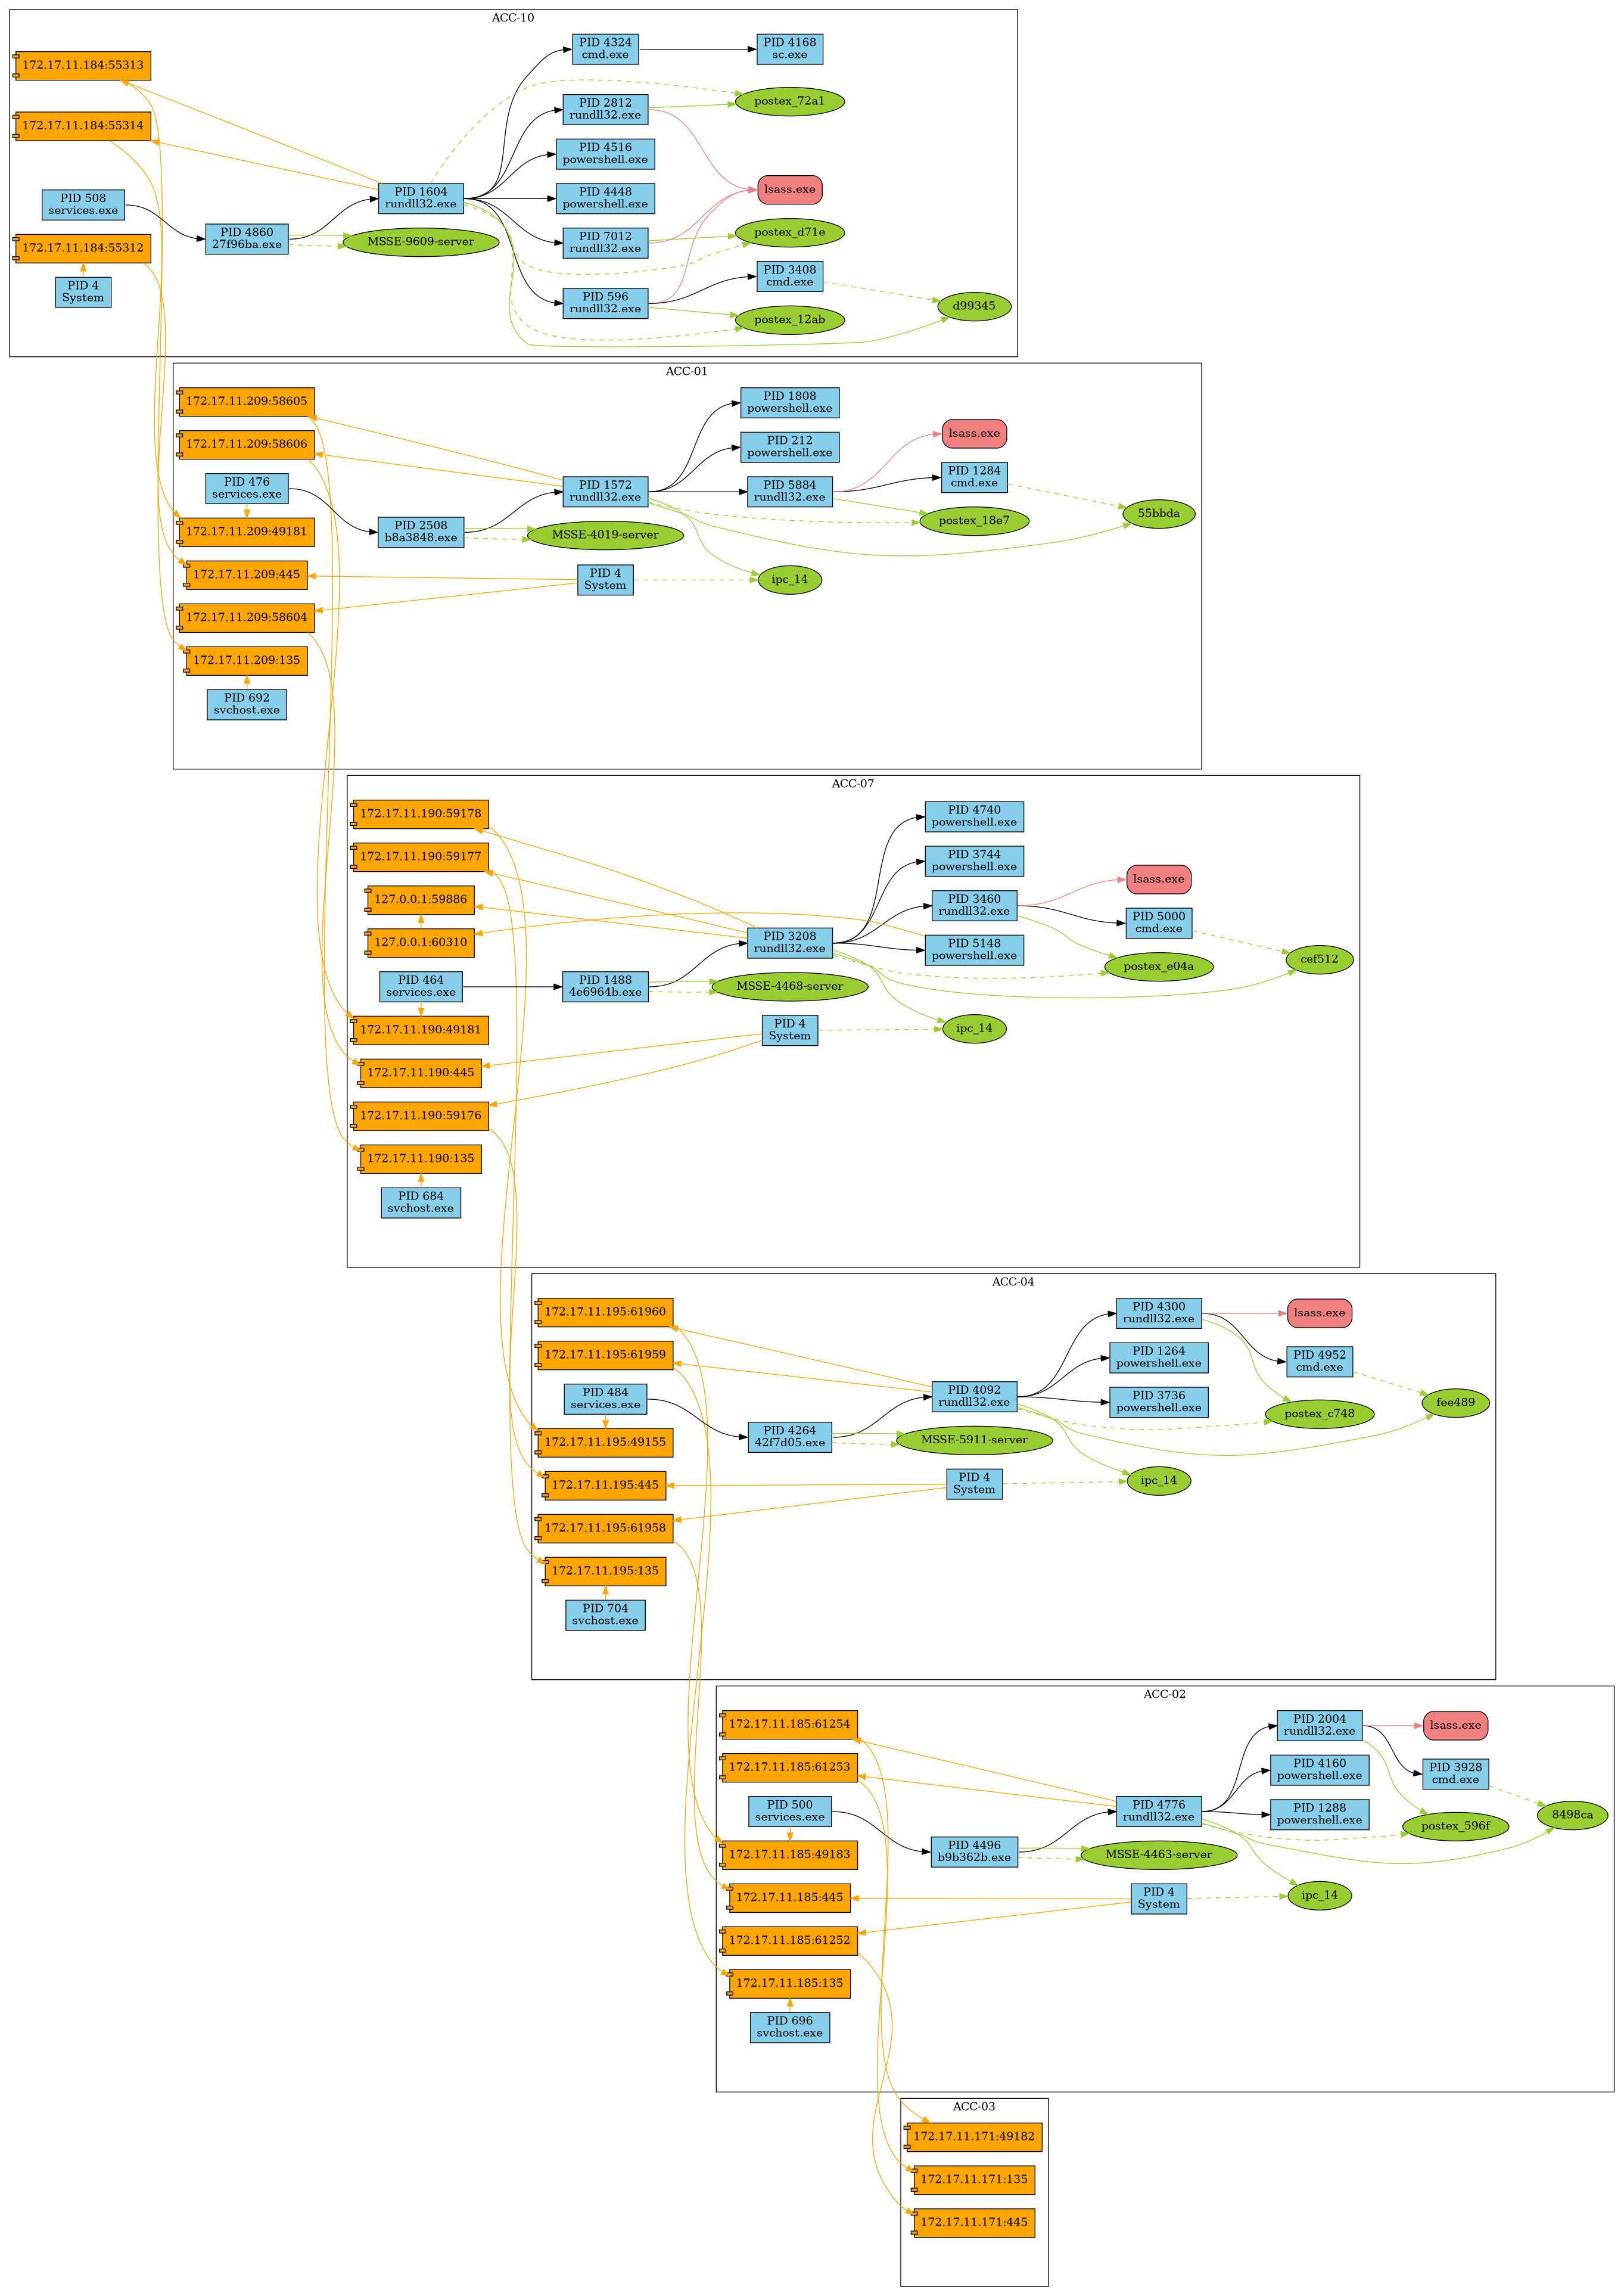

In [166]:
processes, accesses, pipes, connections = get_graph_elements_from_dataframes(
    df_cobalt_processes,
    df_cobalt_access,
    df_cobalt_pipes,
    df_cobalt_network,
)

G = build_graph(subjects, processes, accesses, pipes, connections)
#print(G.string())
display_graph(G)

# Conclusion on Pandas
In addition to the conclusions in case 1, we can say that:
- we reused visualizations from case 1, meaning we can create a library with templates on samples
- we could visualize clearly interactions between subjects and processes
- we could pivot on event sources easily, based on (PID, process name), to uncover more threat actor doings
- we could easily extract chain of processes, forward and backward, from a PID
- subject events are merged in the main dataframe at the beginning: a new subject is just 1 line more then re-run the kernel to be included in the analysis
- we could enrich timeline columns easily with meaningful fields from raw events